# 球谐域的经典声源定位算法

**时间**: 2023/11/5

**作者**: Gavin

欢迎阅读本教程，我们将深入探讨球谐域的声源定位技术。首先，我们会详细介绍波束成形方法，涵盖PWD、DAS和MVDR等技术。随后，我们将转向子空间算法，探索频域MUSIC以及球谐域的SHMUSIC。在教程的最后部分，我们会利用基于最大似然估计的SHMLE方法，对房间内的DoA进行估计。为了全面评估这些算法的性能，我们还特别设计了一系列实验，考察了如宽窄带信号、麦克风数量、阵列数目，信噪比及混响时间等不同参数对结果的影响。

首先，我们先会介绍我们主要使用的几个关键库函数，然后介绍问题和我们采用的仿真方法，希望在本教程结束后，你能对球谐域的声源定位有一个了解。

本notebook的目录内容主要如下：
    
    1. 导入库和模块
    2. 什么是声源定位
    3. 进行仿真
    4. 结果及结论

可以直接在colab中试运行：[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1z2x2xhjd2gI8oABUzZ_qc8iI2hRP8eth?usp=sharing)

In [ ]:
### 若在Colab中运行， 请运行此行，默认为注释
!git clone https://github.com/alexandergwm/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain.git
!pip install pyroomacoustics


## 导入库和模块

本教程假设读者有一些Python, 阵列信号处理和声学的基础。

在Python中，我们可以通过导入包和模块来扩展语言的功能，比如，我们可以通过导入"numpy"等库来对数组和矩阵进行高效的计算操作。numpy库提供了丰富的数学函数以及高级数据结构，非常适合处理多维数组和矩阵。对于声源定位技术，这种处理能力是至关重要的。

例如，我们可以使用numpy来创建和操作数组、执行线性代数操作、进行傅里叶变换等。为了更好地理解和应用本教程中的算法，我们推荐读者熟悉numpy的基本功能和操作。

在后续的章节中，我们还可能使用到其他库，如scipy来进行更复杂的信号处理操作，或者matplotlib来进行数据的可视化。这些库和numpy一同构成了Python在科学计算和数据分析中强大的工具集。因此，对这些库的基本了解将帮助读者更顺利地跟随本教程的内容。


---

### 本教程中使用的主要库及其版本：

- **Python**: 
  - **版本**: 3.8.10

- **os**: 
  - **解释**: os是Python的标准库中的一个模块，提供了与操作系统交互的方法和功能。这个模块包括许多功能，如文件和目录操作（创建、删除、重命名）、获取系统信息、环境变量操作等。

- **numpy**: 
  - **版本**: 1.21.5
  - **解释**: Numpy是Python中用于科学计算的基础包。它包括强大的N维数组对象、复杂的函数、整合C/C++和Fortran代码的工具集、线性代数、傅里叶变换和随机数功能等。

- **pyroomacoustics**: 
  - **版本**: 0.7.2
  - **解释**: Pyroomacoustics是一个专用于音频信号处理和室内声学研究的Python库。它为声音回波、麦克风阵列信号处理和声源定位等任务提供了有用的工具。

- **matplotlib**: 
  - **版本**: 3.5.1
  - **解释**: Matplotlib是Python的绘图库，用于创建静态、动态和交互式的可视化图形。它能绘制各种图表，如直方图、散点图、线图等，对于数据分析和展示都非常有用。

- **soundfile**: 
  - **版本**: 0.12.1
  - **解释**: SoundFile是一个Python库，用于读取和写入声音文件如WAV、FLAC和OGG。它提供了简单易用的API，方便在声源定位任务中处理音频数据。

- **scipy**:
  - **版本**: 1.9.1
  - **解释**: SciPy是基于Numpy的一个开源Python库，用于高级计算。它包含了许多数学、科学和工程计算的模块。
  - **特点模块 - special**: `special`是SciPy的一个子模块，它包含了许多特殊的数学函数，如贝塞尔函数、勒让德函数等，对于球谐域的计算是非常有用的。


---




---

### 本教程中使用的核心模块：

以下模块主要包括作者自行编写或整理的一系列函数，它们在本教程的算法实现中起到关键作用：


**tools**:
- **描述**: tools 模块中包含了本次教程中涉及的一系列的计算相关的函数，详情请见每个函数的注释。

**MicrophoneArray**:
- **描述**: MicrophoneArray 模块中包含了几个不同数量的球麦克风阵列的类。

**plot_tools**:
- **描述**: plot_tools 模块中包含了本次教程中的所有可视化函数，详情请见每个函数的注释。

---


关于声源定位的基本知识，作者之前进行了一个比较粗糙的总结，但是应该能提供一些帮助：[声源定位](https://zhuanlan.zhihu.com/p/544662097)

而关于球谐域中的麦克风阵列及信号处理相关的知识，可以参考此书：
[Fundamentals of Spherical Array Processing](https://link.springer.com/book/10.1007/978-3-662-45664-4)

修改工作目录

In [1]:
import os
print(os.getcwd())
os.chdir('/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain')
print(os.getcwd())

d:\Coderlife\SSL in spherical domain
D:\Coderlife\SSL in spherical domain


导入库和模块

In [54]:
# Import libraries
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import soundfile as sf
import MicrophoneArray
import plot_tools
from tools import cart2sph, sph2cart, soundread, cart2sph
from plot_tools import plot_microphone, plot_wave, plot_stft
from plot_tools import verify_shapeofArray
from scipy.io import wavfile



#### 在本教程中，我们主要使用MHACOUSTICS公司生产的Eigenmike 32通道球状麦克风阵列。该阵列的特点是其半径为4.2cm，且其麦克风布局可被认为满足均匀采样分布条件的硬球壳阵列。

在下一节代码，我们会通过调用MicrophoneArray模块来导入麦克风阵列的信息，其中包含有麦克风阵列的名字，阵列结构，对应的每个麦克风相对于阵列中心为球坐标系原点的俯仰角$\theta$ 和方位角$\phi$， 阵列半径， 采样权重，麦克风数量以及方向性。

![Alt text](image-1.png)

在MicrophoneArray这个文件中，设定了几个类，其中有8个麦克风组成的正方体阵列，有16个均匀分布麦克风的阵列和本教程所用的32个均匀麦克风组成的球阵列，可以按需自己修改。

In [3]:
MicArray32 = MicrophoneArray.EigenmikeEM32()
name = MicArray32.getname()
array_type = MicArray32.gettype()
thetas = MicArray32._thetas
phis = MicArray32._phis
radius = MicArray32._radius
weights = MicArray32._weights
num_elements = MicArray32._numelements
directivity = MicArray32._directivity

# Initialize the list of mic_position in spherical harmonic domain
mic_pos_sph = []

# for each theta and phi, create a new coordinate which contains all parameters
# to the list of mic_pos
for theta, phi in zip(thetas, phis):
    mic_pos_sph.append([radius, theta, phi])
mic_pos_sph = np.array(mic_pos_sph)
print("Name:", name)
print("Array Type:", array_type)
print("Thetas:", thetas)
print("Phis:", phis)
print("Radius:", radius)
print("Weights:", weights)
print("Number of Elements:", num_elements)
print("Directivity:", directivity)

Name: Eigenmike 32
Array Type: Rigid Spherical
Thetas: [1.20427718 1.57079633 1.93731547 1.57079633 0.55850536 0.95993109
 1.57079633 2.18166156 2.58308729 2.18166156 1.57079633 0.95993109
 0.36651914 1.01229097 2.11184839 2.77507351 1.20427718 1.57079633
 1.93731547 1.57079633 0.55850536 0.95993109 1.57079633 2.18166156
 2.58308729 2.18166156 1.57079633 0.95993109 0.36651914 1.01229097
 2.12930169 2.77507351]
Phis: [0.         0.55850536 0.         5.72467995 0.         0.78539816
 1.20427718 0.78539816 0.         5.49778714 5.07890812 5.49778714
 1.58824962 1.57079633 1.57079633 1.55334303 3.14159265 3.70009801
 3.14159265 2.58308729 3.14159265 3.92699082 4.34586984 3.92699082
 3.14159265 2.35619449 1.93731547 2.35619449 4.69493569 4.71238898
 4.71238898 4.72984227]
Radius: 0.042
Weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Number of Elements: 32
Directivity: Omni


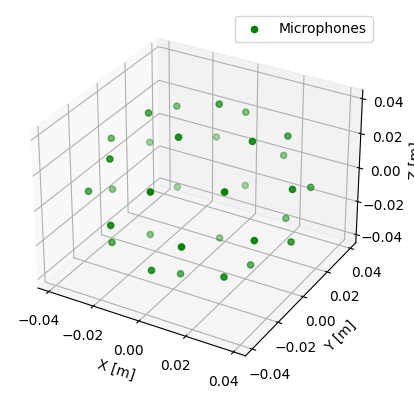

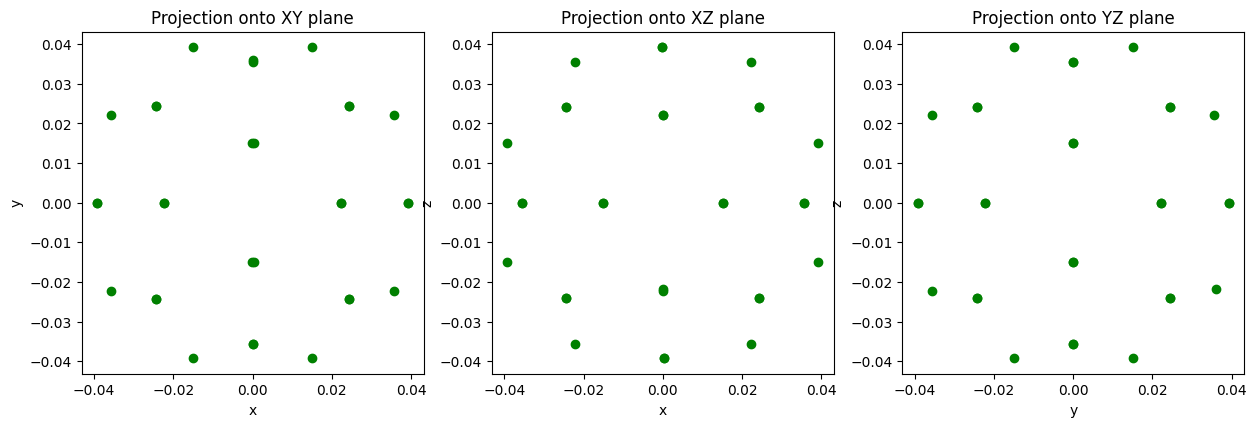

In [4]:
mic_pos_car = [sph2cart(r, theta, phi) for r, theta, phi in mic_pos_sph]
mic_pos_car = np.array(mic_pos_car)

plot_microphone(mic_pos_car)
verify_shapeofArray(mic_pos_car)

### 球谐域中的声源定位原理

在这里会我们主要介绍球谐域中的声源定位原理，其中有几个比较重要的基本概念需要先被提及。

**球谐表示**:

在单位球体上定义的函数可以使用球谐函数作为基函数来进行表示：
$$
f ( \theta , \phi ) = \sum _ { n = 0 } ^ { \infty } \sum _ { m = - n } ^ { n } f_{nm} Y _ { n } ^ { m } ( \theta , \phi ) \tag{1}
$$

这里的 $\theta$ 和 $\phi$ 分别表示俯仰角和方位角

而球谐基函数的表达式如下：

\begin{equation}
Y_n^m (\theta,\phi) = \sqrt{\frac{2n+1}{4\pi}\frac{(n-m)!}{(n+m)!}}p_n^m(cos\theta)e^{im\phi} \tag{2}
\end{equation}

这里有$n \geq 0$为球谐域的阶数(order), $m \leq |n|$为球谐域的度数(degree),  $p_n^m(\theta, \phi)$ 为连带勒让德函数，且$f_{nm}$ 为球谐系数，其是通过球谐傅里叶变换，从采样数据中提取出声场的球谐系数：

\begin{equation}
f _ { n m } = \int _ { 0 } ^ { 2 \pi } \int _ { 0 } ^ { \pi } f ( \theta ,\phi) [ Y _ { n } ^ { m } ( \theta , \phi ) ] ^ { * } \sin \theta d \theta d \theta  \tag{3}
\end{equation}

这里也可以说成是 **函数$f(\theta,\phi)$在球函数基上的投影被称为球谐函数分解(Spherical Harmonic Decomposition)**,  而SHD函数利用几个非零SHD系数提供了球体上的函数和分布的逼近表示。比如，在这个教程中，我们可以用25个球谐系数来表示32个通道的麦克风采集的数据。下图便是从$n \leq 4$的球谐基函数的球状图。

<p align="center">
  <img src="image.png" alt="Spherical Harmonic Basis Functions"/>
</p>

从上面式子可以看到，如果我们知道了球体上各处的压力分布，那么就可以直接得到对应的SHD系数，但是在实际中，我们只能在球体上有限数量的点对球体上的压力进行采样，若压力在$Q \geq (N+1)^2$ 上个离散点$(\theta_q, \phi_q)$ 进行采样 (为了避免出现aliasing)，那么可以近似地使用求和来近似, 这里的$Q$ 代表麦克风阵列的麦克风数量， $N$ 表示球谐展开的最大阶数。

\begin{equation}
p_{nm}(k) = \sum_{q=1}^{Q} w_q p(\theta_q, \phi_q, k)[Y_n^m(\theta_q,\phi_q)]^*  \tag{4}
\end{equation}

这里的$w_q$ 为正交权重，其能确保求和是一个有效的近似。如果采样方案是正交的，这些权重会使得离散球谐展开到真实的连续球谐展开。（这里的采样方案正交是指在这些采样点上，球谐函数满足某种正交关系，如均匀分布的球阵列，有：
\begin{equation}
\frac{4\pi}{Q}j Y^H(\theta,\phi)Y(\theta,\phi) = I_{(N+1)^2}  \tag{5}
\end{equation}



**平面波假设**：

当声源与麦克风阵列之间的距离足够远时，可以假定从声源发出的声波在到达麦克风阵列时已经转化为平面波。这种情况下，声波的所有波前都是平行的，并且沿着同一方向传播。

在这里，我们假设声场由$L$ 个平面波组成，第$l$ 个平面波的波达方向(DOA)为$\Psi_l = (\theta_l, \phi_l) (l=1,2,...,L)$, $s_l(k)$ 为其幅度，$k$ 表示波数。使用$Q$ 单元，半径为$a$ 的均匀分布球阵列，$\Omega_q = (\theta_q, \phi_q)$ 为第 $q$ 个麦克风的空间位置。

那么对于以角度$\Psi_l$ 入射的平面波，第$q$个麦克风处的声压可以表示为：

\begin{equation}
p(kr,\Omega_q) = \sum_{l=1}^{L}s_l(k)e^{i\boldsymbol{k}_l^T \boldsymbol{r}_q} \approx \sum_{l=1}^{L}s_l(k) \sum_{n=0}^{N}\sum_{m=-n}^{n}b_n(kr)Y_{n,m}^*(\Psi_l) Y_{n,m}(\Omega_q)   \tag{6}
\end{equation}

这里有，$\boldsymbol{k}_l = -k(\cos\phi_l \sin\theta_l, \sin\phi_l \sin\theta_l, \cos\theta_l)^T$ 为平面波的波矢量， $\boldsymbol{r}_q = r(\cos \phi_q \sin \theta_q, \sin \phi_q \sin \theta_q, \cos \theta_q)^T$ 为第$q$ 个麦克风的笛卡尔坐标。而$b_n(kr)$ 是一个与球阵列的结构有关的函数，也可以称为辐射函数，有：
\begin{equation}
b_n(kr) =
\begin{cases}
4\pi i^n \left[ j_n(kr) - \frac{j_n'(ka)}{h_n'(ka)} h_n(kr) \right], & \text{刚性球} \\
4\pi i^n j_n (kr), & \text{空心球}    \tag{7}
\end{cases}
\end{equation}
这里，$j_n(\cdot)$ 和 $h_n(\cdot)$ 分别表示球Bessel函数和球Hankel函数。

**空间搜索**

本教程中的所有声源定位算法均是基于on-grid原理的，大致来说，可以通过搜索整个空间，找出与实际测量数据最匹配的声源方向，如 波束形成技术，通过空间滤波，加强来自某一方向的信号，从而抑制其他方向的信号。

### 设定DoA

假设此时声源的方向来自(50,230)， 并且分别考虑了rigid-sphere 和 open-sphere两种情况

In [5]:
Theta_l = 50/180 * np.pi
Phi_l = 230/180 * np.pi

### 什么是波束形成
从定义上来说，我们在使用麦克风阵列时，我们期望能够通过算法处理增强来自位于特定方向的声源的信号并衰减来自于其他方向的声源的信号，从而形成空间或方向滤波器，这种滤波器就被称为波束形成器。我们在衡量一个阵列性能时，常用两个指标，一个是方向性指数，另一个是白噪声增益（WNG），我们从之前的空间域出发来进行推导。

先从直觉上来看，我们使用阵列来处理信号，目的就是得到一个滤波器，从而能过选择我们想要的信号，舍弃不想要的信号，那么考虑一个加权函数$[w(k,\theta,\phi)]^*$  与声压函数$p(k,r,\theta,\phi)$相乘就是我们想要得到的输出了$y$了，但是在理论中，我们需要对整个球体表面进行积分，表达如下式：

\begin{equation}
y = \int_{0}^{2\pi} \int_{0}^{\pi} [w(k,\theta,\phi)]^* p(k,r,\theta,\phi) sin\theta d\theta d\phi  \tag{8}
\end{equation}
在我们这个例子中，我们通过$Q$ 个麦克风组成的球麦克风阵列，其中，有麦克风$q$ 在波数$k$ 处采集到的声压由$p_q(k) = p(k,r,\theta_q,\phi_q)$ 进行表示，所以最后我们可以得到一个形状为$Q \times 1$ 的表示声压幅值的矢量：

\begin{equation}
\boldsymbol{p} = [p_1(k),p_2(k),...,p_Q(k)]^T  \tag{9}
\end{equation}

而此时也自然地考虑滤波器系数的离散表示，对于麦克风$q$， 有系数$w_q(k)$：

\begin{equation}
\boldsymbol{w} = [w_1(k), w_2(k), ...,w_Q(k)]^T \tag{10}
\end{equation}

那么联合起来，就可以得到传统的空间中阵列输出表达：

\begin{equation}
y = \boldsymbol{w}^H \boldsymbol{p}    \tag{11}
\end{equation}
但是在这里，我们不能够直接将离散形式的输出与之前的连续形式的输出直接等价起来，因为离散形式必须要考虑空间中的采样的影响。

这里我们从简单情况进行推导，假设声场的阵列输入由单频率的单位幅值的平面波组成，在这种情况下，我们可以引入转向矢量或者流形矢量来表示测量的压力，其表示在每个麦克风处测量得到的平面波幅度，对于自由场中由压力麦克风采集到的信号，其有如下的表达形式：

\begin{equation}
\boldsymbol{v} = [v_1, v_2, ..., v_Q]^T  \tag{12}
\end{equation}

这里的$v_q = e^{i \boldsymbol{\tilde{k}\cdot r}}， 1 \leq q \leq Q$, $\boldsymbol{\tilde{k}} = (k,\theta_k,\phi_k)$ 表示平面波的到达方向，位置向量$\boldsymbol{r} = (r, \theta_q,\phi_q)$ 表示第$q$ 个麦克风的位置，那么阵列输出可以写为：

\begin{equation}
y = \boldsymbol{w^H v}    \tag{13}
\end{equation}


之后我们考虑在球谐函数域导出空间域开发的阵列方程，考虑用$p_{nm}(k)$ 和$w_{nm}(k)$ 来表示压力函数和权重系数的球傅里叶变换系数，并利用球谐函数的正交性来估计积分，那么此时阵列的输出Equ. (1)可以写成：
\begin{equation}
y = \sum_{n=0}^{N} \sum_{m=-n}^{n}[w_{nm}(k)]^* p_{nm}(k, r)   \tag{14}
\end{equation}

上述方程可以写为矩阵形式：
\begin{equation}
y = \boldsymbol{w_{nm}}^H \boldsymbol{v_{nm}}  \tag{15}
\end{equation}

这里的$\boldsymbol{v}_{nm}$ 为一个大小为$(N+1)^2 \times 1$ 的列矢量， 其定义为：
\begin{equation}
\boldsymbol{v}_{nm} = [v_{00}, v_{1(-1)}, v_{11},...,v_{NN}]^T \tag{16}
\end{equation}

其中$v_{nm}$ 代表平面波声场的阵列输入，来自单位振幅平面波的声压$p_{nm}$, 对于不同球体结构，我们之前有表达式，这里重写一下：
\begin{equation}
v_{nm} = p_{nm}(k,r) = b_n(kr)[Y_n^m(\theta_k, \phi_k)]^*  \tag{17}
\end {equation}

这里的平面波的DoA为$(\theta_k, \phi_k)$

之后，为了链接起离散和连续的表达式，我们引入采样的影响，得到球谐域矢量$\boldsymbol{w}_{nm}$， $\boldsymbol{p}_{nm}$ 和 空间域矢量$\boldsymbol{w}$ 和$\boldsymbol{p}$ 之间的关系，对于不同的抽样方案，也就是不同的麦克风分布在球面的情况，有不同的正交关系被引入，在这里我们主要考虑的是均匀采样, $\boldsymbol{w}_{nm} = \frac{4\pi}{Q} \boldsymbol{Y}^H \boldsymbol{w}$，带入阵列输出的表达式中，可以得到：
\begin{equation}
y = \boldsymbol{w}^H[(\frac{4\pi}{Q})^2 \boldsymbol{YY^H}]\boldsymbol{p} \tag{18}
\end{equation}

那么其实我们的核心就是求得一个最佳的权重，所以Meyer 和Elko提出了一种权重$w_{nm}$公式，因为如果我们通过使用逆球面傅里叶变换从$w_{nm}$ 求得$w(\theta,\phi)$， 此时权重是二维空间域中的$n$和$m$ 的函数，他们提出的方法可以将波束形成权重降维至一维函数，使得所得的波束形成图是轴对称的（沿着观察方向）：
\begin{equation} 
[w_{nm}(k)]^* = \frac{d_n(k)}{b_n(kr)} Y_n^m(\theta_l,\phi_l) \tag{19}
\end{equation}

新的波束成形权重$d_n(k)$ 可能是频率的函数，仅和$n$相关，因此可以被视为一维。而除以$b_n(kr)$ 是为了保证生成的转向向量和波束方向图不依赖于阵列结构从而引起的声场的物理行为。$(\theta_l,\phi_l)$ 为阵列的观察方向。
将此时的频率系数带入阵列输出的表达式，有：
\begin{equation}
y = \sum_{n=0}^{N} \sum_{m=-n}^{n}[w_{nm}(k)]^* p_{nm}(k, r) \
= \sum_{n=0}^{N} \frac{d_n(k)}{b_n(kr)} \sum_{m=-n}^{n}Y_n^m(\theta_l, \phi_l) p_{nm}(k, r) \tag{20}
\end{equation}

然后又把$p_{nm}(k,r)$ 的表达式带入阵列输出中，可以得到：
\begin{equation}
y = \sum_{n=0}^{N} d_n(k) \sum_{m=-n}^n [Y_n^m(\theta_k, \phi_k)]^* Y_n^m(\theta_l,\phi_l)
 \\ = \sum_{n=0}^N d_n(k) \frac{2n + 1}{4\pi} P_n(cos\Theta)    \tag{21}
\end{equation} 

这里运用了球谐函数的可加性，有:
\begin{equation}
cos\Theta = cos\theta_l cos\theta_k + cos(\phi_l - \phi_k) sin\theta_l sin\theta_k  \tag{22}
\end{equation}

这里的$\Theta$  为在$(\theta_l, \phi_l)$ 和$(\theta_k,\phi_k)$ 之间的一个角度。

之后可以通过定义一个转向向量$\boldsymbol{v}_n$ 和一个阵列权重向量$\boldsymbol{d}_n$：
\begin{equation} 
y = \boldsymbol{d}_n^T \boldsymbol{v}_n \tag{23}
\end{equation}

\begin{equation}
\boldsymbol{v}_n = \frac{1}{4\pi}[P_0(cos\Theta), 3P_1(cos\Theta), ..., (2N+1)P_N(cos\Theta)]^T  \tag{24}
\end{equation}

\begin{equation}
\boldsymbol{d}_n = [d_0, d_1,...,d_N]^T  \tag{25}
\end{equation}

现在，也可以说成是阵列权重$d_n$ 可控制输出$y(\Theta)$ ， 其是阵列的波束方向图，也可以说成是对单位幅值平面波的阵列响应，输出$y$ 取决于$\Theta$， 通常，$y(\Theta)$ 在$\Theta = 0$处达到峰值，也就意味着从这个方向到达的平面波能够受到最高的放大，这个方向就常被认为是最感兴趣的方向，现在通过改变$(\theta_l, \phi_l)$的值，函数$y(\Theta)$ 本身不会改变，但是其会被选择或者转向，从而使得$\Theta = 0$ 与$(\theta_l,\phi_l)$ 一致。

### 如何衡量阵列性能？  指向性指数和白噪声增益

#### 指向性指数(Directivity Index)
响应单位幅度平面波的阵列输出$y$ 被表示为定义阵列的方向性或波束方向图。而量化阵列方向性的标量是方向性指数，其提供了平方波束方向图的峰值与平均值之间的比率的度量，方向性因子，定义为DF：
\begin{equation}
DF = \frac{|y(\theta_l,\phi_l)|^2}{\frac{1}{4\pi}\int_{0}^{2\pi} \int_{0}{\pi}|y(\theta,\phi)|^2 sin\theta d\theta d\phi}  \tag{26}
\end{equation}

#### 白噪声增益(White Noise Gain)
白噪声增益(WNG) 被定义为去衡量阵列对于噪声和不确定性的不良影响鲁棒性的一个指标，其定义为与阵列输入相比，阵列输出的SNR的改进。有球谐域矩阵形式下的表达为：
\begin{equation}
WNG = \frac{\boldsymbol{d}_n^H \boldsymbol{A}\boldsymbol{d}_n}{\boldsymbol{d}_n^H \boldsymbol{B}\boldsymbol{d}_n}  \tag{27}
\end{equation}

\begin{equation}
\boldsymbol{A} = \boldsymbol{v_n}\boldsymbol{v_n}^H      \tag{28}
\end{equation}

\begin{equation}
\boldsymbol{B} =  \frac{4\pi}{Q} diag(\boldsymbol{v_n}) \times diag(|b_0|^{-2},|b_1|^{-2},...,|b_N|^{-2})    \tag{29}
\end{equation}  

\begin{equation}
\boldsymbol{v_n} = \frac{1}{4\pi}[1,3,5,...,2N+1]^T     \tag{30}
\end{equation}

#### 延迟求和波束形成器 (Delay and Sum)

这是一个十分经典的且实现简单的波束形成器，通过给来自各个传感器的信号施加不同的时间延迟，使得来自特定方向的信号在相加时相位一致，从而增强该方向的信号并抑制其他方向的噪声。除此之外，DAS算法还能提供最大的WNG，从而提供对噪声和不确定性最大的鲁棒性，但是这种方法仅在平面波在自由场中传播有效。 联立方程(19)和(16), 可以得到轴对称波束形成的输出公式：
\begin{equation}
y = \sum_{n=0}^{N}\sum_{m=-n}^{n}[w_{nm}(k)]^*p_{nm}(k,r) = \sum_{n=0}^{N}\sum_{m=-n}^{n}d_n(k)Y_n^m(\theta_l,\phi_l)\frac{p_{nm}(k,r)}{b_n(kr)}   \tag{31}
\end{equation}

而针对这里的DAS算法，此时延迟求和的波束形成器的轴对称波束形成权重$d_n$ 为：
\begin{equation}
d_n(k) = |b_n(kr)|^2     \tag{32}
\end{equation}
那么DAS的输出为：
\begin{equation}
y = \sum_{n=0}^{N}\sum_{m=-n}^{n}|b_n(kr)|^2 a_{nm}(k)Y_n^m(\theta_l,\phi_l)   \tag{33}
\end{equation}

现在可以使用各种阵列配置测量的声场来计算$a_{nm}(k)$, 在本案例的球麦克风阵列配置中，满足$a_{nm}(k) = \boldsymbol{B}^{-1}(kr) \boldsymbol{p}_{nm}(kr)$。
所以此时将方程联立，可以得到矩阵形式下的DAS的成本函数表达式：
\begin{equation}
J_{DAS}(\Psi) = 20 log_{10} |(\boldsymbol{B}(kr)\boldsymbol{y}(\Psi)^*)^H \boldsymbol{p}_{nm}(kr)|   \tag{34}
\end{equation}

In [6]:
from tools import ssl_SHmethod, ssl_SHmethod_broad

source_pos: [[ 49]
 [230]]


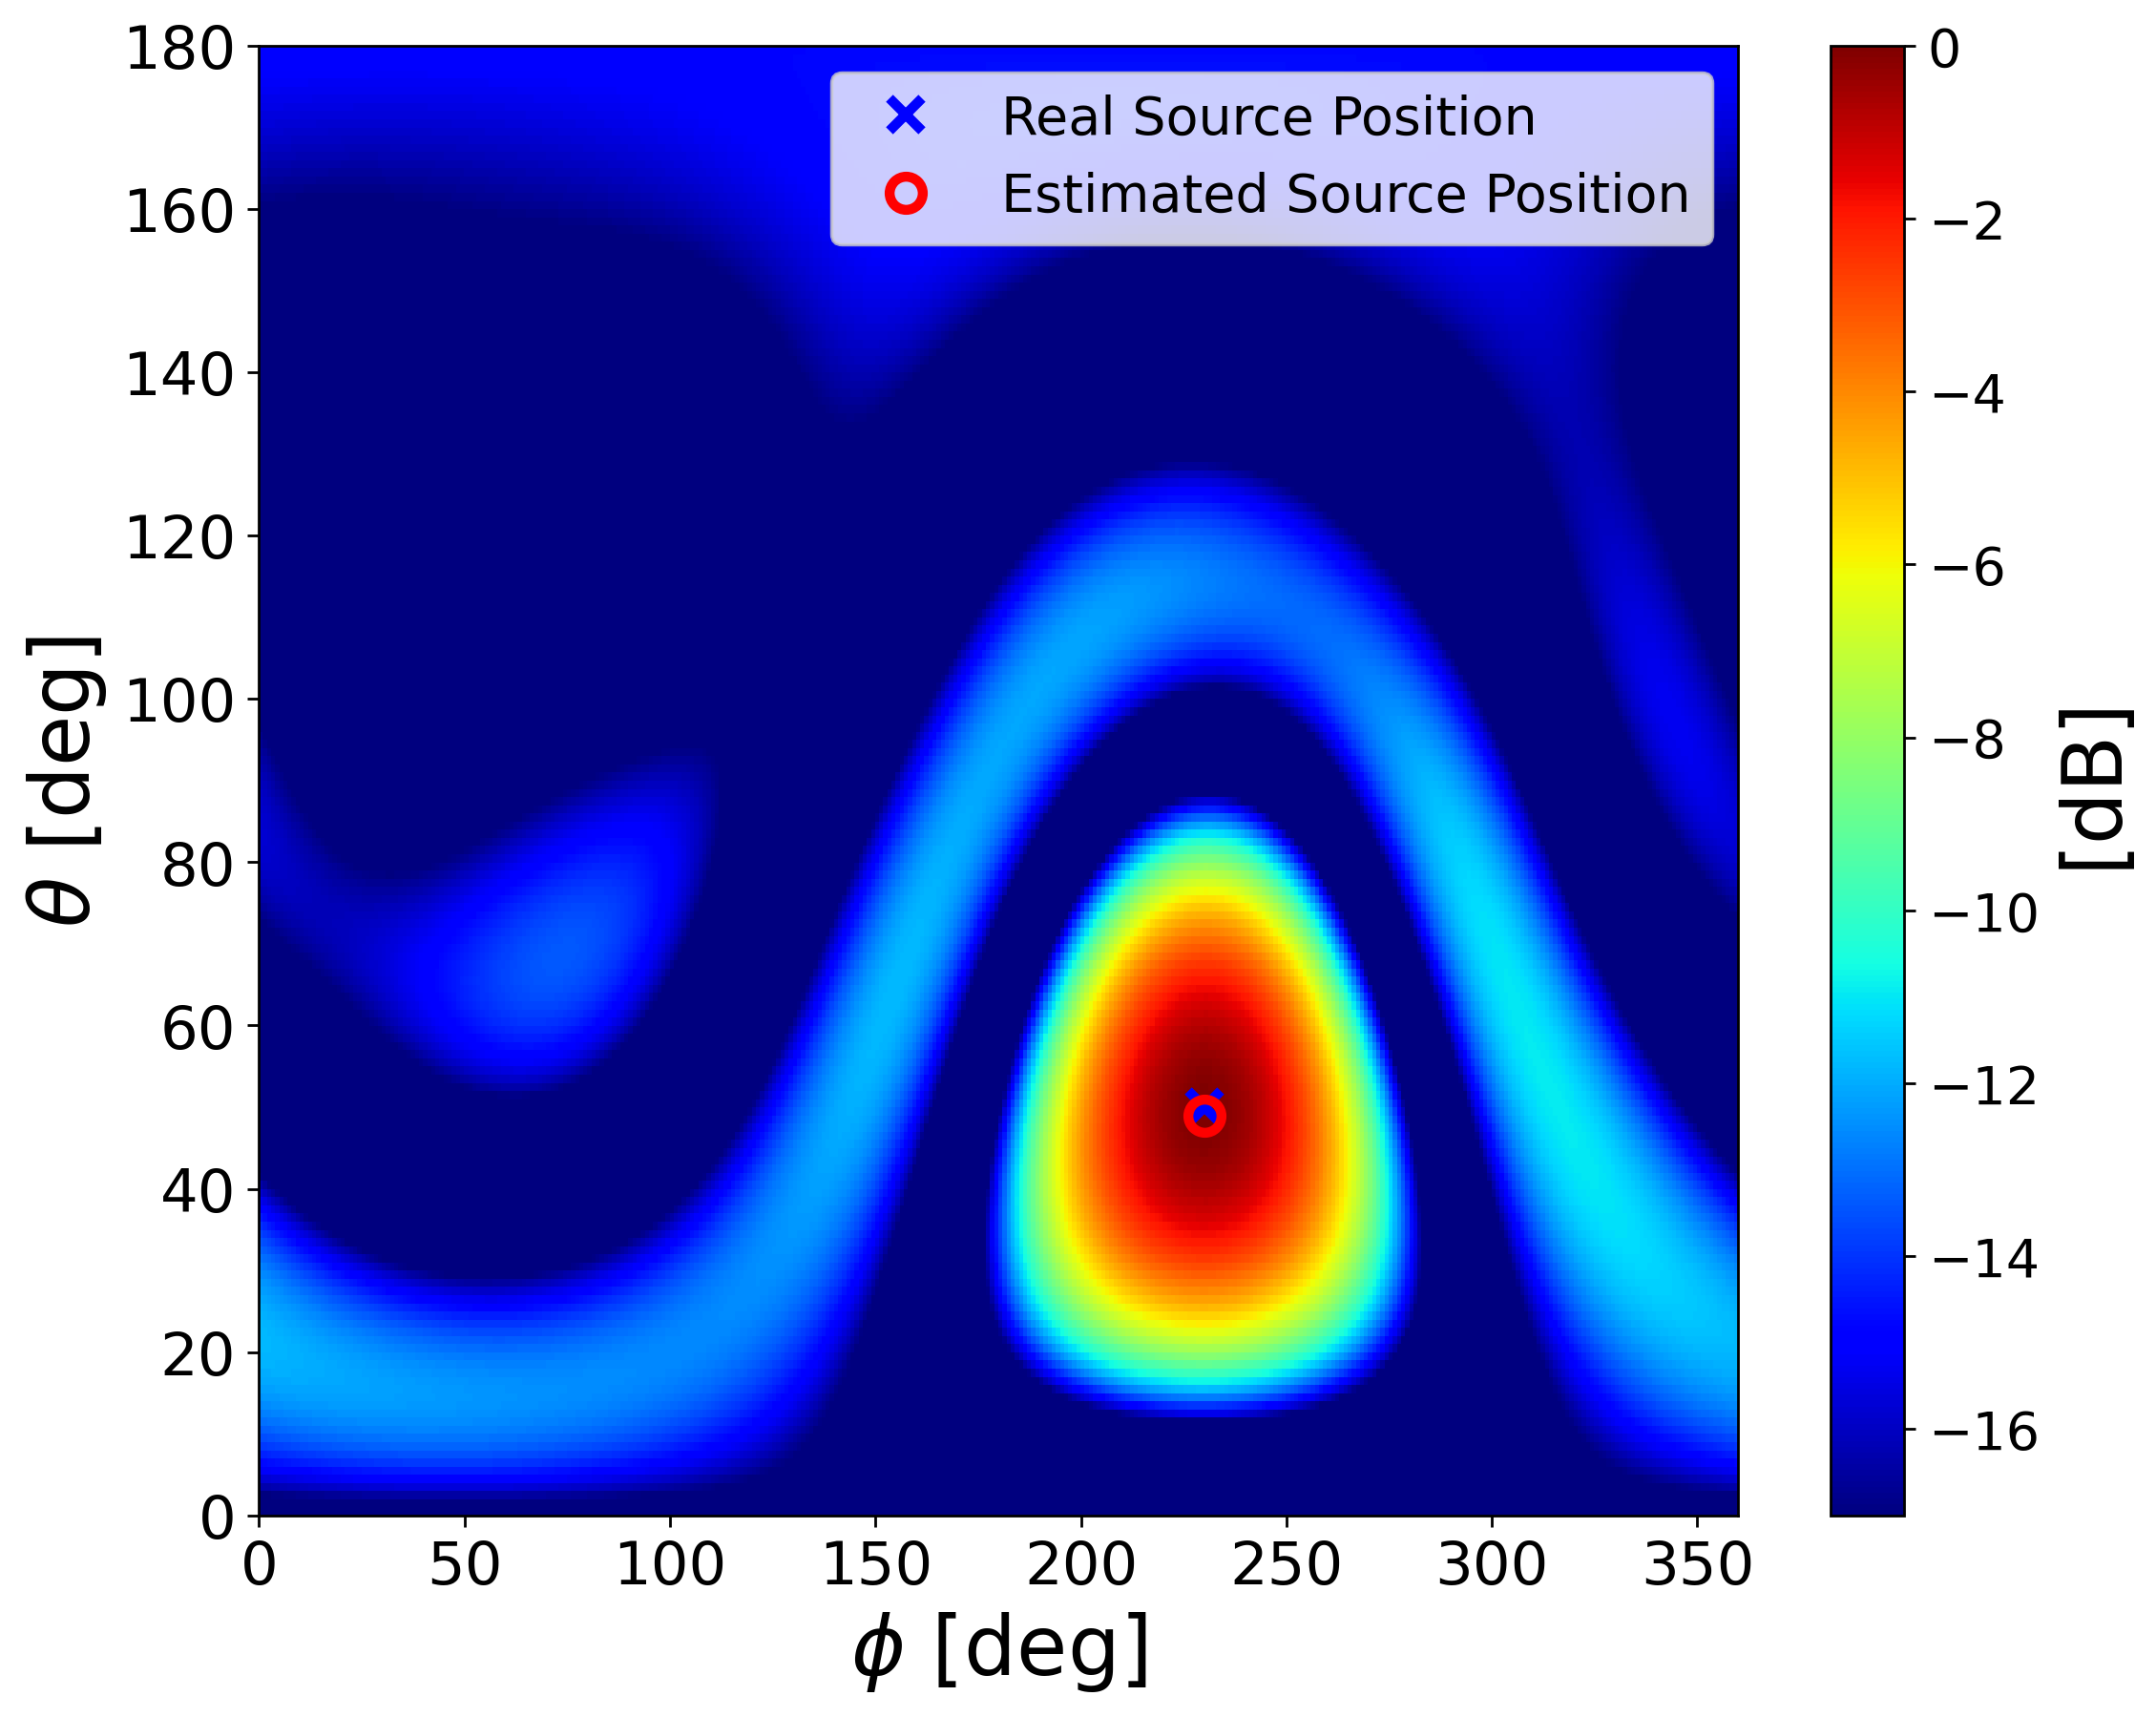

In [7]:
out_das_open, est_das_open = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "DAS", "open", "2D")

source_pos: [[ 49]
 [231]]


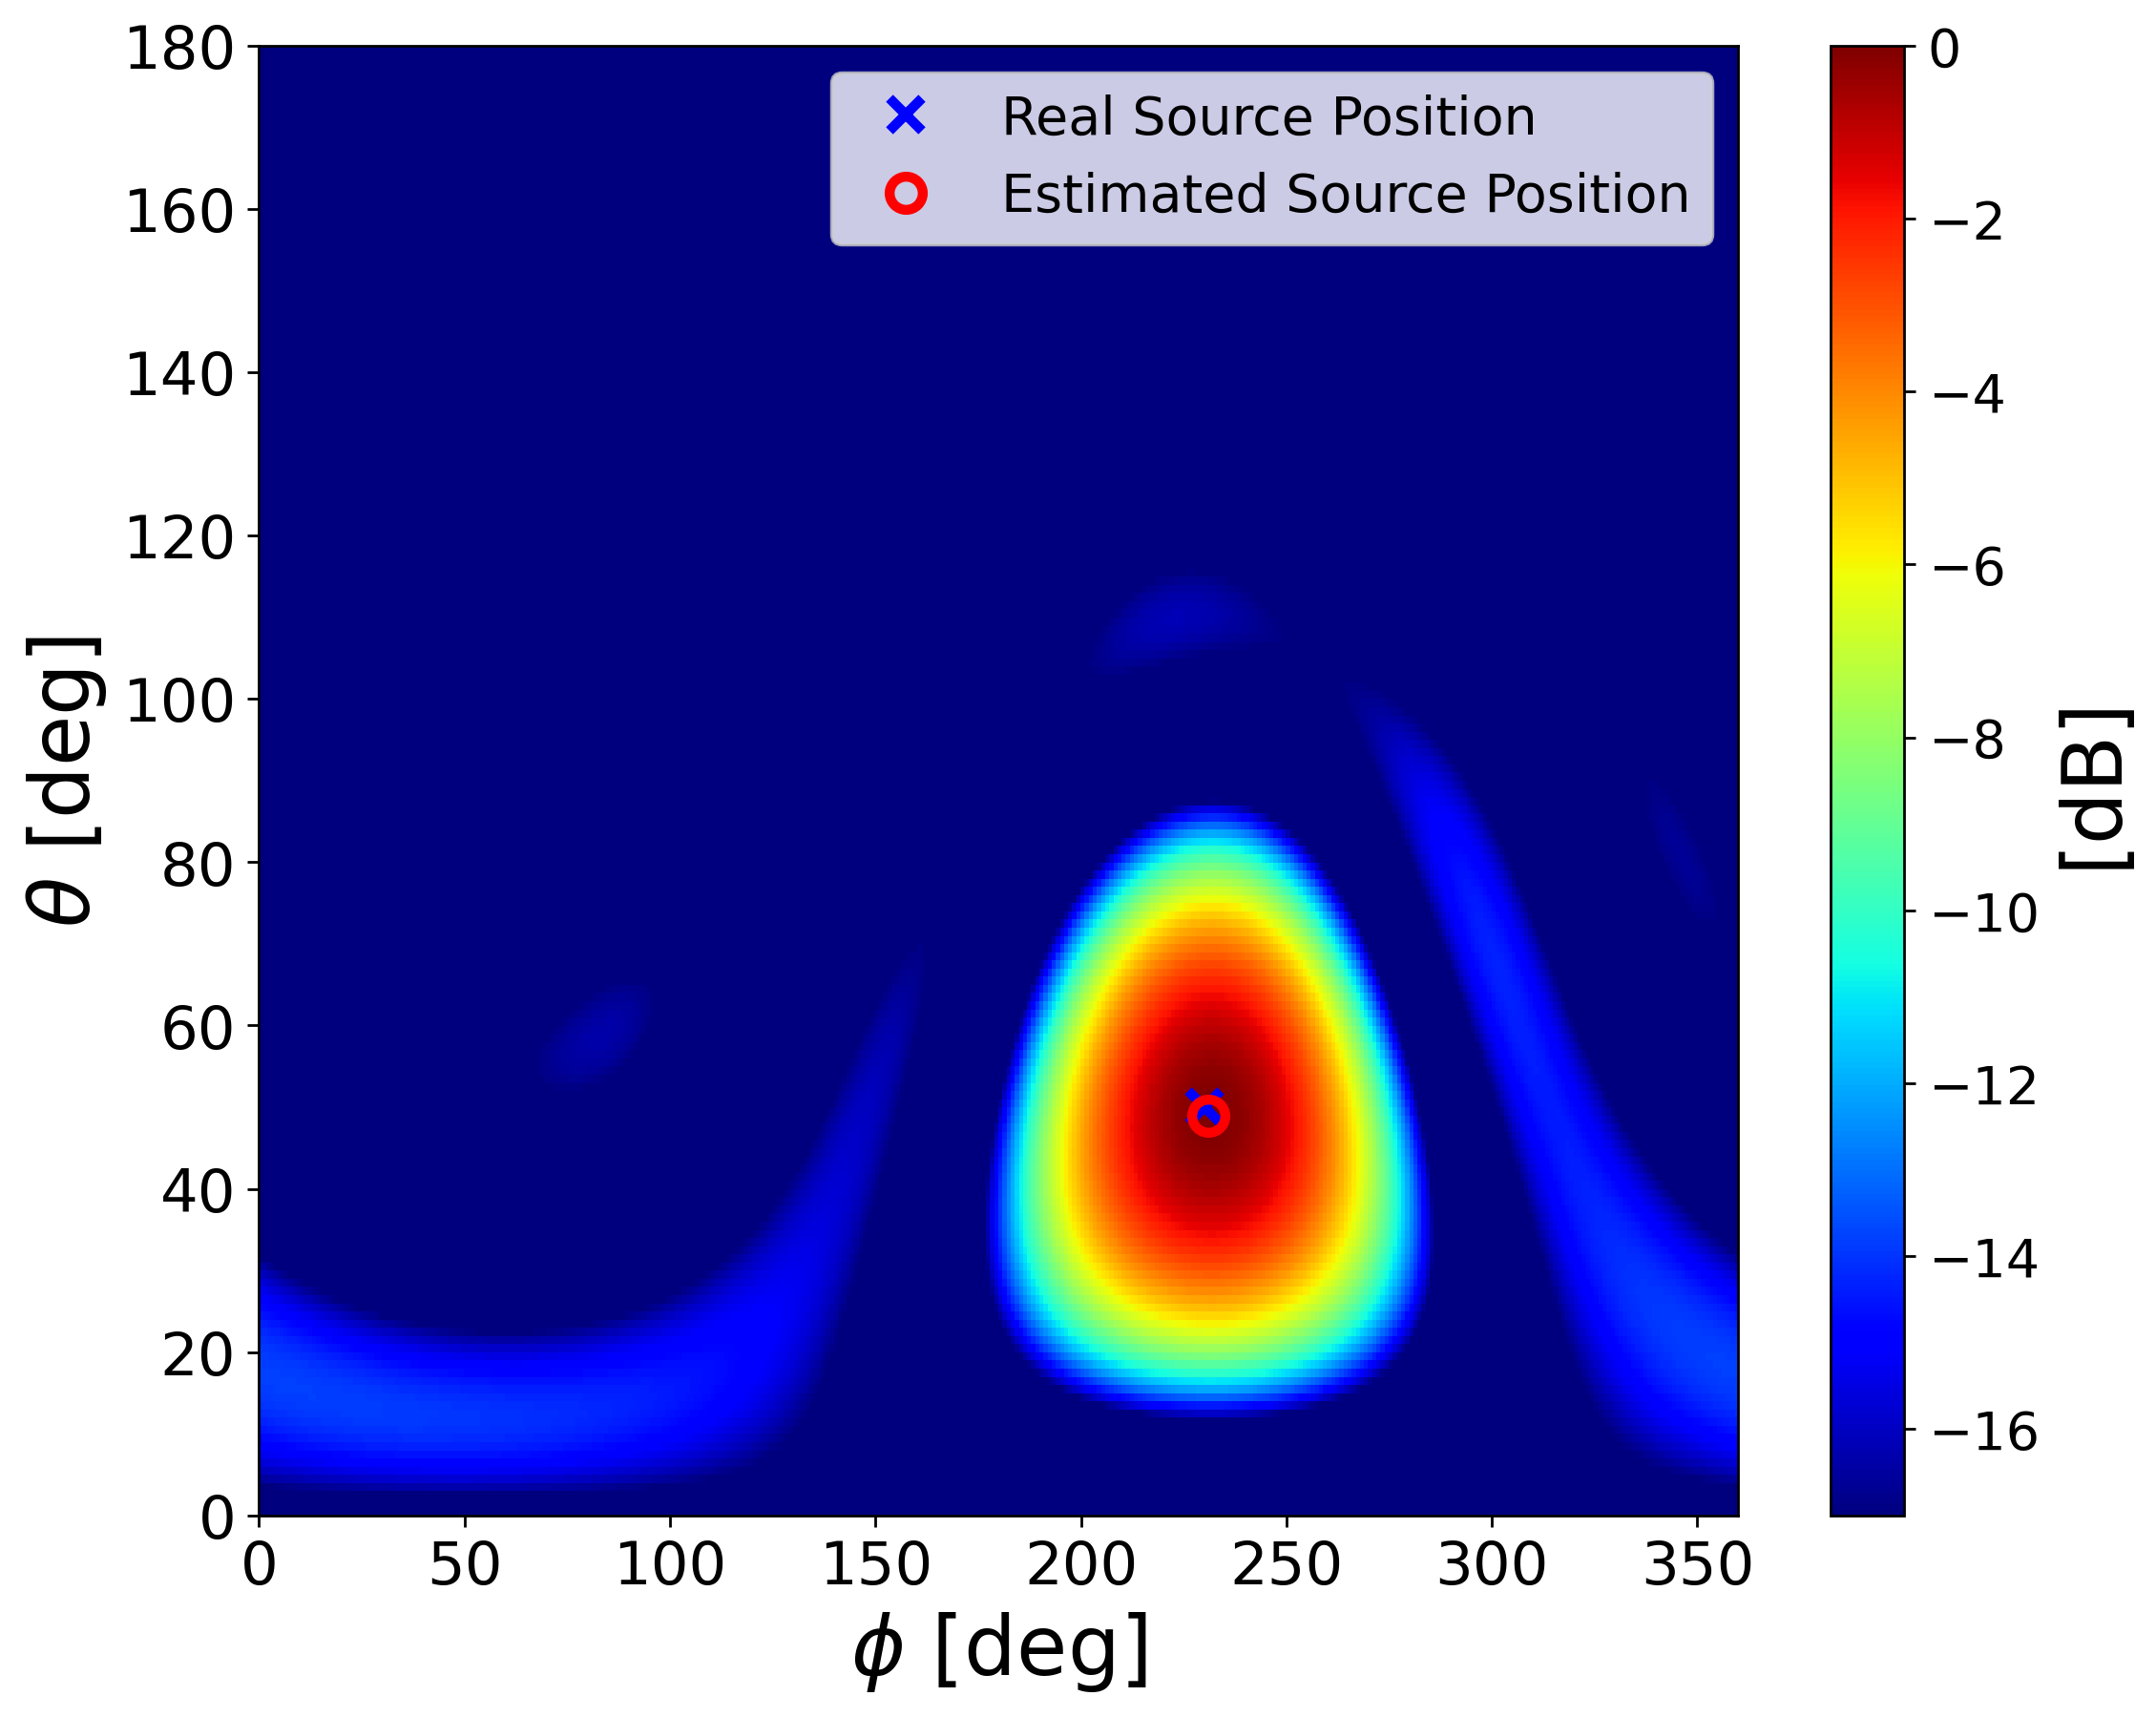

In [8]:
out_das_rigid, est_das_rigid = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "DAS", "rigid", "2D")

#### 平面波分解(Plane Wave Decomposition)
之后，如果考虑波束成形权重为单位幅值，也就是$d_n = 1$， 那么此时的等式就写为：
\begin{equation} 
y = \sum_{n=0}^{N}\sum_{m=-n}^{n}[w_{nm}(k)]^*p_{nm}(k,r) = \sum_{n=0}^{N}\sum_{m=-n}^{n}a_{nm}(k)Y_n^m(\theta_l,\phi_l) \approx a(k,\theta_l,\phi_l)    \tag{35}
\end{equation} 
所以对应的单频PWD算法的代价函数为:
\begin{equation}
J_{PWD}(\Psi) = 20log_{10}|\boldsymbol{y}(\Psi)^T \boldsymbol{a}_{\boldsymbol{nm}}(k)|
\end{equation}
这里的约等于符号随着$N$ 趋近于$\infty$ 变为等号，这个结果表面，阵列输出$y$ 作为观察方向的函数，近似于平面波振幅密度函数，所以在这种情况下，阵列测量的声场可以用平面波分量来表示，所以这里是“平面波分解”波束成形器。


通过下面结果可以看到PWD算法在open-sphere的情况下没有办法做到定位，这是因为其的loss function中含有一步对辐射函数$b_n(kr)$ 做除法，而因为球Hankel 函数会在open-sphere结构下在一些频率处呈现零点问题。而rigid-sphere结构可以通过引入散射从而克服这些问题。幅值结果如下图所示：

![Alt text](image-2.png)

细节可以查看：
[Sound-field analysis by plane-wave decomposition using spherical microphone array](https://scholar.google.com/citations?view_op=view_citation&hl=zh-CN&user=88DYI5cAAAAJ&citation_for_view=88DYI5cAAAAJ:9yKSN-GCB0IC)

[High-resolution plane-wave decomposition in an auditorium using a dual-radius scanning spherical microphone array](https://scholar.google.com/citations?view_op=view_citation&hl=zh-CN&user=88DYI5cAAAAJ&cstart=20&pagesize=80&citation_for_view=88DYI5cAAAAJ:WF5omc3nYNoC)


source_pos: [[123]
 [306]]


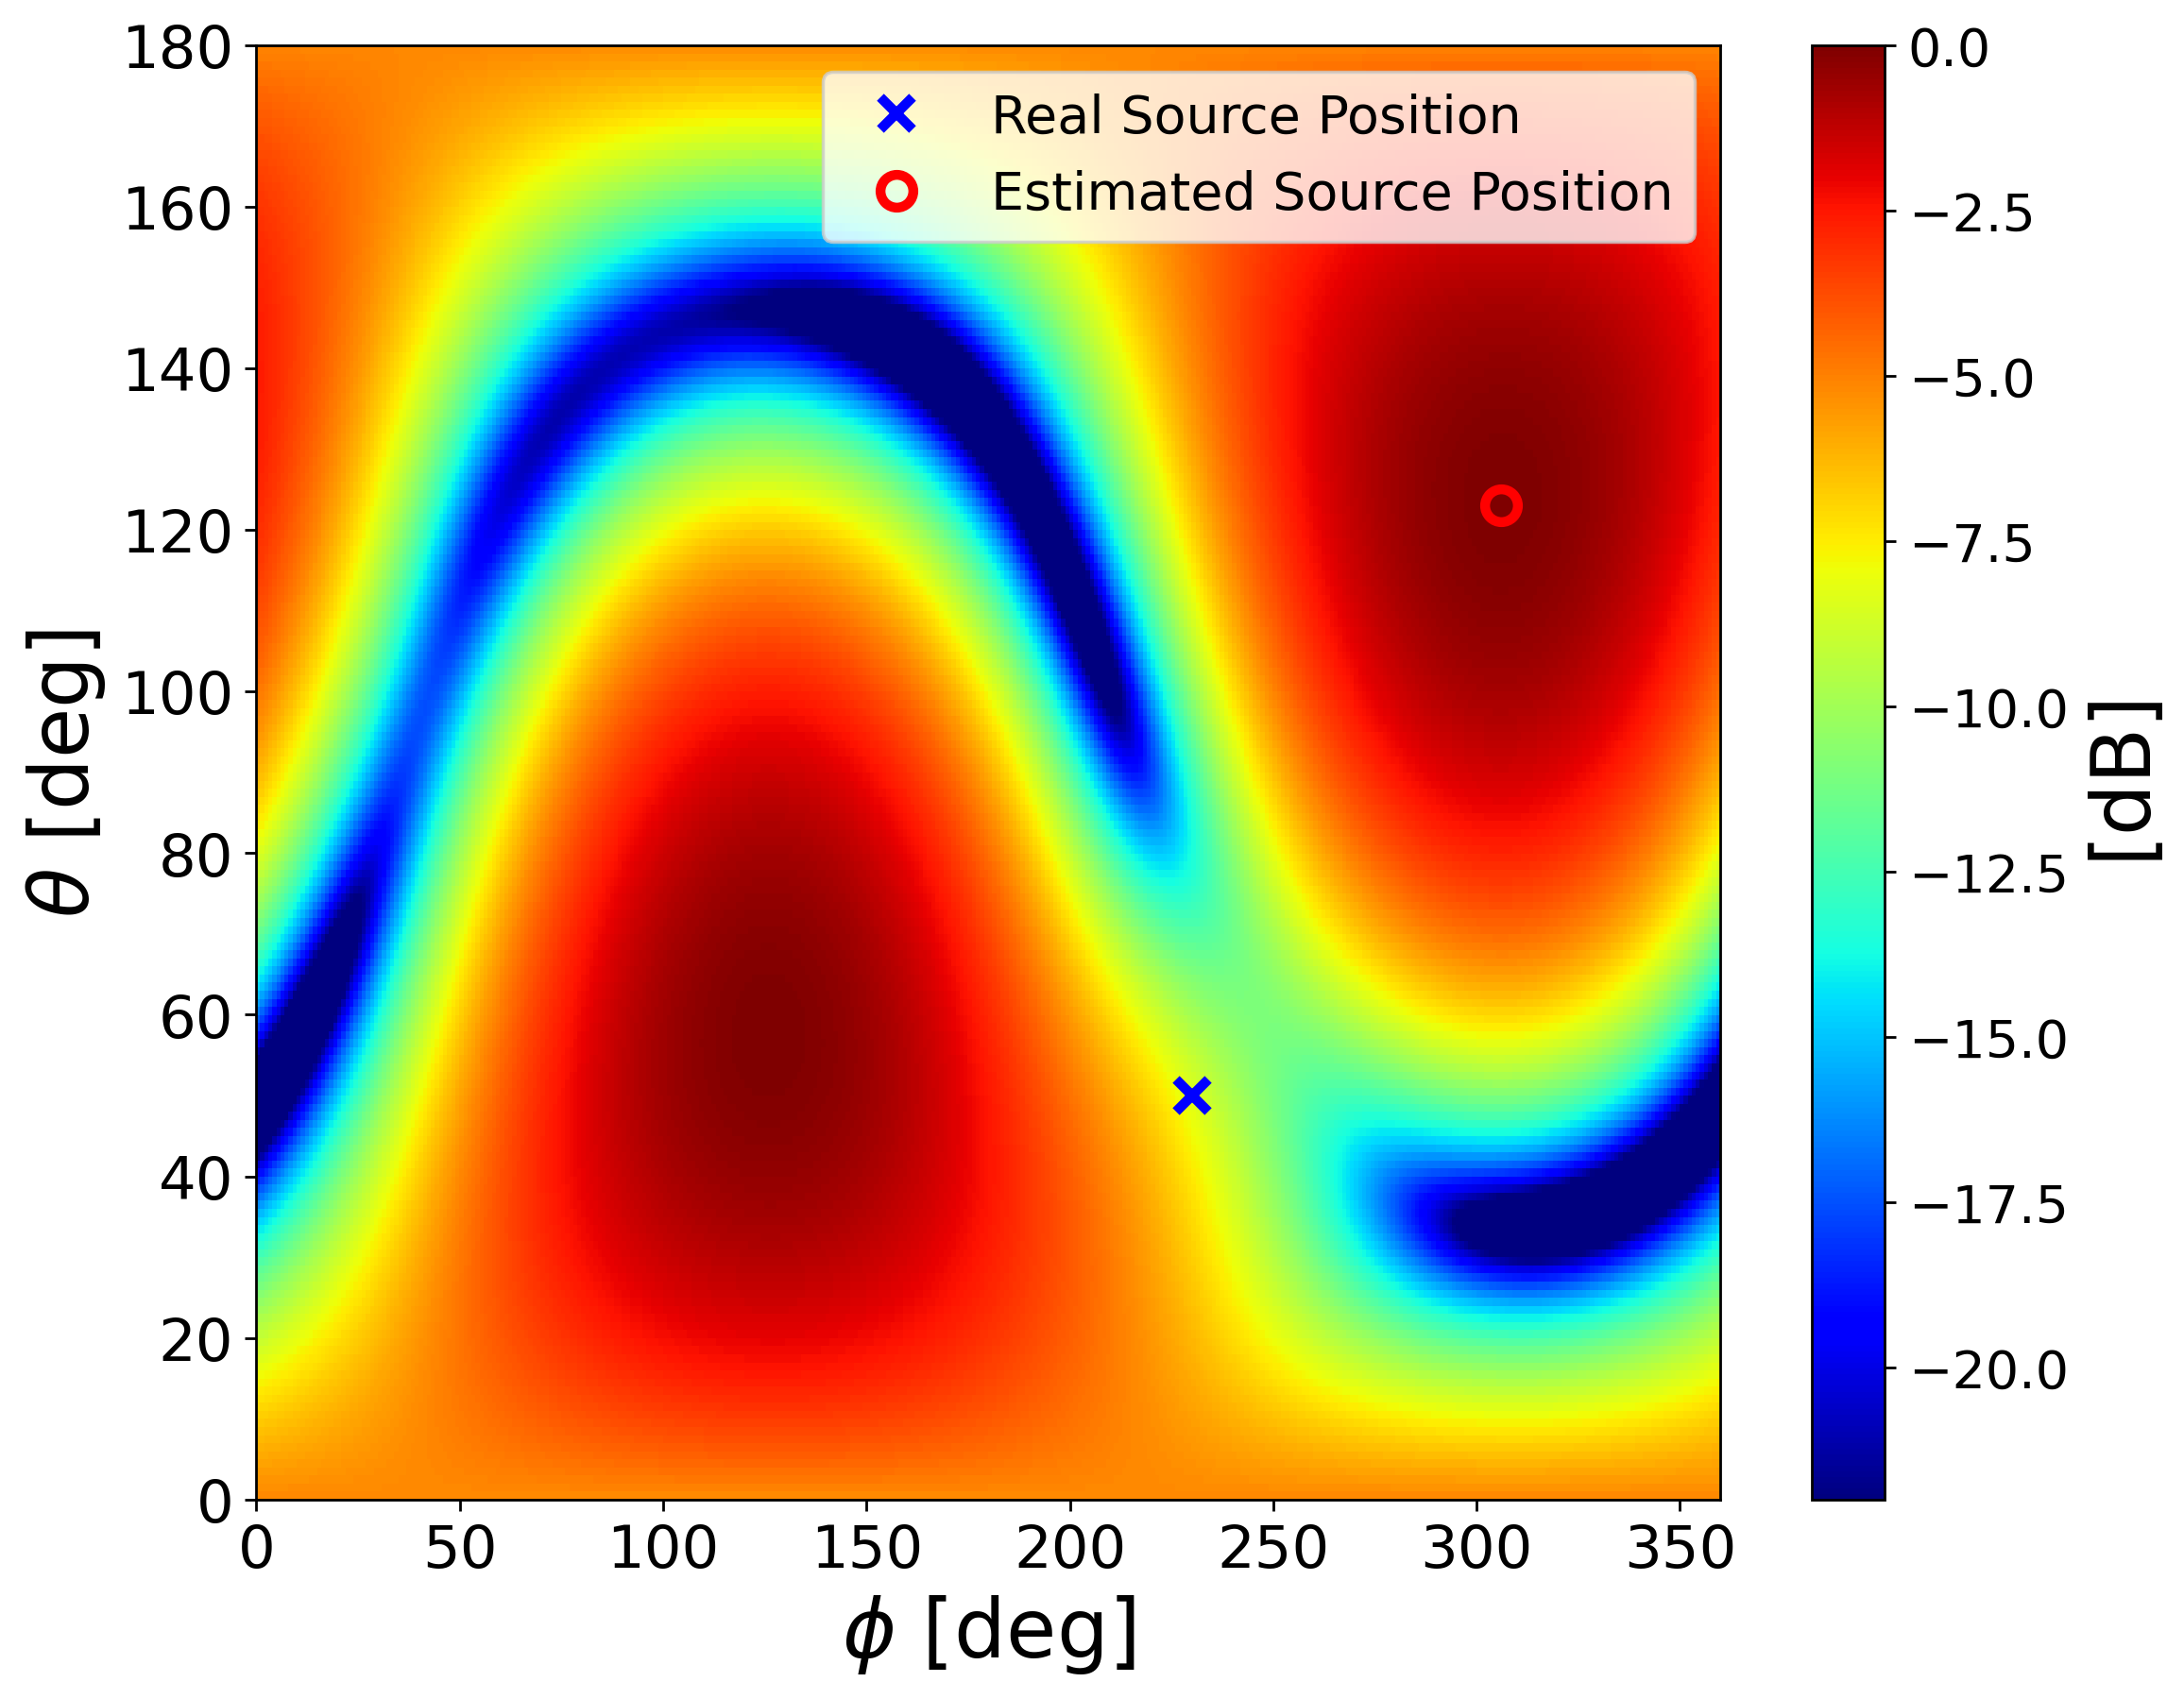

In [9]:
out_pwd_open, est_pwd_open = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "PWD", "open", "2D")


source_pos: [[ 48]
 [231]]


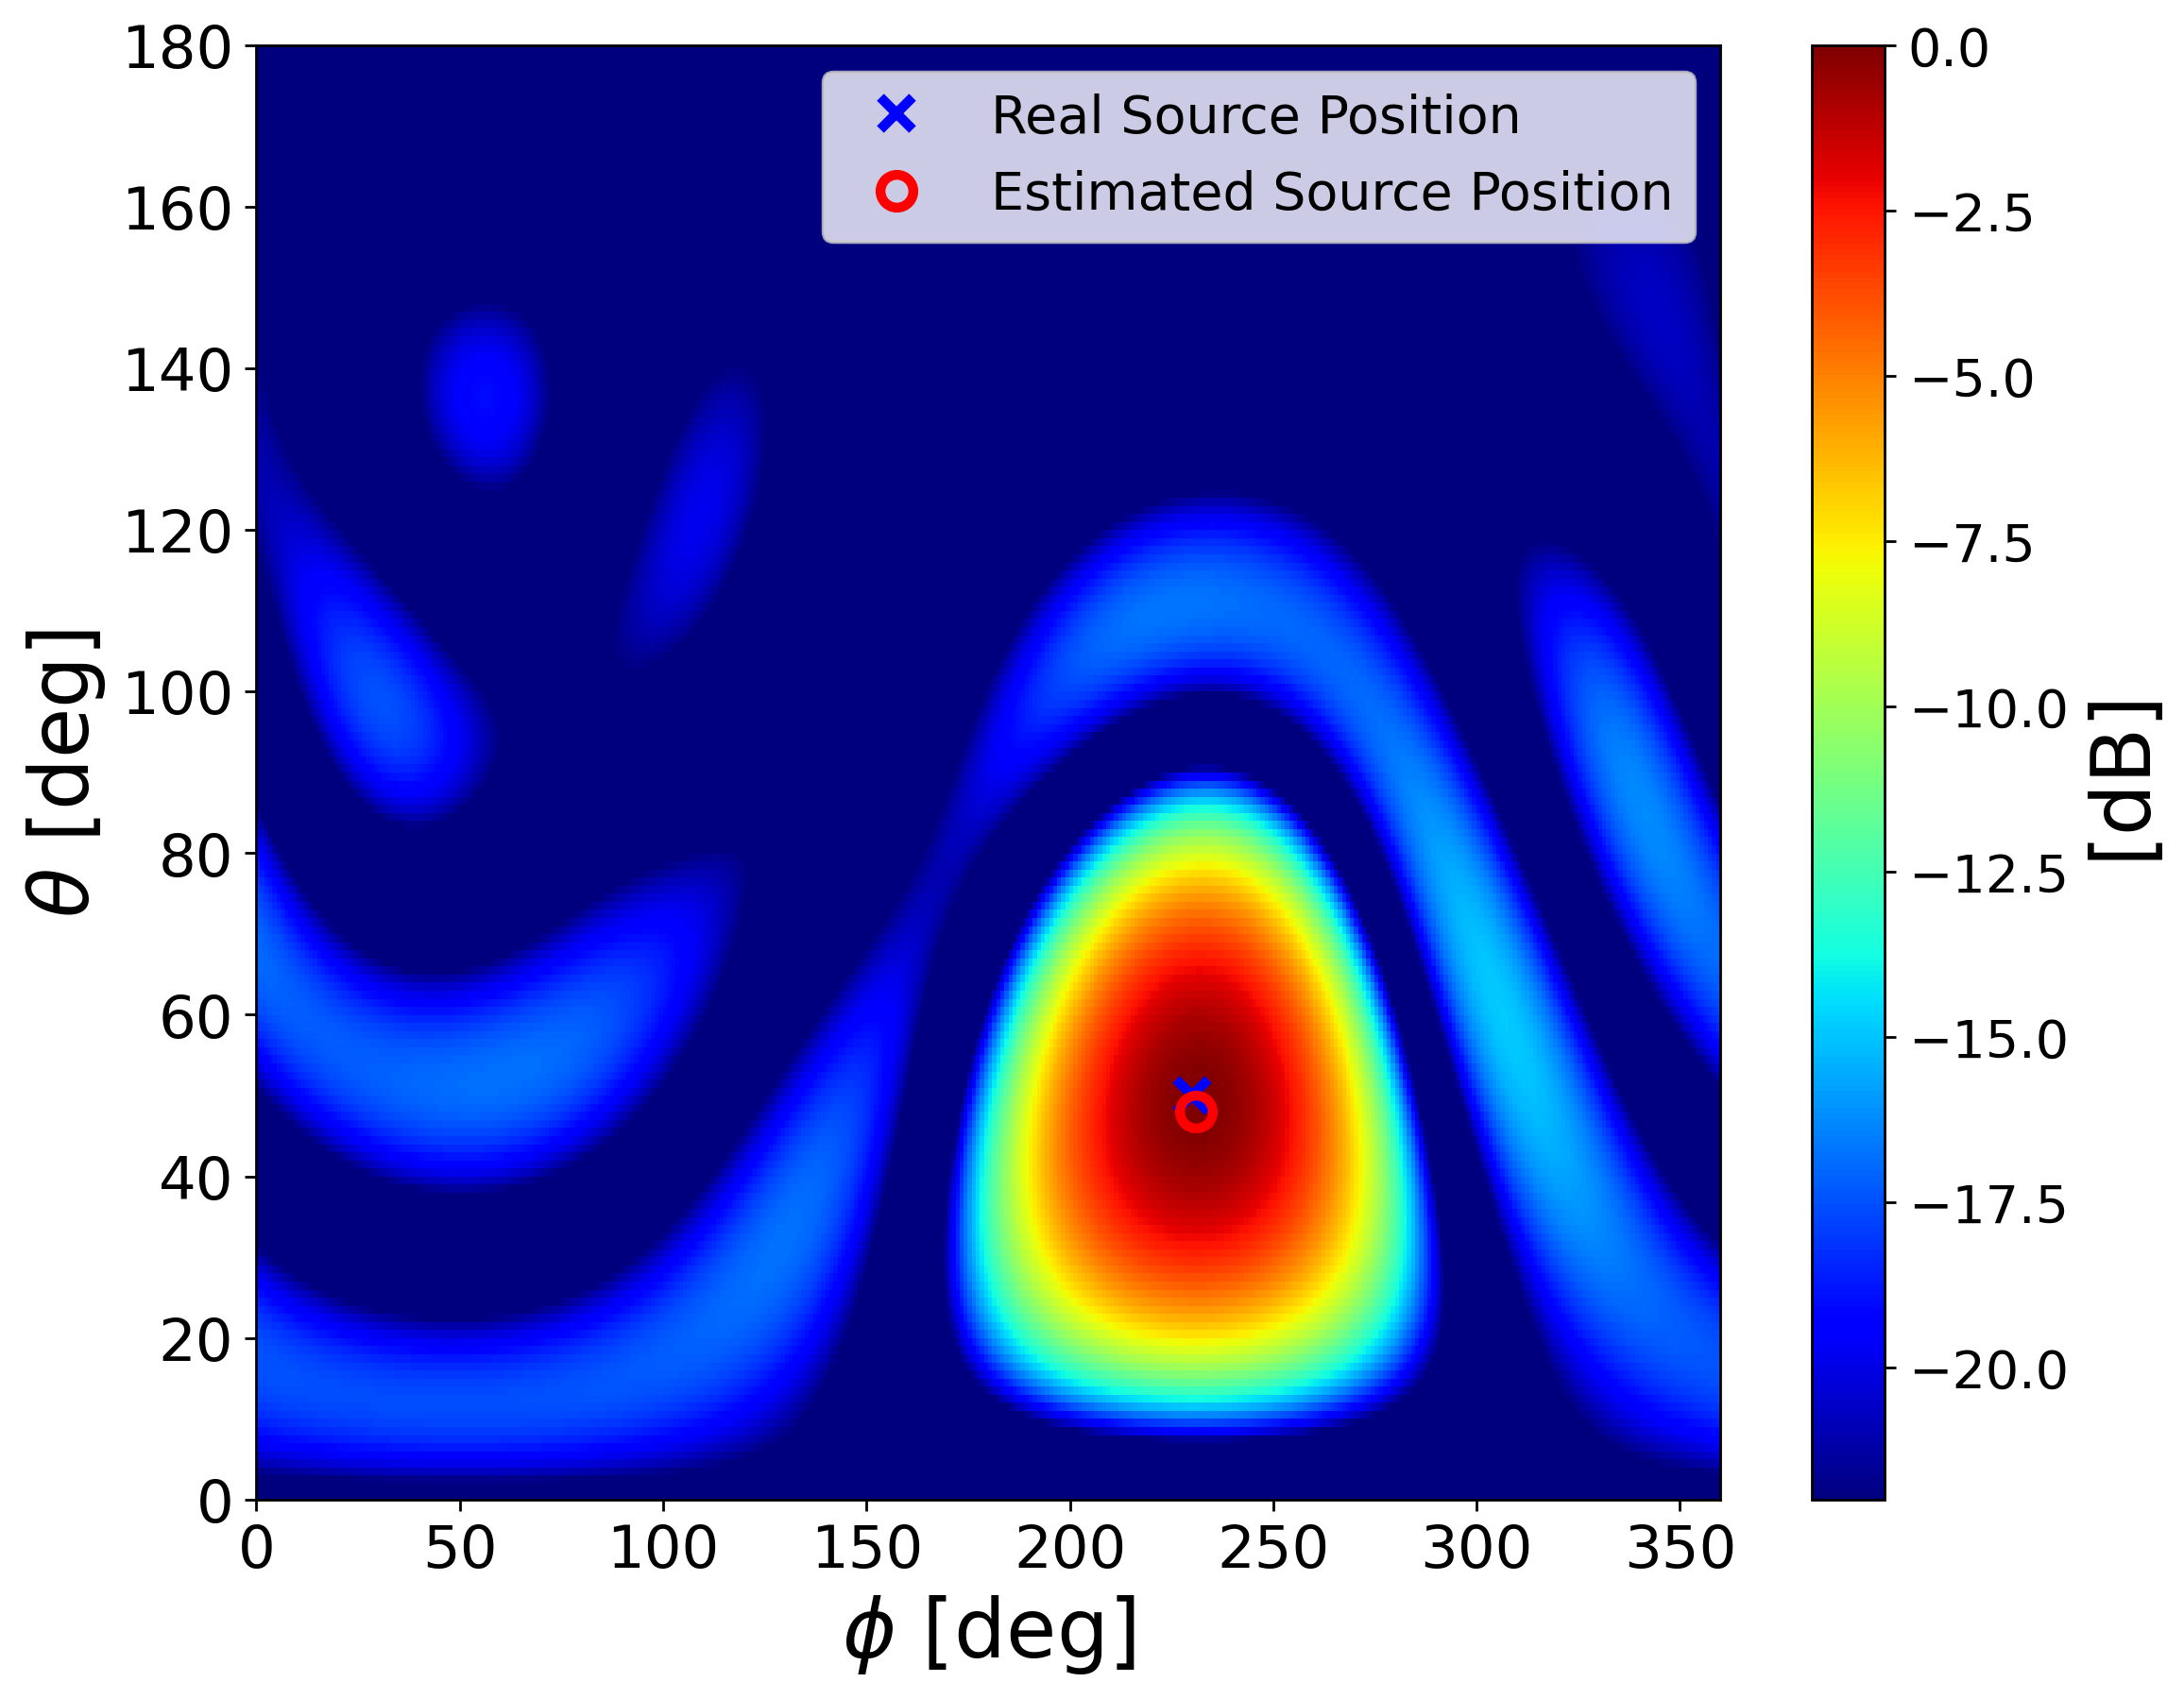

In [10]:
out_pwd_rigid, est_pwd_rigid = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "PWD", "rigid", "2D")

#### 最小方差无失真响应(MVDR)
其核心原理在于在噪声环境下，波束方向图被限制为在观测方向上保持一致，同时最小化阵列输出的方差。当所需信号是从阵列观察方向到达的平面波，并且对阵列输出的所有其他贡献被视为噪声并因此被最小化时，这个波束形成器就很有用，MVDR通过自适应地调整阵列权重来实现这一点，优化权重以抑制来自非期望方向的信号，同时不影响或扭曲来自期望方向的信号。

考虑一个所需信号$s(k)$， 源来自方向$(\theta_l, \phi_l)$ ，导向矢量$\boldsymbol{v}$ 表示从源$s(k)$ 到达阵列输入的传递函数。同时此时也有噪声输入阵列，那么阵列的输入就可以写成：
\begin{equation}
\boldsymbol{x} = \boldsymbol{p} + \boldsymbol{n} = \boldsymbol{v} s + \boldsymbol{n}    \tag{36}
\end{equation}

这里为了简化，消除了信号幅值$s(k)$ 对频率$k$的依赖。

那么我们就可以得到阵列输出信号的方差的表达形式：

\begin{equation}
E[|y|^2] = \boldsymbol{w}^H \boldsymbol{S}_{\boldsymbol{xx}} \boldsymbol{w} = \boldsymbol{w}^H \boldsymbol{S}_{\boldsymbol{pp}}\boldsymbol{w} + \boldsymbol{w}^H \boldsymbol{S}_{\boldsymbol{nn}} \boldsymbol{w} = |\boldsymbol{w}^H \boldsymbol{v}|^2 E[|s|^2] + \boldsymbol{w}^H \boldsymbol{S}_{\boldsymbol{nn}} \boldsymbol{w}   \tag{37}
\end{equation}

之后我们就可以把我们的限制条件用数学表示出来：
\begin{align}
& \text{minimize} \quad \boldsymbol{w}^H\boldsymbol{S}_{\boldsymbol{xx}}\boldsymbol{w}  \tag{38} \\      \tag{39}
& \text{subject to} \quad \boldsymbol{w}^H \boldsymbol{v} = 1
\end{align}

可以看到，因为我们的优化目标是，无失真响应约束，那么$\boldsymbol{w}^H \boldsymbol{v} = 1$ , 而不能对信号的自相关部分$\boldsymbol{S}_{\boldsymbol{xx}}$做出修改，所以我们知道对$\boldsymbol{w}^H \boldsymbol{S}_{\boldsymbol{xx}}\boldsymbol{w}$ 的最小化会导致 $\boldsymbol{w}^H \boldsymbol{S}_{\boldsymbol{nn}}\boldsymbol{w}$的最小化，即阵列输出处噪声的方差最小化。所以这也就对应了我们之前提及的原理：这种优化的结果是将所需信号不变地传送到阵列输出，同时最大限度地减少噪声的贡献。而上面的约束方程可以用拉格朗日乘子法转换为下面的形式：
\begin{equation}
\boldsymbol{w}^H = \frac{\boldsymbol{v}^H \boldsymbol{S}_{\boldsymbol{xx}}^{-1}}{\boldsymbol{v}^H \boldsymbol{S}_{\boldsymbol{xx}}^{-1} \boldsymbol{v}}   \tag{40}
\end{equation}

但是这里看到，我们想要求得最优的波束成形系数，那么就需要得到矩阵$\boldsymbol{S}_{\boldsymbol{xx}}$ 的逆，所以就要求矩阵必须是满秩的，而其中关键就在于需要$\boldsymbol{S}_{nn}$是满秩的或者近似满秩的。 

假设我们这里引入一个常见的传感器噪声，其通常是由连接到传感器的放大器引起的电噪声，假设这里的噪声信号是I.I.D.的，那么此时有噪声的互谱为：
\begin{equation}
\boldsymbol{S}_{\boldsymbol{nn}} = \sigma_n^2 \frac{4\pi}{Q} \boldsymbol{I}   \tag{41}
\end{equation}
这里的$\boldsymbol{I}$ 为一个$Q\times Q$ 的单位矩阵，$\sigma_n^2$ 为传感器噪声的方差。

那么此时的系数为：
\begin{equation}
\boldsymbol{w}_{\boldsymbol{nm}}^H = \frac{\boldsymbol{v}_{\boldsymbol{nm}}^H}{\boldsymbol{v}_{\boldsymbol{nm}^H} \boldsymbol{v}_{\boldsymbol{nm}}}   \tag{42}
\end{equation}

这个结果就是最大WNG波束形成器相同，所以此时MVDR算法的代价函数可以写为：
\begin{equation}
J_{MVDR} = 20log_{10}|\boldsymbol{w}_{nm}^T \boldsymbol{R}_{\boldsymbol{p}_{nm}}\boldsymbol{w}_{nm}|
\end{equation}

source_pos: [[ 49]
 [231]]


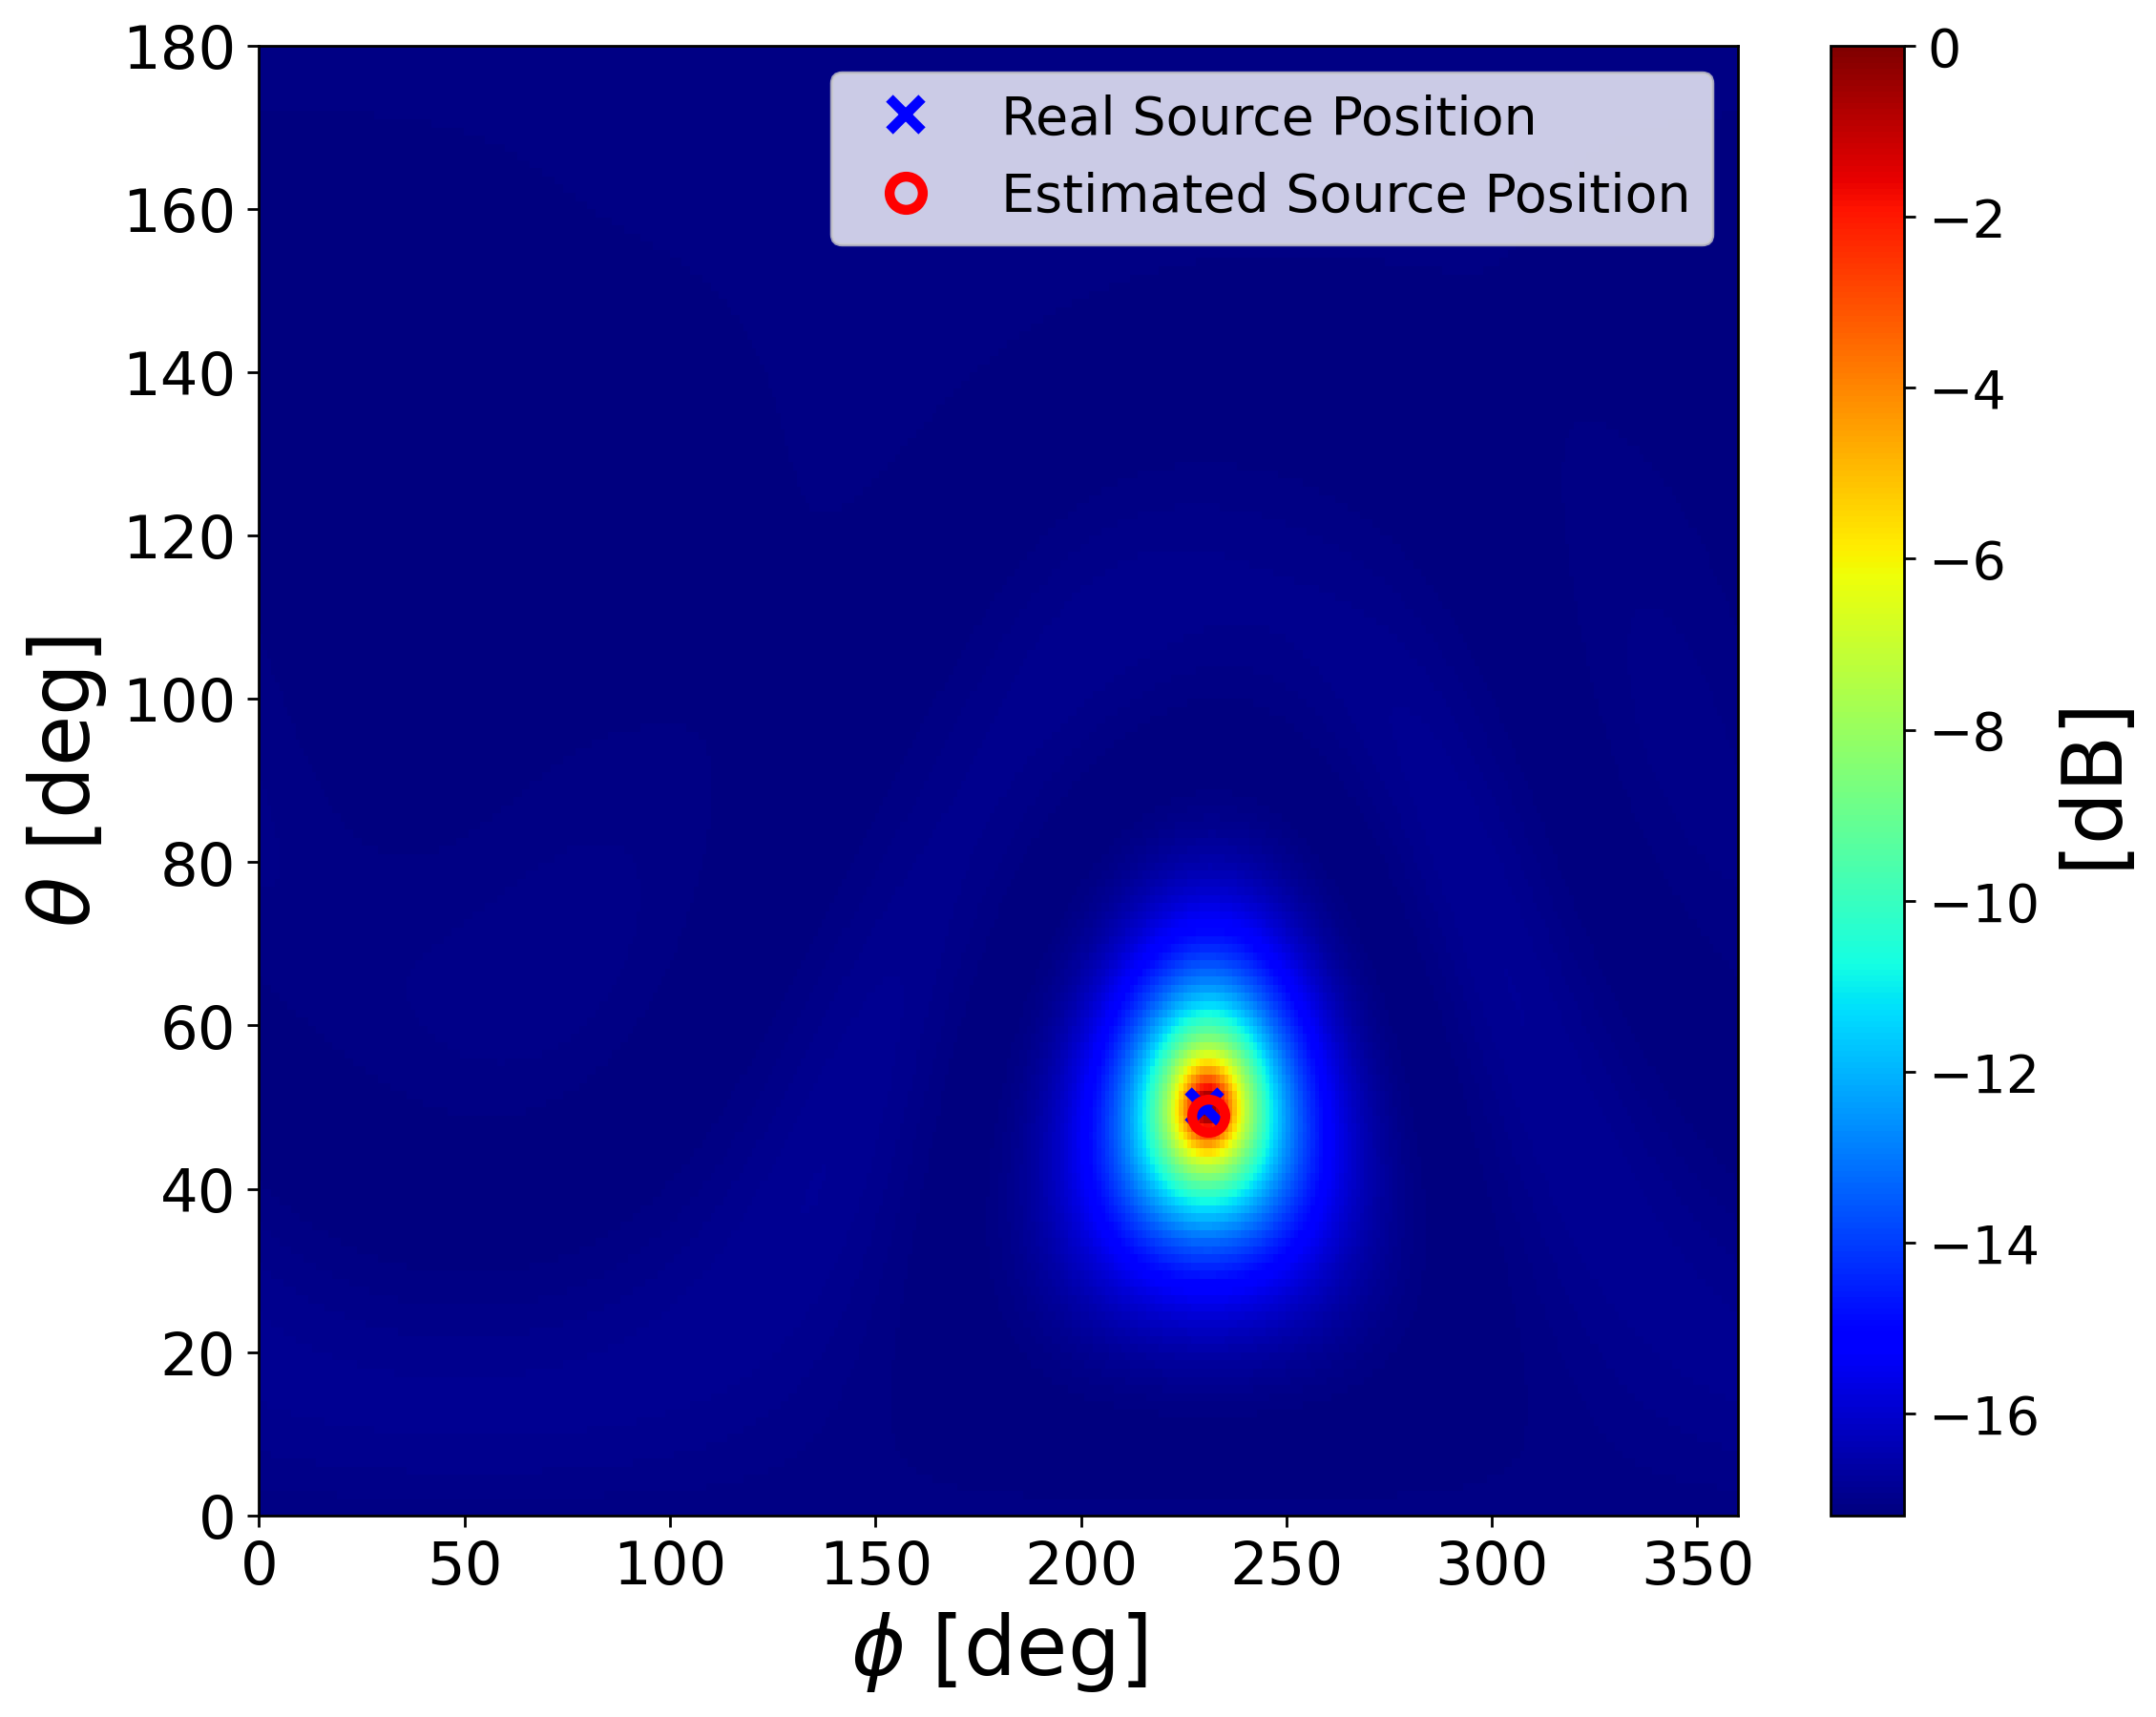

In [11]:
out_mvdr_open, est_mvdr_open = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "SHMVDR", "open", "2D")

source_pos: [[ 48]
 [231]]


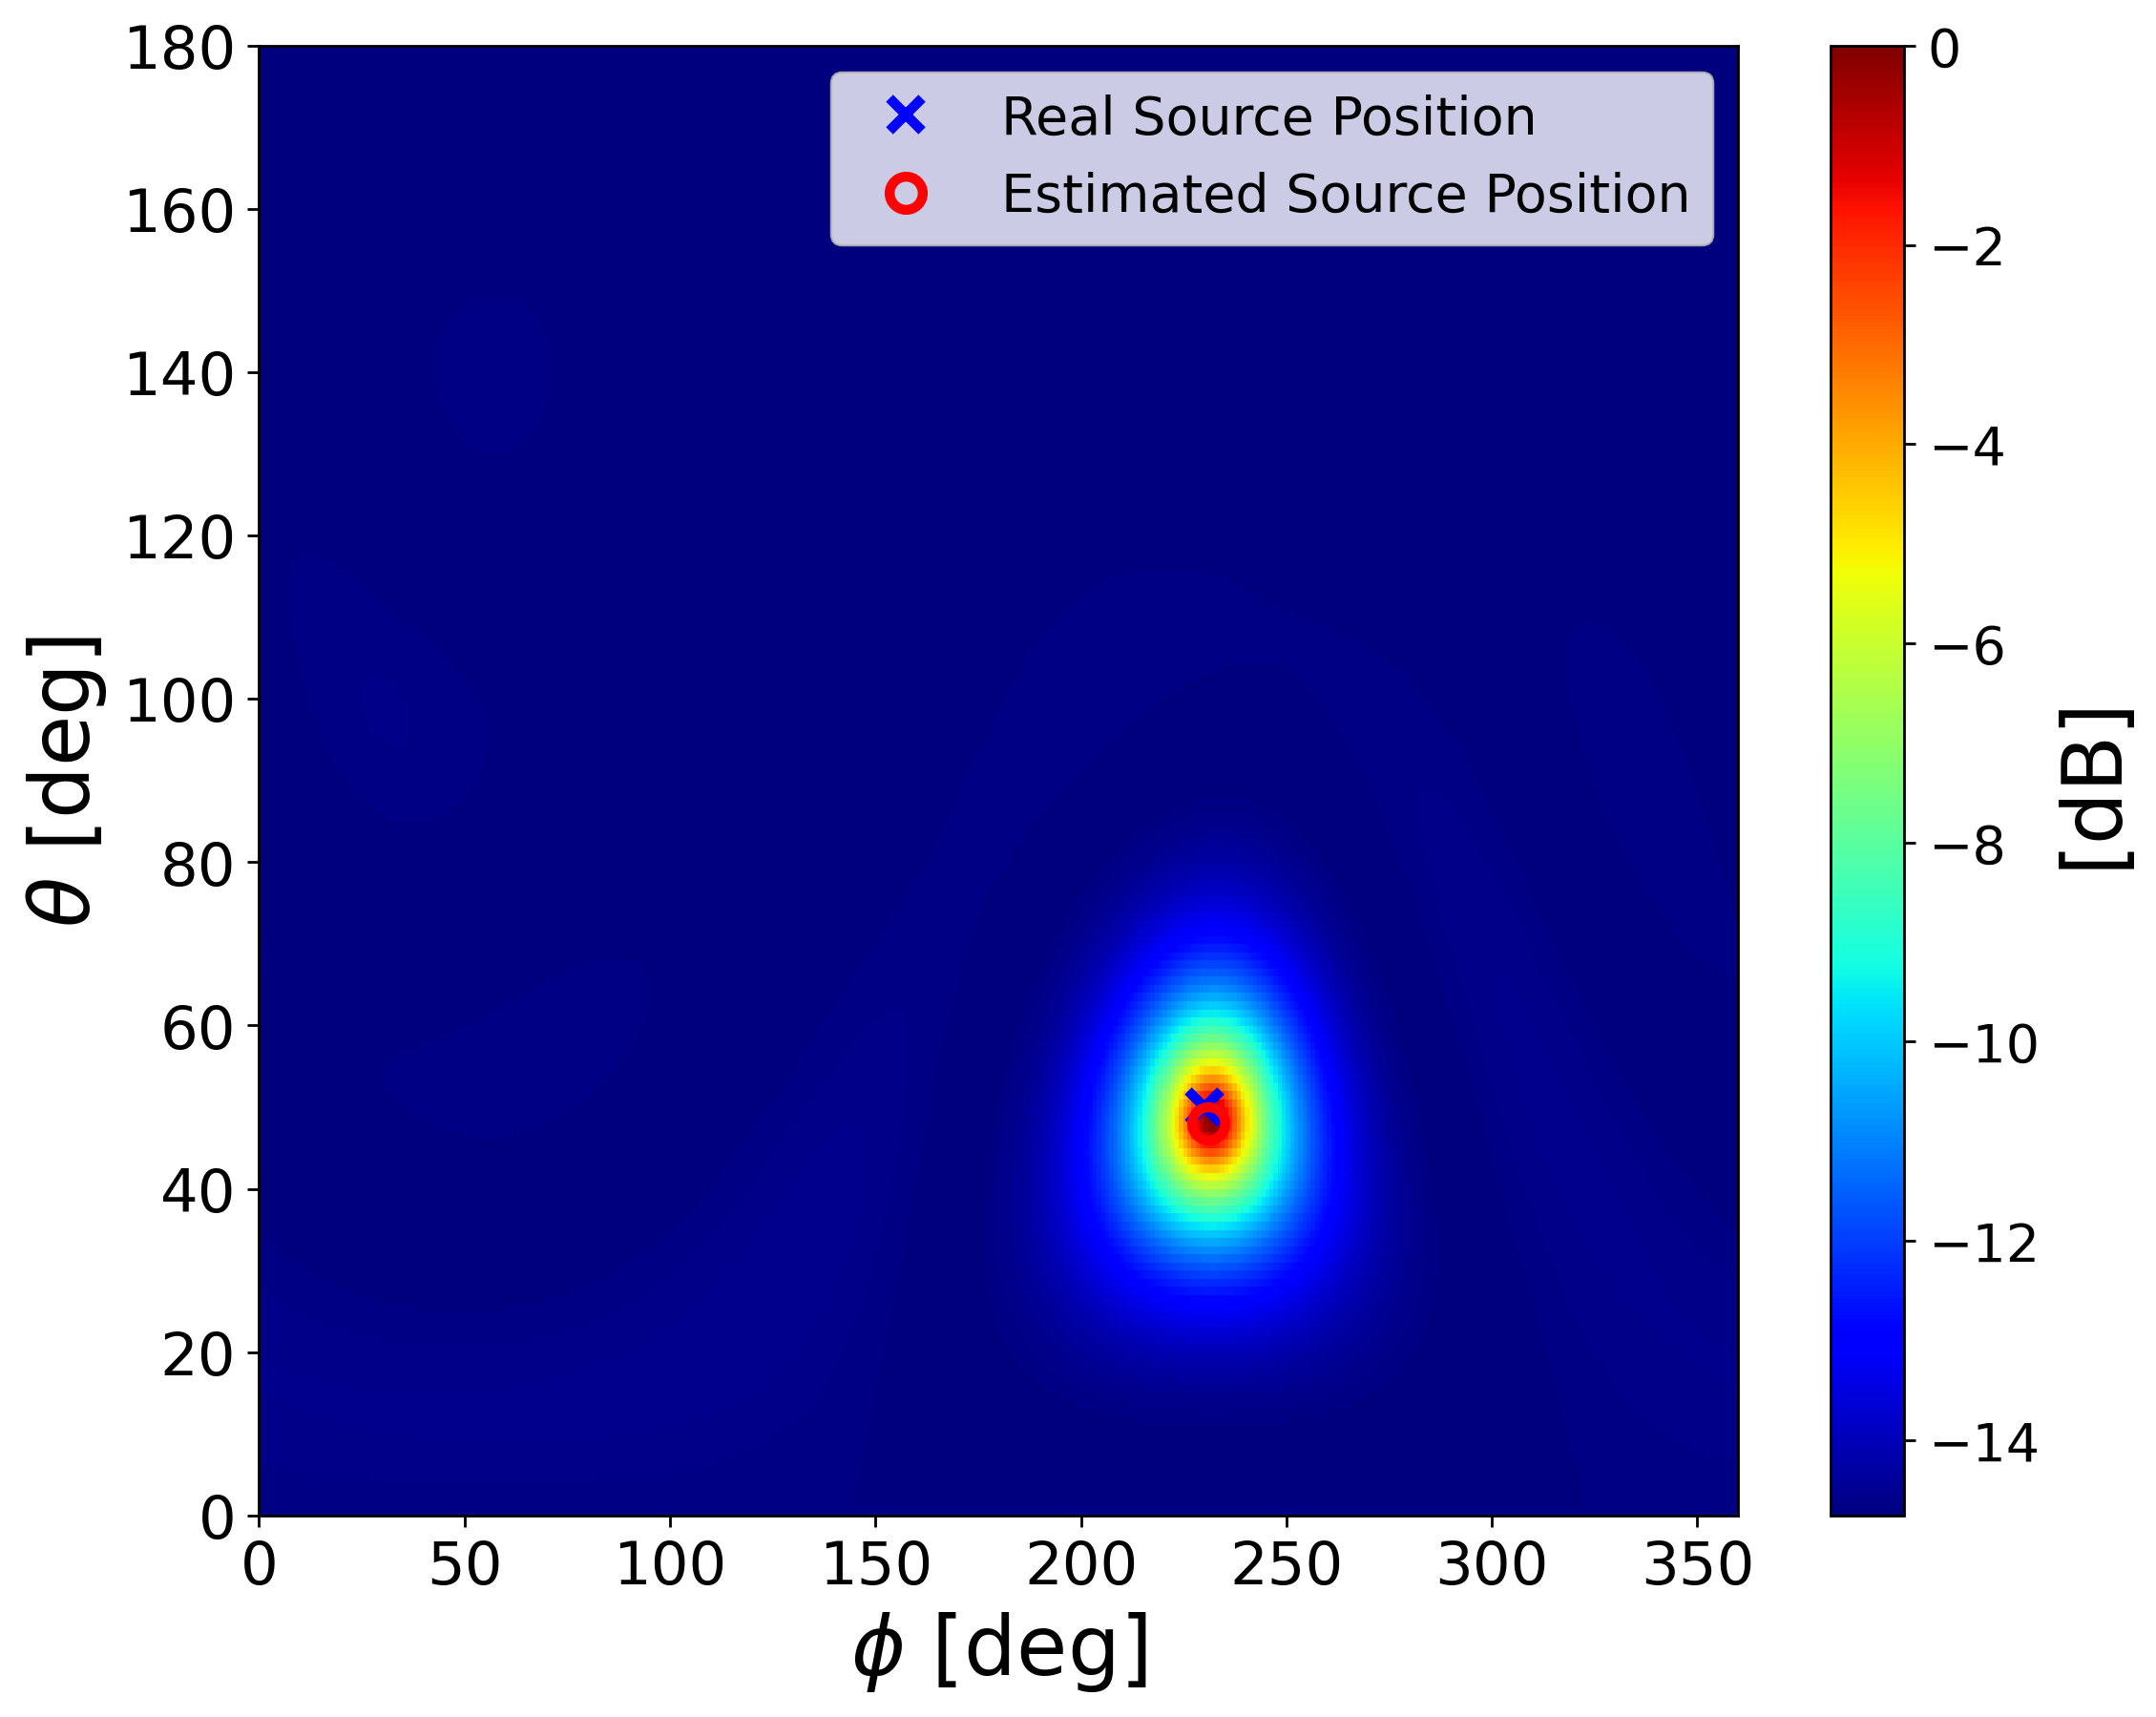

In [12]:
out_mvdr_rigid, est_mvdr_rigid = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "SHMVDR", "rigid", "2D")

#### MUSIC算法
MUSIC算法的核心原理主要是在于信号子空间和噪声子空间的正交性，可以通过对接收信号的协方差进行特征提取，利用特征向量得到正交的信号子空间和噪声子空间。其优点在于其能够提高较高的空间分辨率，但是其有一个问题在于，他对于较差环境的鲁棒性较差，并且需要事先知道声源数目作为先验条件。
其步骤主要如下：
<ul>
  <li>通过将接收到的信号矢量取时间平均值计算协方差矩阵。</li>
  <li>计算协方差矩阵的特征值和特征向量，信号子空间由与最大特征值相关的特征向量组成，而噪声子空间由剩余的特征向量张成。</li>
  <li>谱峰搜索，构造一个搜索函数，其在所有可能的方向点上与噪声子空间的特征向量正交。在信号方向上，这个函数会有明显的峰值，因为信号方向与噪声子空间是最正交的。</li>
</ul>

所以上述步骤在球谐域通过公式可以表示为：

1.接收信号的协方差矩阵：
\begin{equation}
\boldsymbol{R}_{\boldsymbol{p}_{nm}}  = E[\boldsymbol{p}_{nm} \boldsymbol{p}_{nm}^H]  \tag{42}
\end{equation}

2. 特征分解：
\begin{equation}
[\boldsymbol{E}_a, \boldsymbol{E}_n] = eigen(\boldsymbol{R}_{\boldsymbol{p}_{nm}})   \tag{43}
\end{equation}
这里的$\boldsymbol{E}_a$ 和$\boldsymbol{E}_n$ 分别表示信号子空间和噪声子空间，然后根据先验已知的声源数量选择特征向量。

3. 谱峰搜索：
最后可以得到和MUSIC算法有关的代价函数
\begin{equation}
J_{MUSIC} = -20 log_{10}|\boldsymbol{y}(\Psi)^T \boldsymbol{E}_N \boldsymbol{E}_N^H \boldsymbol{y}^*(\Psi)| \tag{44} 
\end{equation}

从下图的结果中可以看到，当选取$ka = 4.496$ 时，也就是对应球贝塞尔零点函数的位置，open-sphere结构下的MUSIC算法和PWD算法一致，没有办法工作，而rigid-sphere结构下的PWD和MUSIC都能克服这个问题，说明了rigid-sphere的优越性，除此之外，Rafaely等还提出了dual-sphere等结构，如想要进一步了解，可以查看：

[High-resolution plane-wave decomposition in an auditorium using a dual-radius scanning spherical microphone array](https://scholar.google.com/citations?view_op=view_citation&hl=zh-CN&user=88DYI5cAAAAJ&cstart=20&pagesize=80&citation_for_view=88DYI5cAAAAJ:WF5omc3nYNoC)

关于MUSIC算法和SHMUSIC算法之间的性能对比，详情可以了解这篇文章：
[Spherical harmonics MUSIC versus conventional MUSIC](https://www.sciencedirect.com/science/article/pii/S0003682X11000521?casa_token=6OkHzwd3dyUAAAAA:A7GdInpejNWuE5epN4IBaBvn9bOsNPJpXApf3DQ9ns85j03KtqTOls7ov3-hHxc1Iw_0u1fw)

source_pos: [[69]
 [44]]


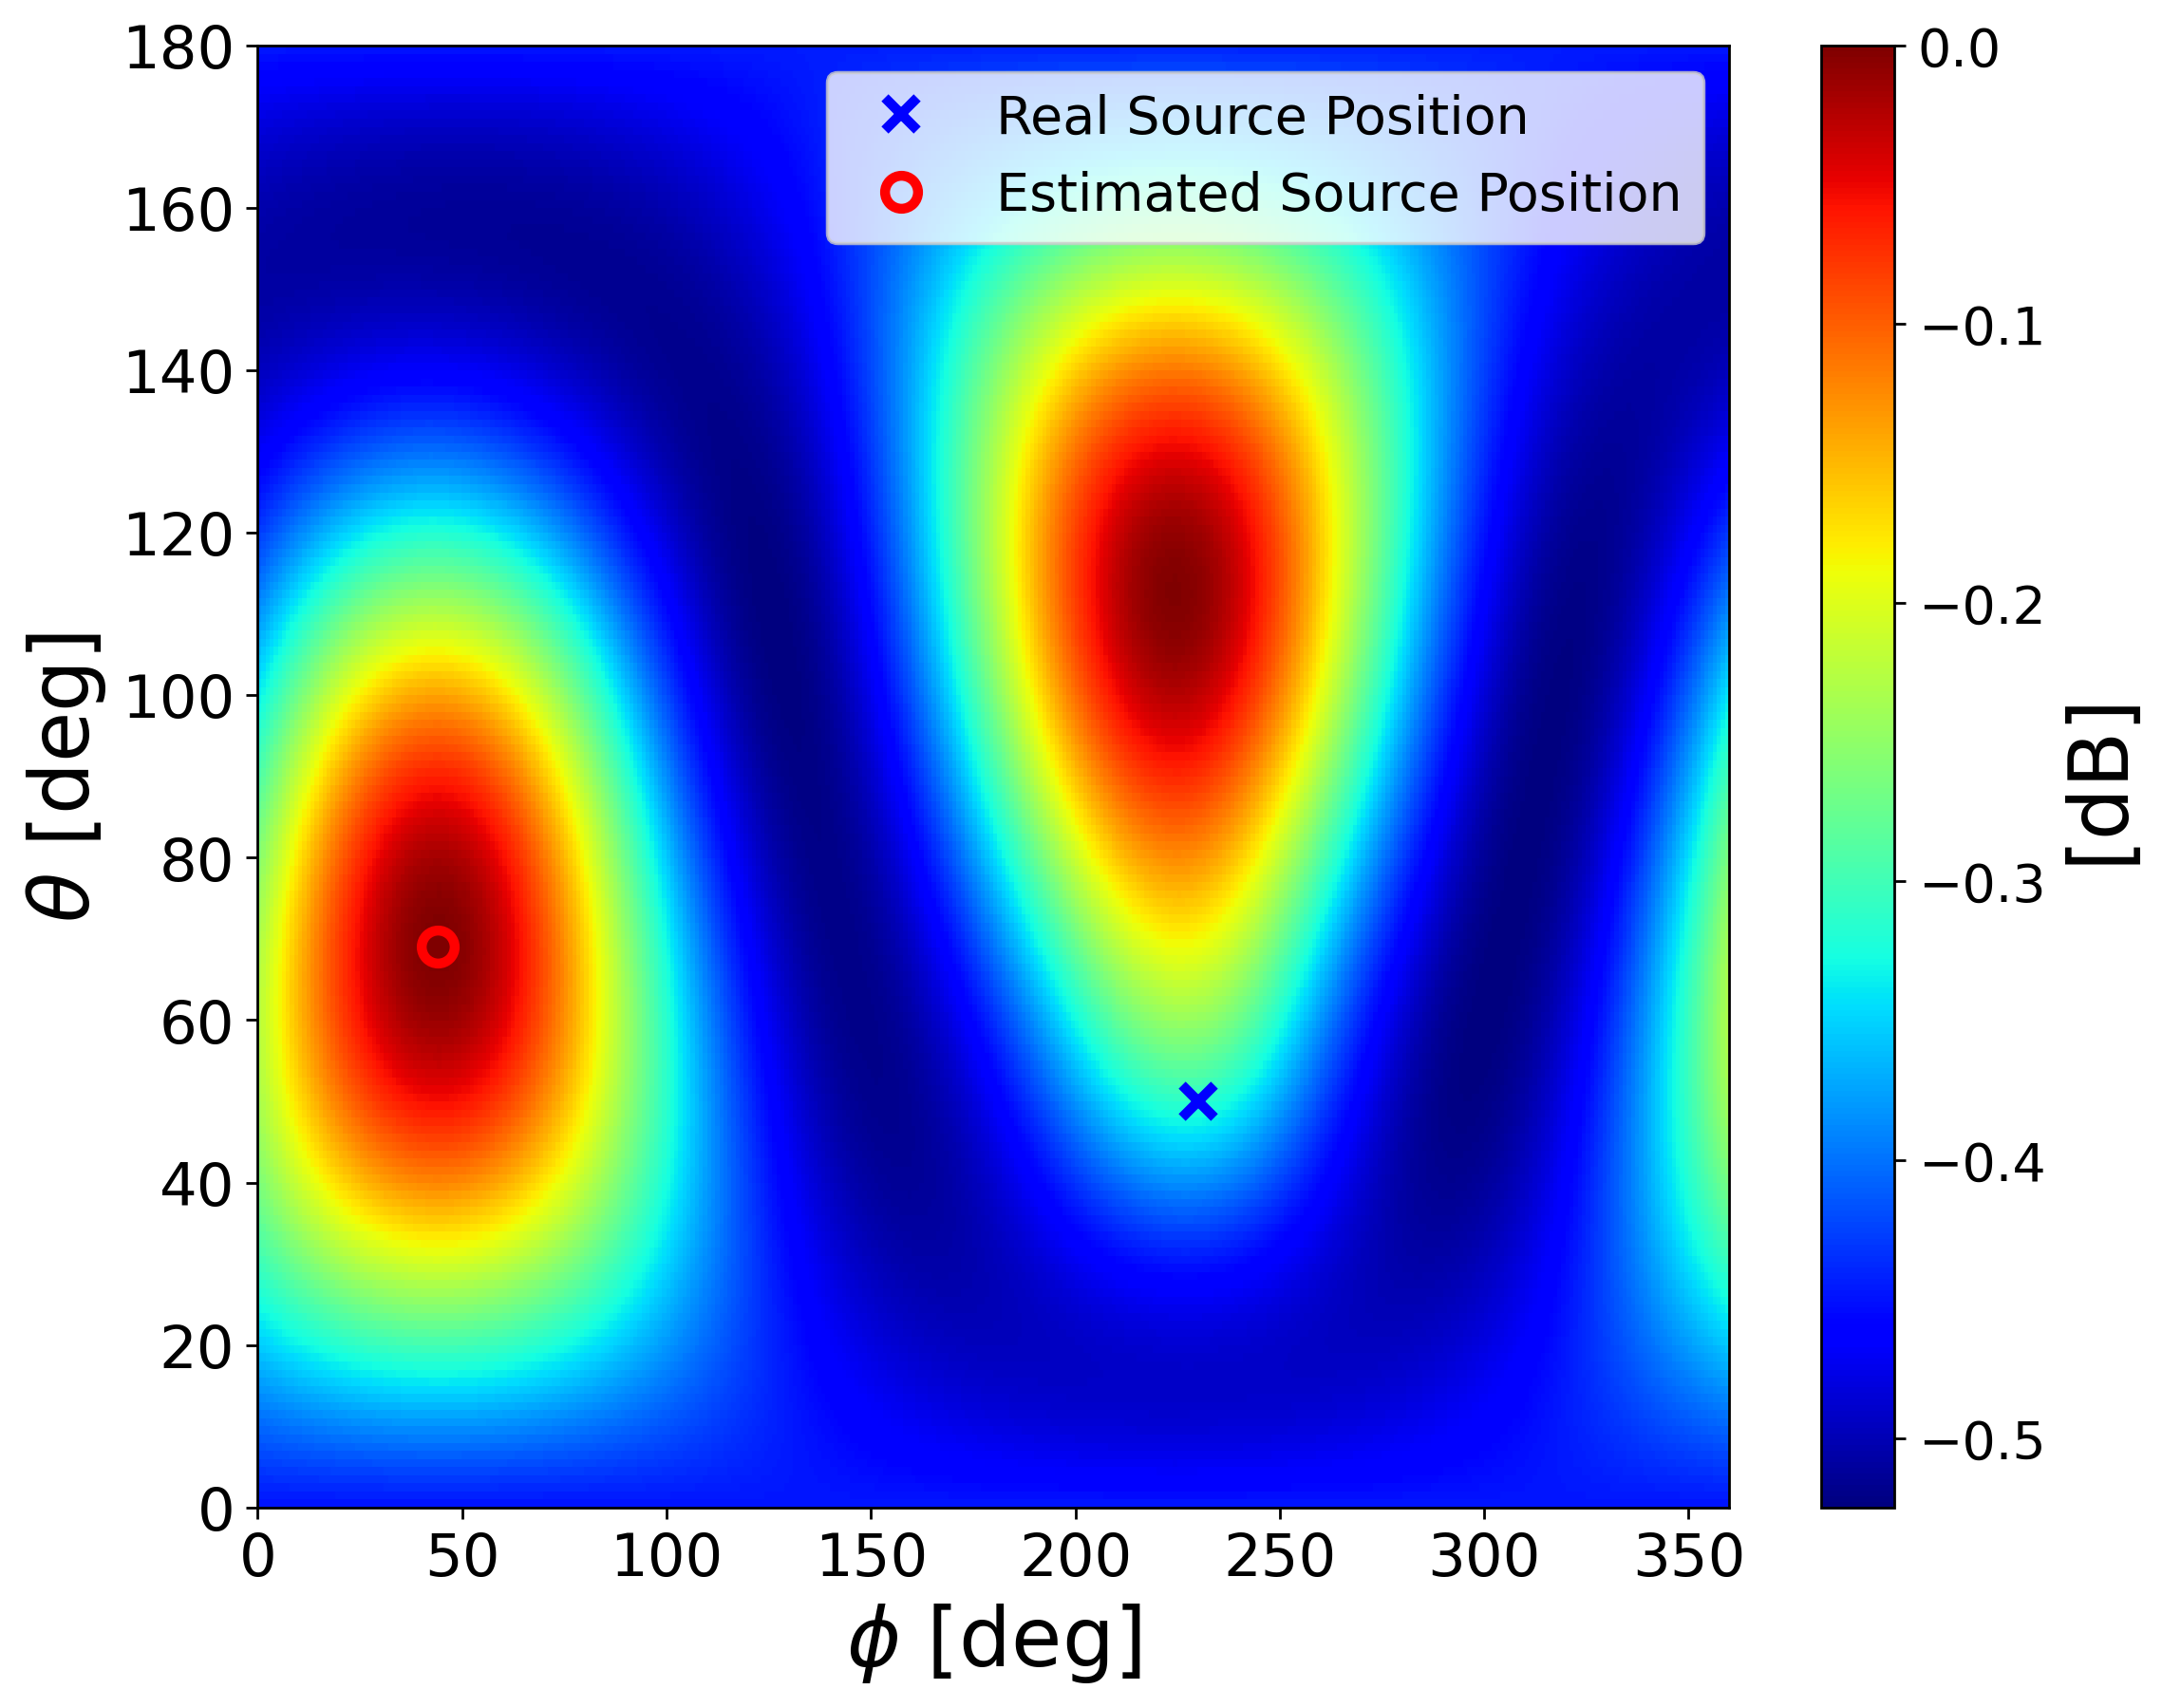

In [13]:
out_music_open, est_music_open = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "MUSIC", "open", "2D")

source_pos: [[ 48]
 [231]]


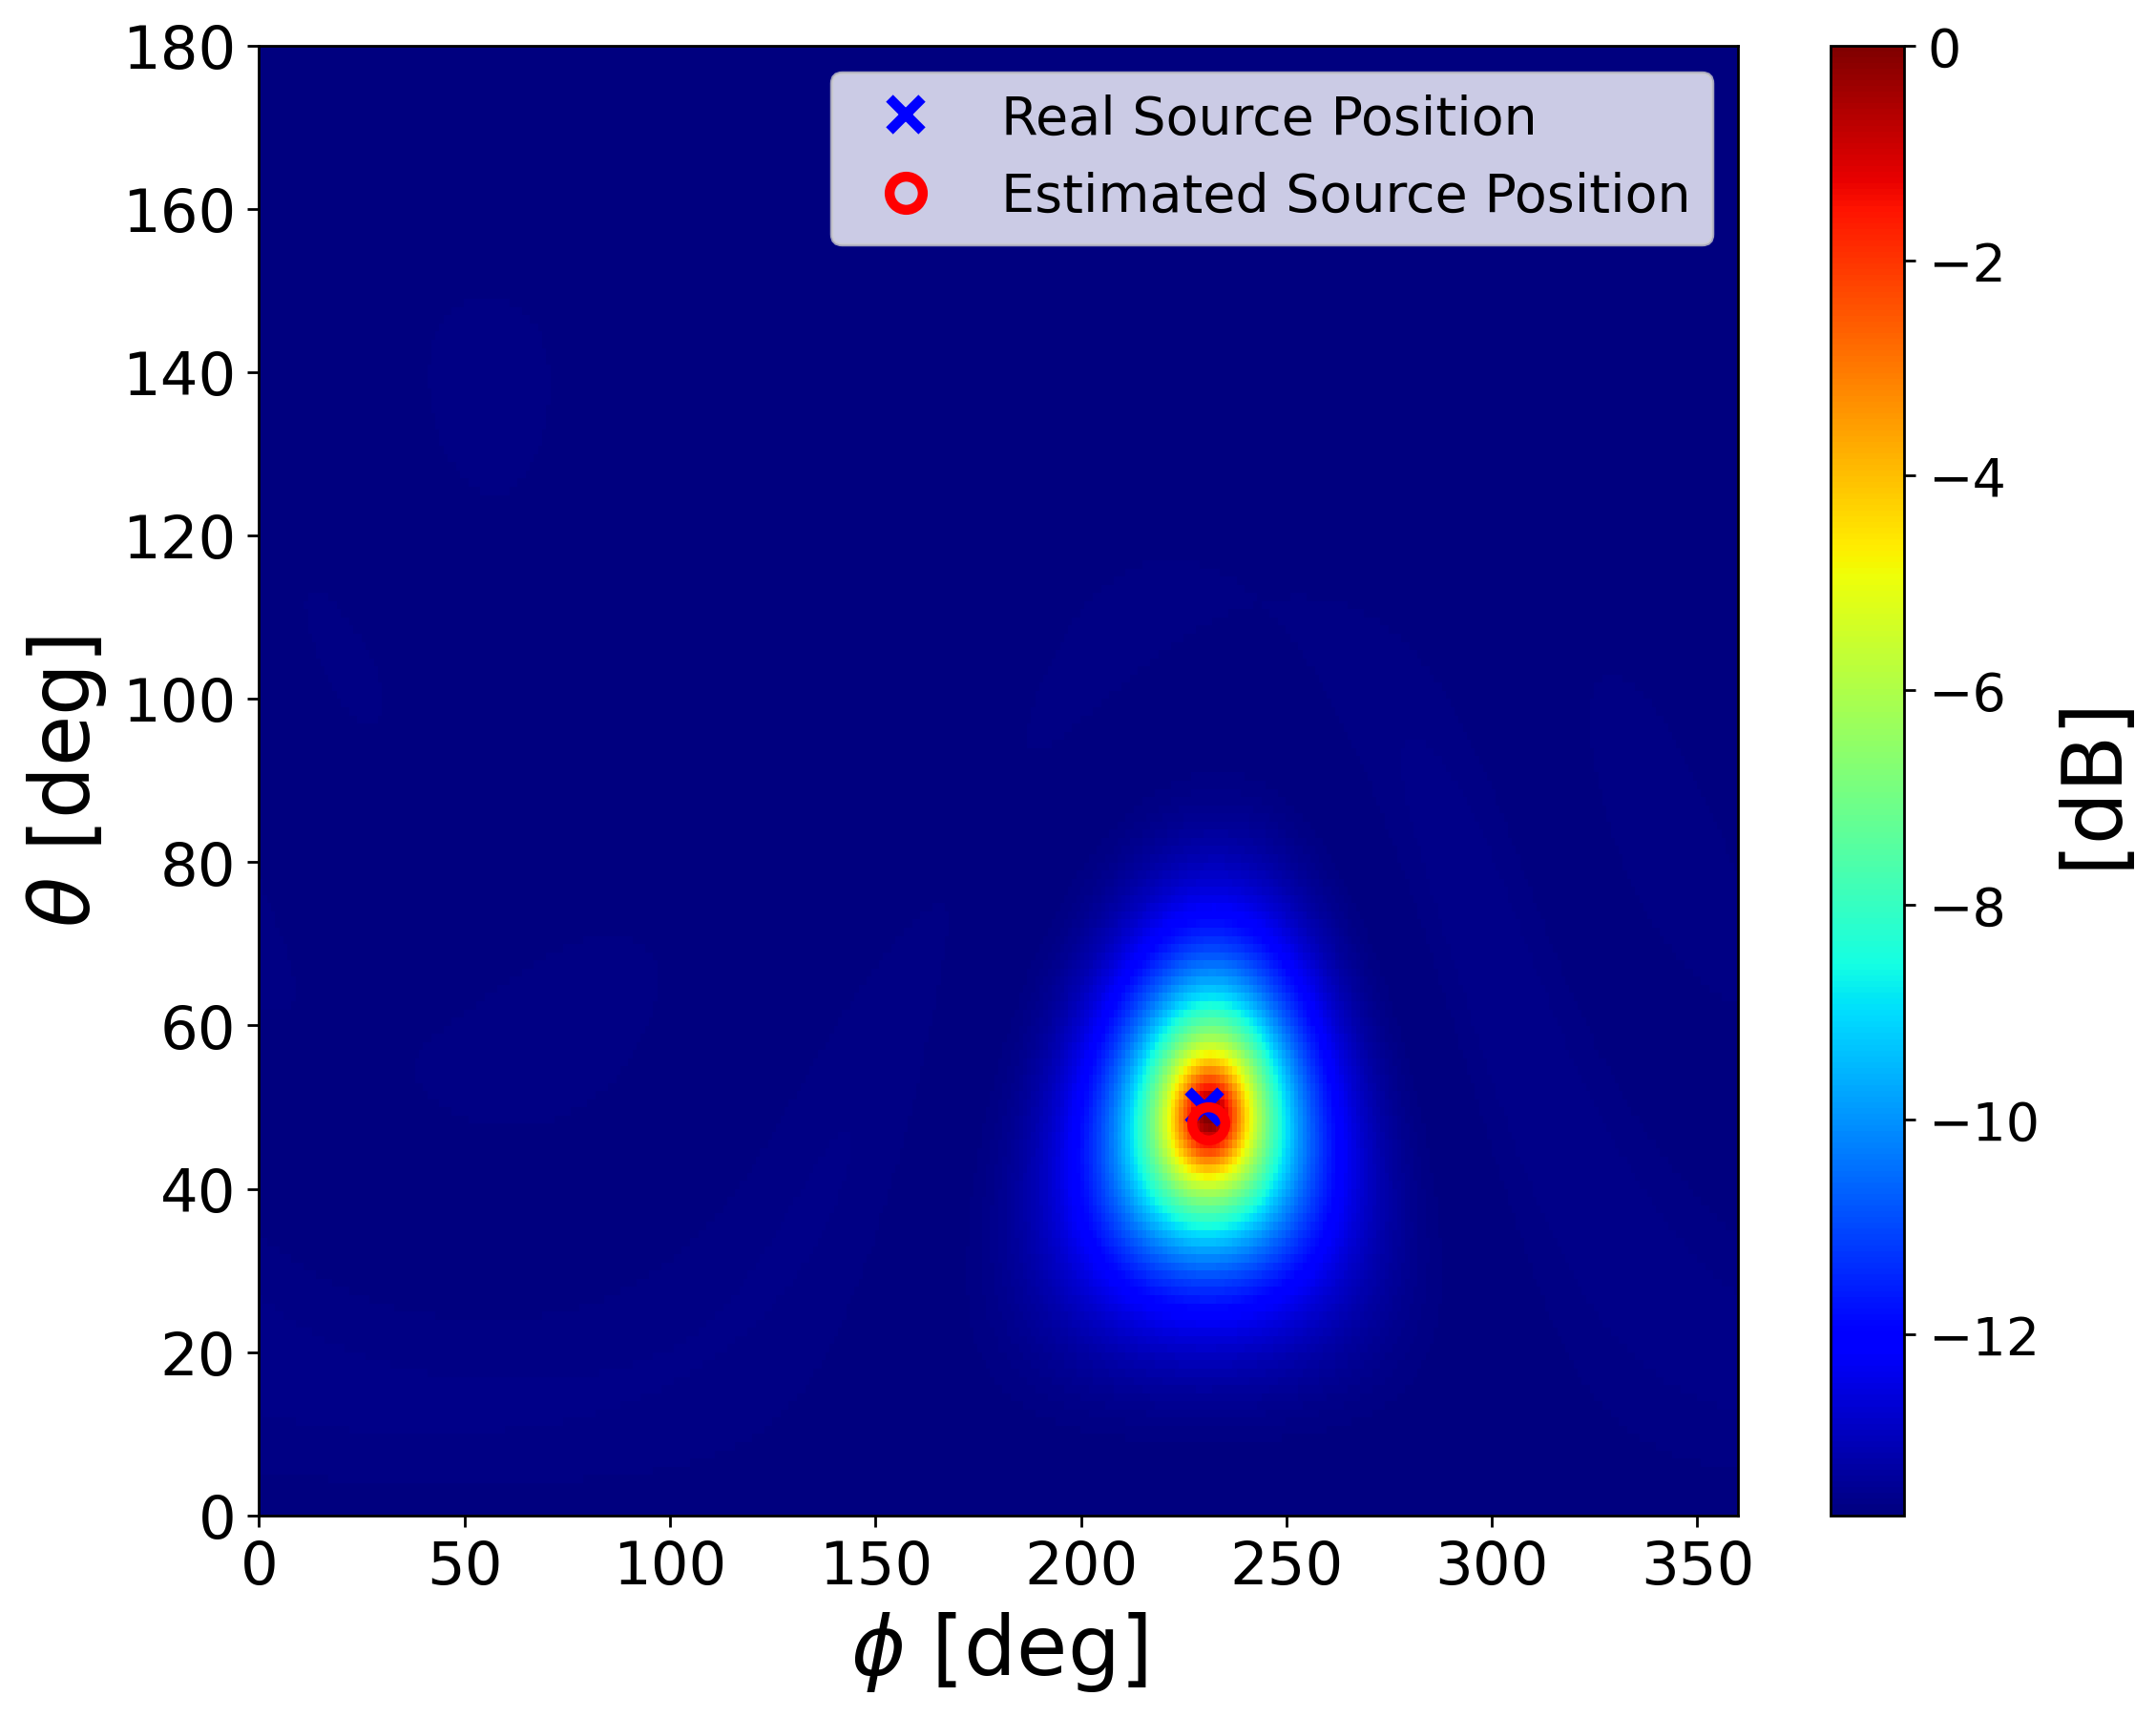

In [14]:
out_music_rigid, est_music_rigid = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "MUSIC", "rigid", "2D")

这里假设$\Theta = [\boldsymbol{\Psi}^T, \boldsymbol{S}^T, \sigma_n^2]^T$ 为包含所有未知参数的向量, 其中$\boldsymbol{S} = [\boldsymbol{s}(k_{min})^T, ..., \boldsymbol{s}(k_{max})^T]^T$ 表示信号的幅度，其中$k_{min}$ 与$k_{max}$ 表示最小和最大的波数，并且满足$ka < N$， 在这里，我们假设$\boldsymbol{\Psi}$, $s$ 与$\sigma_n^2$ 为确定且未知的，而观测数据$\boldsymbol{p}_{nm}$ 假设为随机的。

那么如果给定$\Theta$, 球谐域信号$\boldsymbol{p} _{nm}$ 的似然函数可以表示为：
\begin{equation}
f(\boldsymbol{p}_{nm}; \Theta) = \frac{exp(-\sum_{k=k_{min}}^{k_{max}}[\boldsymbol{p}_{nm}(k) - \boldsymbol{V}_{nm}(k,\Psi)\boldsymbol{s}(k)]^H \boldsymbol{S}_{nn}^{-1}[\boldsymbol{p}_{nm}(kr)-\boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})\boldsymbol{s}(k)])}{(\pi^{(N+1)^2}|\boldsymbol{S}_{nn}|)^{k_{max}-k_{min}}}  \tag{45}
\end{equation}

这里的$\boldsymbol{V}_{nm}(kr,\Psi) = \boldsymbol{B}(kr) \boldsymbol{Y}^H (\boldsymbol{\Psi})$, 对上式取对数，将方程(41) 带入上式，忽略掉常数项， log似然函数$L(\boldsymbol{p}_{nm};\Theta)$ 可以表示为：
\begin{equation}
L(\boldsymbol{p}_{nm};\Theta) = -(N+1)^2 (k_{max} - k_{min}) log{\sigma_n^2} - \frac{Q}{4\pi \sigma_n^2} \sum_{k = k_{min}}^{k_{max}}|\boldsymbol{p}_{nm}(kr) - \boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi}) \boldsymbol{s}(k)|^2   \tag{46}
\end{equation}

然后固定$\boldsymbol{\Psi}$ 和$\boldsymbol{s}$ ,将$\sigma_n^2$ 作为未知参数，最大化上述公式，有：
\begin{equation}
\hat{\sigma}_n^2 = \frac{Q}{4\pi(N+1)^2 (k_{max} - k_{min})} \sum_{k = k_{min}}^{k_{max}} |\boldsymbol{p}_{nm}(kr) - \boldsymbol{V}_{nm}(kr,\boldsymbol{\Psi})\boldsymbol{s}(k)|^2   \tag{47}
\end{equation} 

我们有球谐域的声压的矩阵表达如下：
\begin{equation}
\boldsymbol{p}_{nm}(kr) \approx \boldsymbol{B}(kr) \boldsymbol{Y}^H(\boldsymbol{\Psi})\boldsymbol{s}(k) + \boldsymbol{n}_{nm}(k)  \tag{48}
\end{equation}

将方程(48), (47)带入log似然函数中，并且忽略所有的常数项，考虑对数的单调性，有$\boldsymbol{\Psi}$ 和$\boldsymbol{s}$ 的最大似然估计为：
\begin{equation}
(\hat{\Psi}, \hat{s}) = argmin_{\boldsymbol{\Psi}, \boldsymbol{s}}\sum_{k=k_{min}}^{k_{max}} |\boldsymbol{p}_{nm}(kr) - \boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi}\boldsymbol{s}(k))|^2   \tag{49}
\end{equation}

如果我们固定$\boldsymbol{\Psi}$， 那么每个频率处的$\boldsymbol{s}$ 可以通过最小二乘准则得到：
\begin{equation}
\hat{\boldsymbol{s}}(k) = \boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})^\dagger \boldsymbol{p}_{nm}(kr)   \tag{50}
\end{equation}

将公式(50) 带回 (49) 可以得到：
\begin{equation}
\hat{\boldsymbol{\Psi}} =  argmin_{\boldsymbol{\Psi}}\sum_{k=k_{min}}^{k_{max}} |\boldsymbol{p}_{nm}(kr) - \boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})\boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})^\dagger \boldsymbol{p}_{nm}(kr)|^2   \tag{51}
\end{equation}

那么综上所述，SHMLE算法的代价函数为：
\begin{equation}
J_{SHMLE}(\boldsymbol{\Psi}) = - 10log_{10}(\sum_{k=k_{min}}^{k_{max}}||\boldsymbol{p}_{nm}(kr) - \boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})\boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})^\dagger \boldsymbol{p}_{nm}(kr)||^2)  \tag{52}
\end{equation}

窄带SHMLE算法便为公式(52)在特定的$k$ 的计算结果，其可以表示为：
\begin{equation}
\hat{\boldsymbol{\Psi}} = argmax_{\Psi} = (-20 log_{10}||\boldsymbol{p}_{nm}(kr) - \boldsymbol{V}_{nm}(kr,\boldsymbol{\Psi}) \boldsymbol{V}_{nm}(kr, \boldsymbol{\Psi})^\dagger \boldsymbol{p}_{nm}(kr)||)  \tag{53}
\end{equation}


而宽带SHMLE的定位结果为：
\begin{equation}
\hat{\boldsymbol{\Psi}} = argmax_{\boldsymbol{\Psi}} J_{SHMLE}(\boldsymbol{\Psi})    \tag{54}
\end{equation}


可以看到这里的SHMLE方法并没有涉及到$b_n{kr}$ 的除法，从而也就克服了在open-sphere阵列结构下不能使用的问题，且保证了较高的空间分辨率。

source_pos: [[ 50]
 [230]]


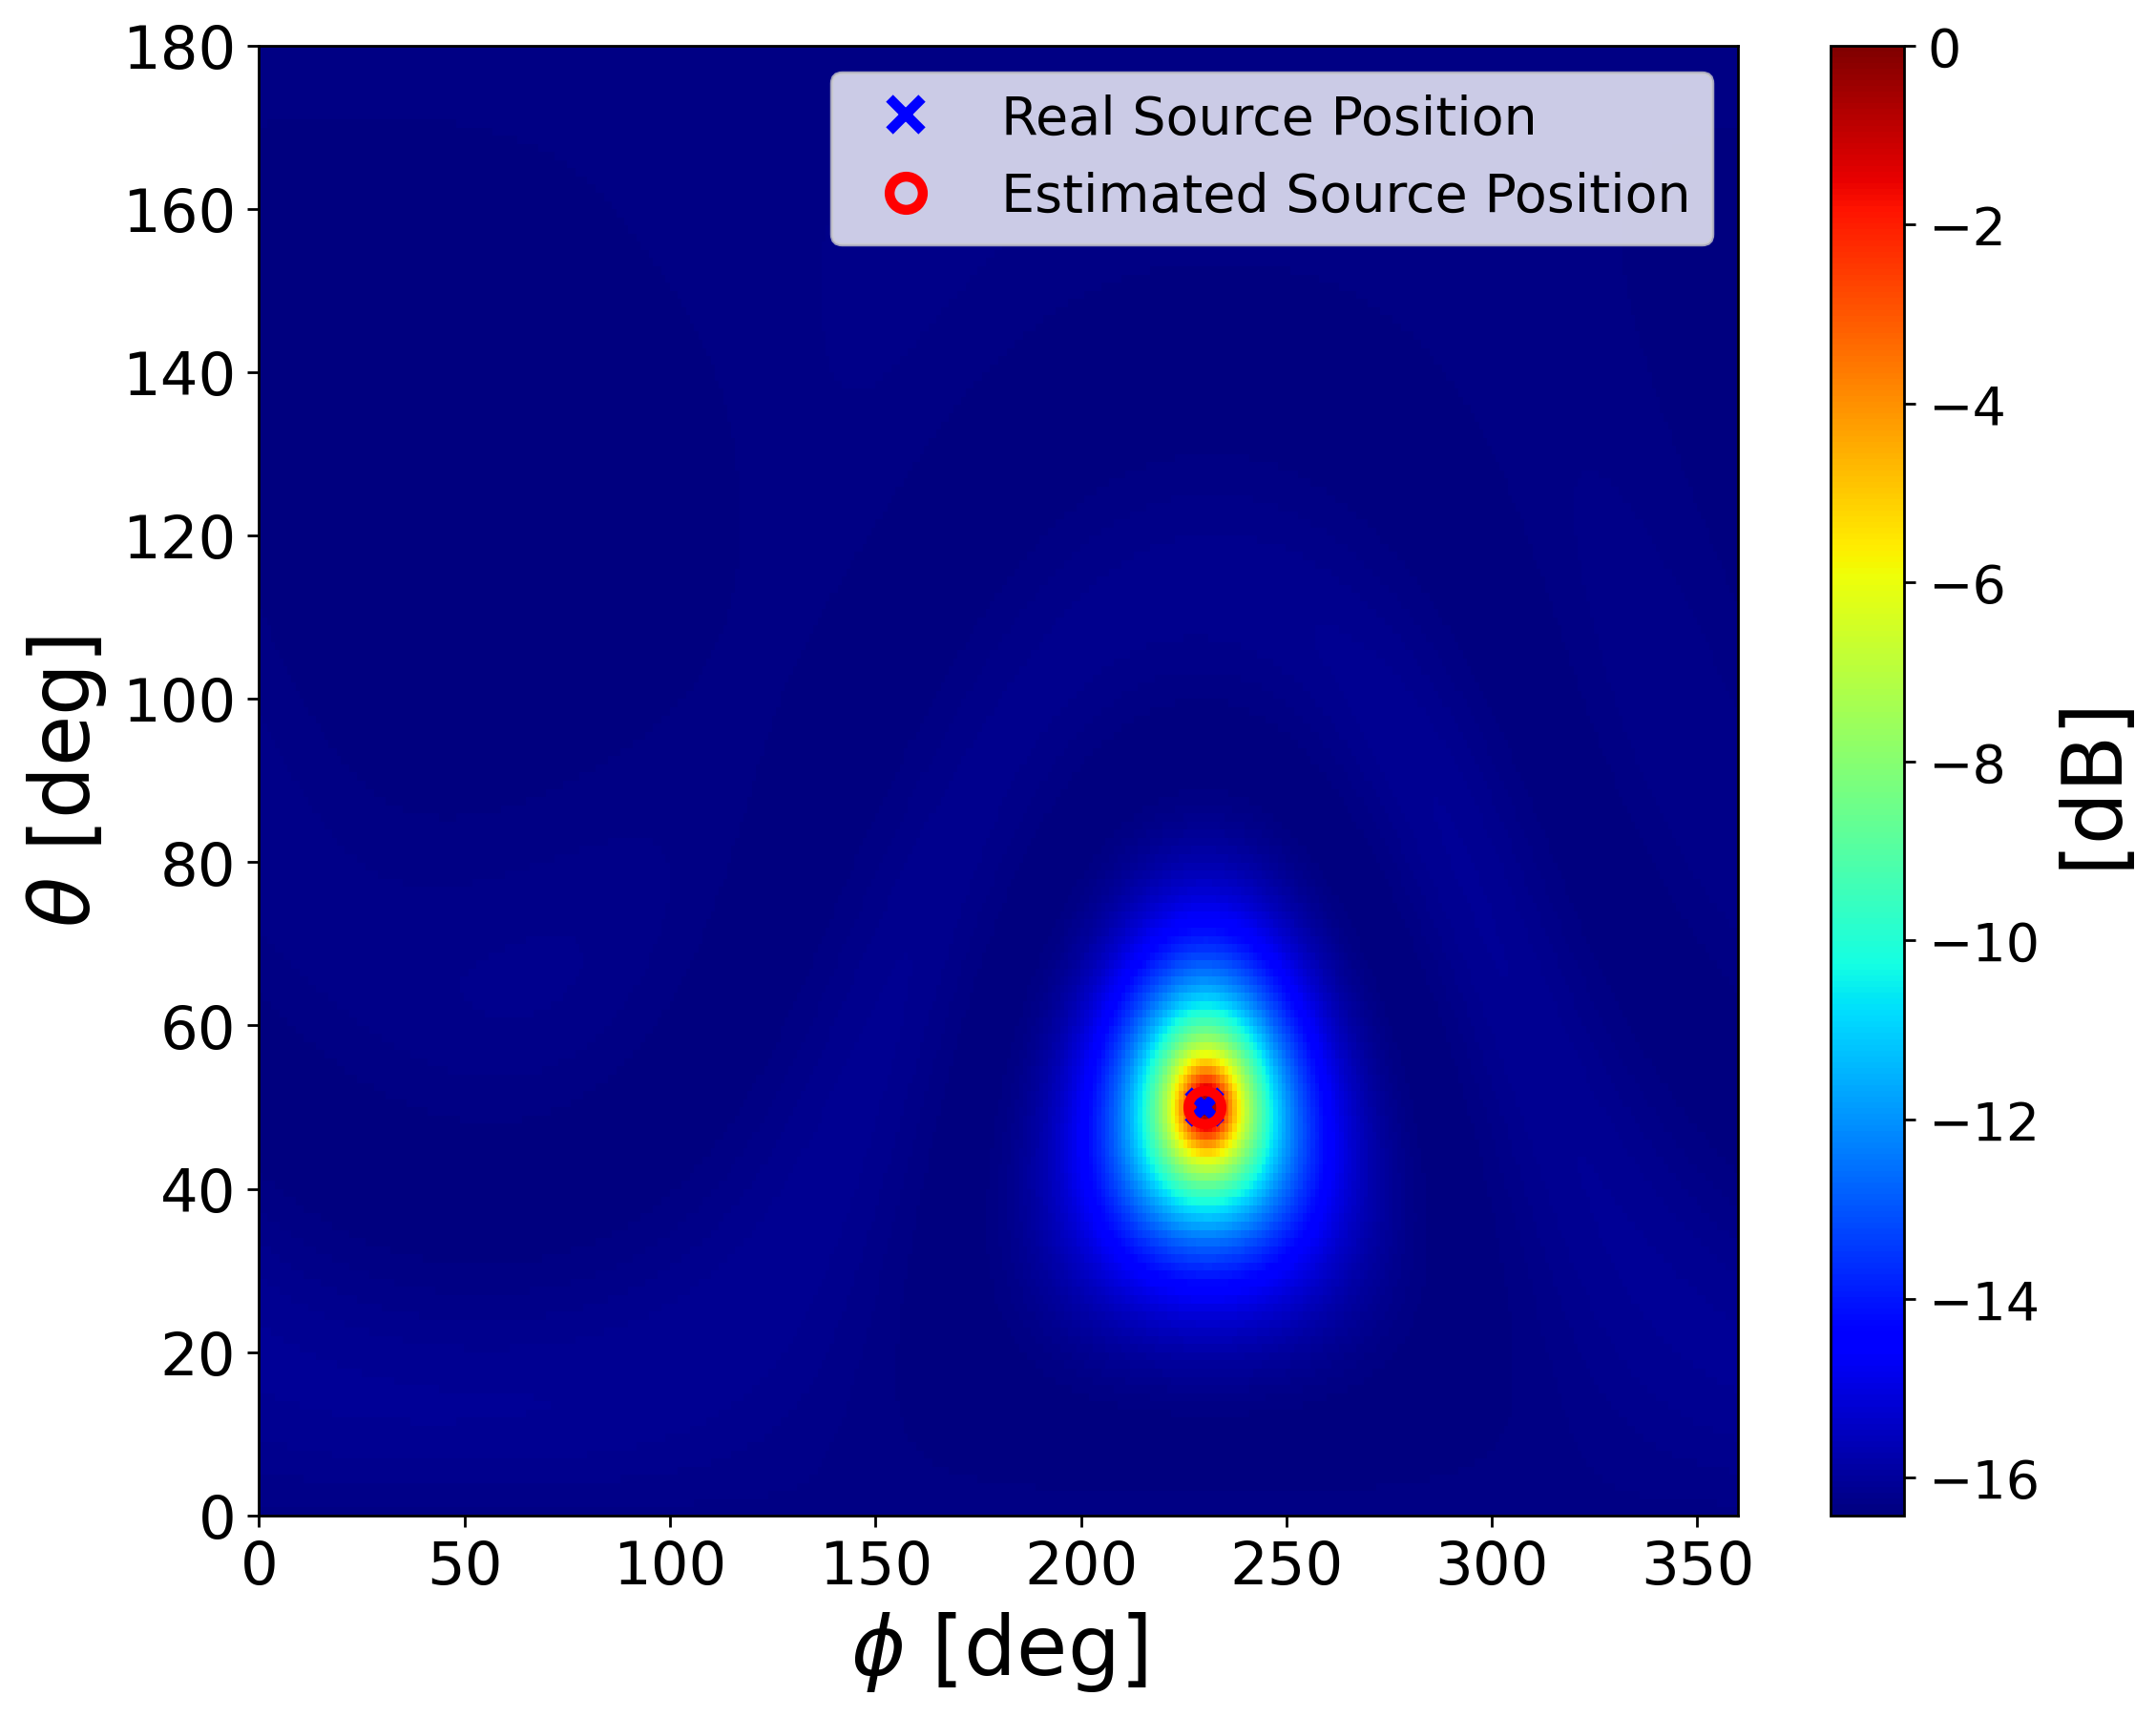

In [15]:
out_mle_open, est_mle_open = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "SHMLE", "open", "2D")

source_pos: [[ 49]
 [231]]


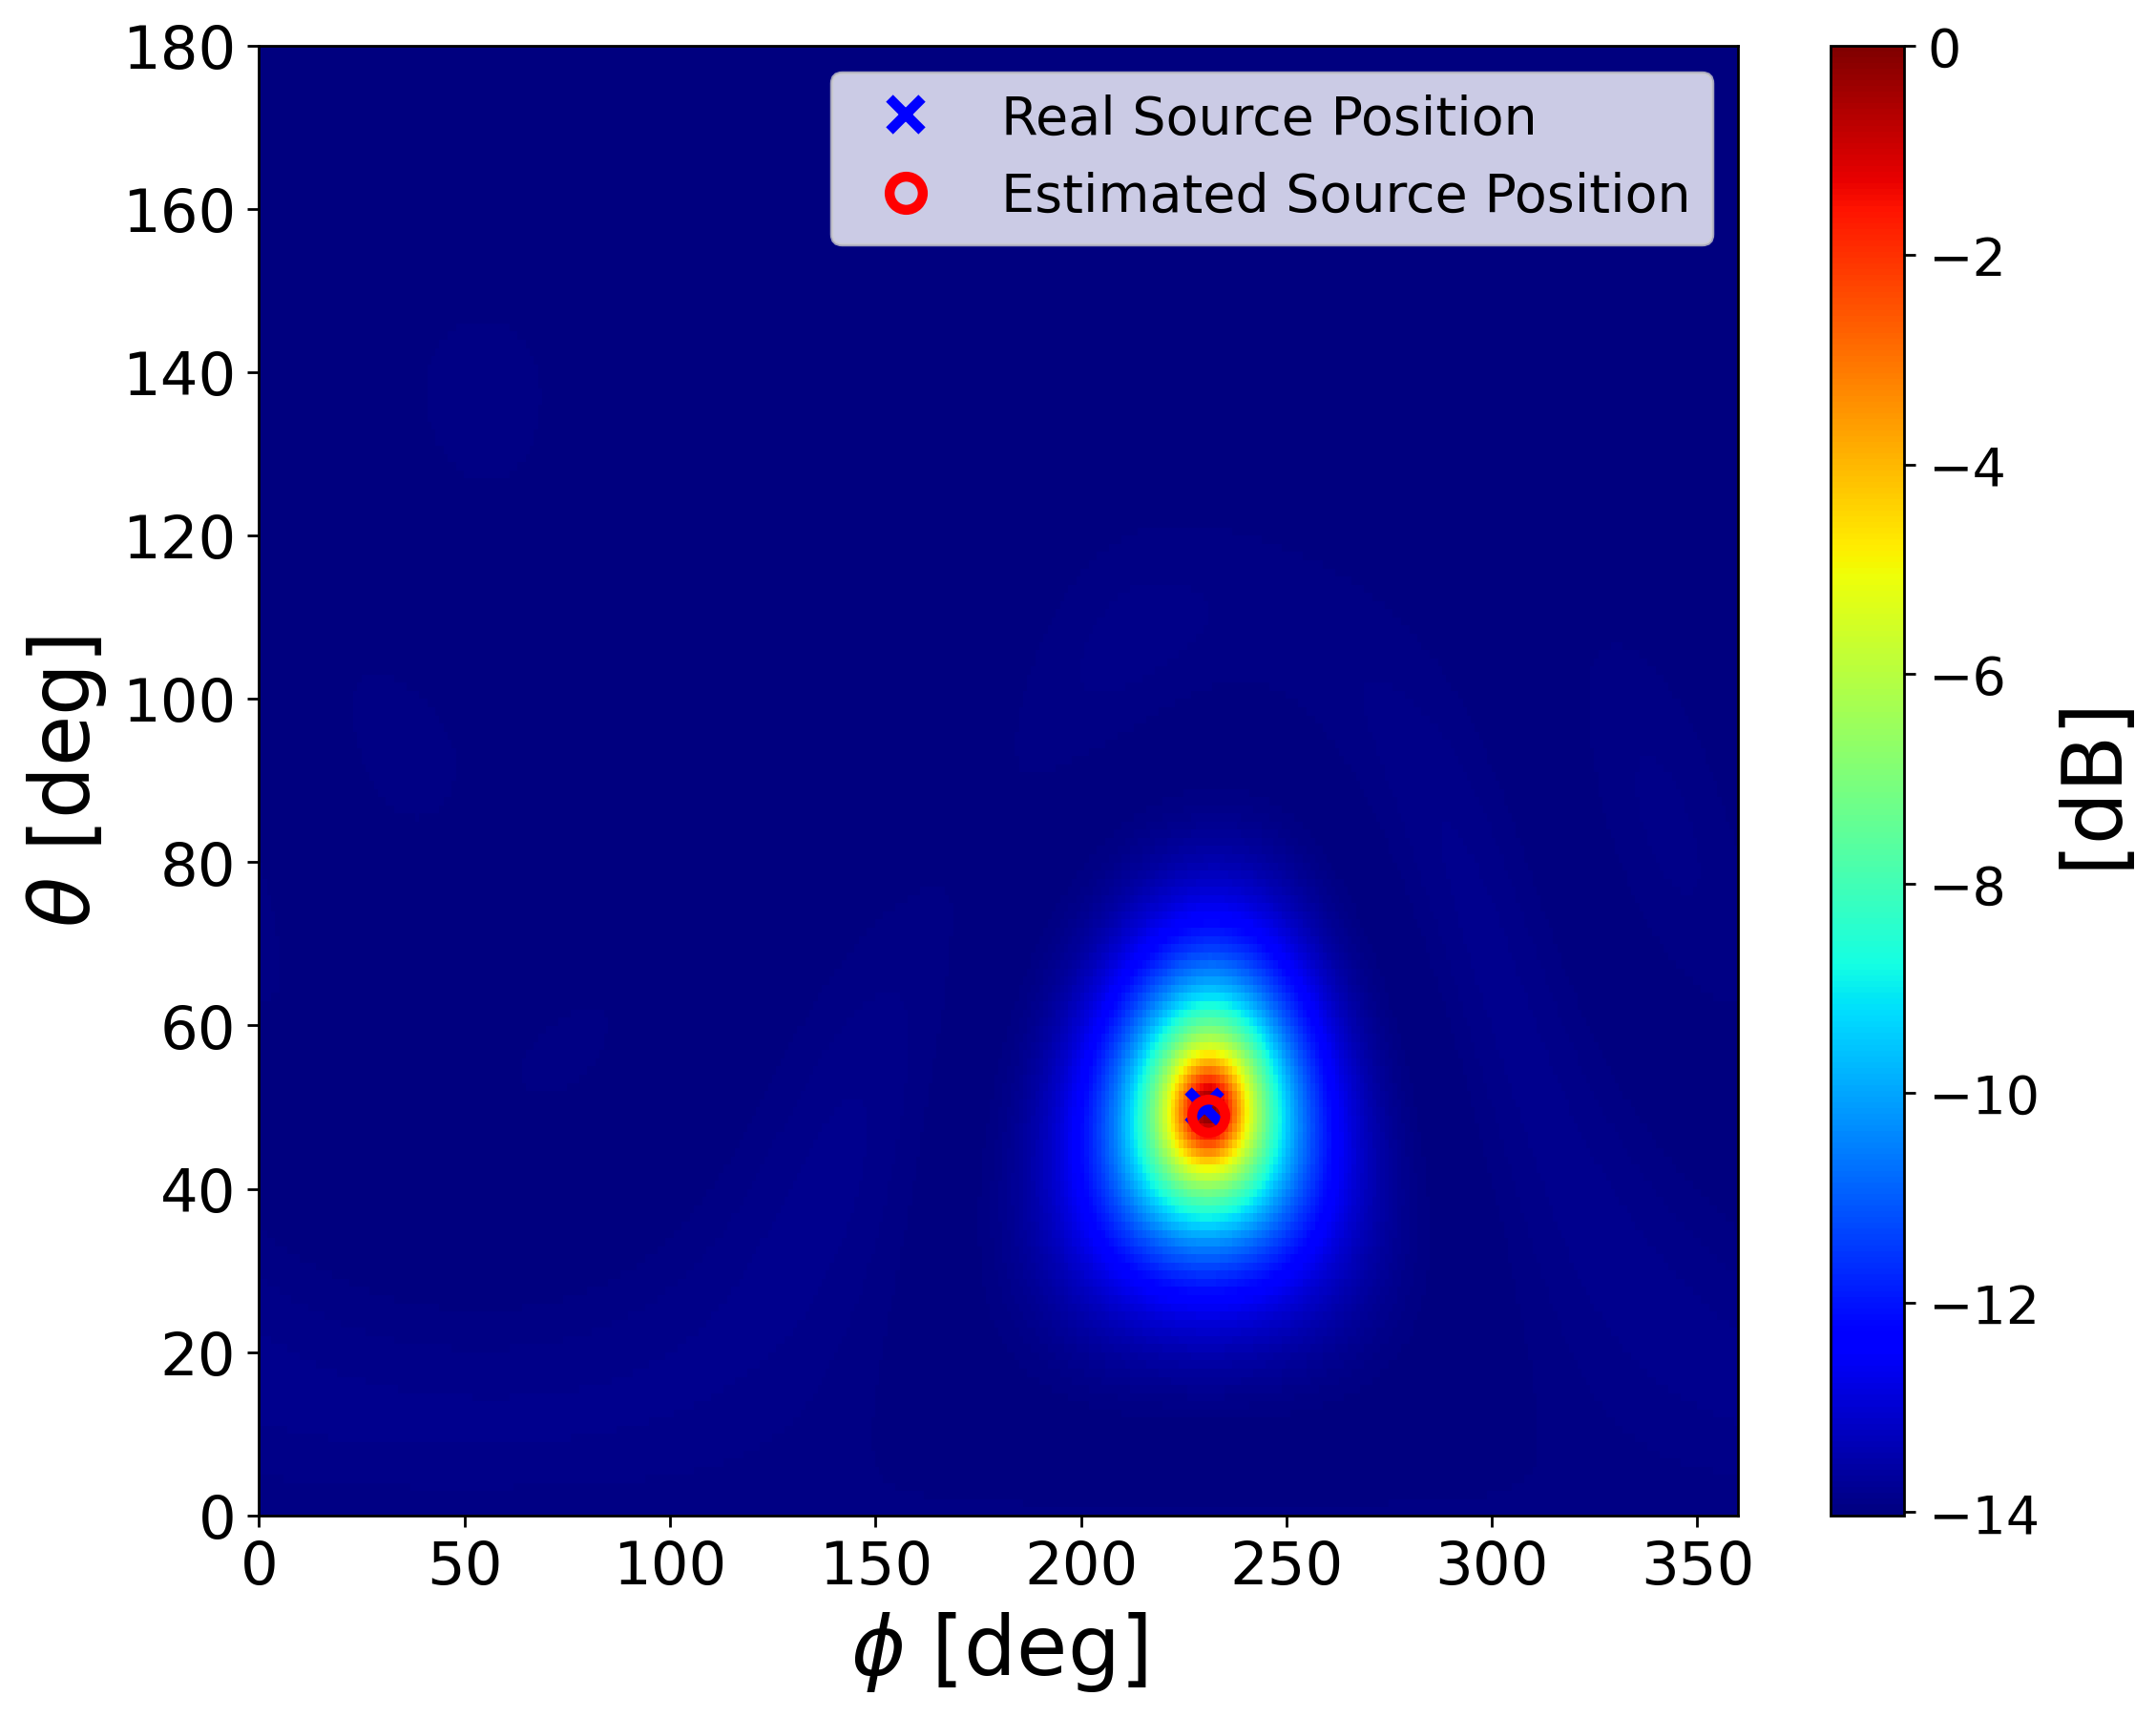

In [16]:
out_mle_rigid, est_mle_rigid = ssl_SHmethod(MicArray32, Theta_l, Phi_l, "SHMLE", "rigid", "2D")

### 房间仿真及宽带声源定位
在之前的几节，我们主要介绍了声源定位算法的基本原理，但是主要使用的是比较简单的声源，即单频率幅值的声源，这里我们将介绍使用**pyroomacoustics**库来进行房间，阵列和声源的仿真, 并运用算法对具有混响噪声环境下的宽带人声信号进行定位处理。

#### pyroomacoustics 库
**Pyroomacoustics** 是一个用于音频信号处理和声学模拟的Python库，特别是它提供了用于房间声学模拟和麦克风阵列处理的工具。这个库是面向研究人员和工程师的，它将复杂的声学原理和算法封装在一个易于使用的接口之后。

##### 主要特性

1. **房间声学模拟**：
   - 支持创建不同几何形状的房间模型。
   - 能够模拟声波在房间中的反射和衰减。
   - 允许定义墙壁的吸收系数和散射系数，以更真实地模拟声音在不同材料上的行为。

2. **麦克风阵列处理**：
   - 提供了构建和模拟不同类型麦克风阵列的功能。
   - 支持波束形成、声源定位和其他空间滤波技术。

3. **声源定位**：
   - 实现了多种声源定位算法，如时间差定位（TDOA）和基于波束形成的方法。
   - 允许模拟单个或多个声源在房间内的行为。

4. **信号处理工具**：
   - 包含用于声音信号分析和处理的多种工具，如滤波器设计、信号分解等。
   - 支持不同格式的音频文件输入和输出。

5. **仿真和可视化**：
   - 提供了一套仿真工具，可以用来测试和验证声学模型和算法。
   - 包含可视化工具，以图形方式展示房间模型、声源和麦克风阵列的配置。

详细信息：[pyroomacoustics documentation](https://pyroomacoustics.readthedocs.io/en/pypi-release/)

#### 仿真参数
仿真参数如下：
1.房间仿真：在这里我们主要以DTU 352 教学楼 019 教室的尺寸作为目标房间，在仿真中设置有尺寸 $(9 \times 6 \times 3)$ m， 
![Alt text](image-4.png)


2.麦克风阵列仿真：使用Eigenmike EM32球形均匀分布 rigid-sphere 阵列, 其中有麦克风数量$Q = 32$, 最大球谐分解阶数为$N = 4$。

3.声源仿真：在单麦克风阵列情况下，以麦克风阵列的中心为球坐标原点（与房间几何中心对齐），假设声源来自于$(\theta_s, \phi_s)$ 处，其中$\theta_s = 50\degree$, $\phi_s = 230\degree$, 声源距离原点 2.1 m, 声源包含一个长为2s的干净语音样本，其内容为 "Please call stella"，采样率为 $f_s = 16kHz$, 帧长为$K = 1024$。




In [8]:
### The room properties
room_dim = np.array([9, 6, 3])
ori_coor = room_dim/2

**设置声源**

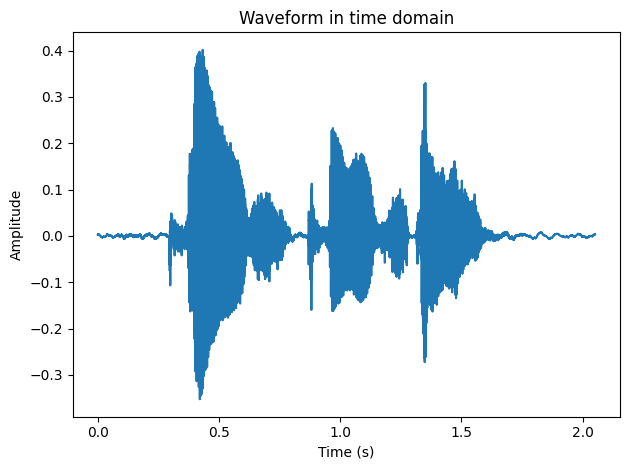

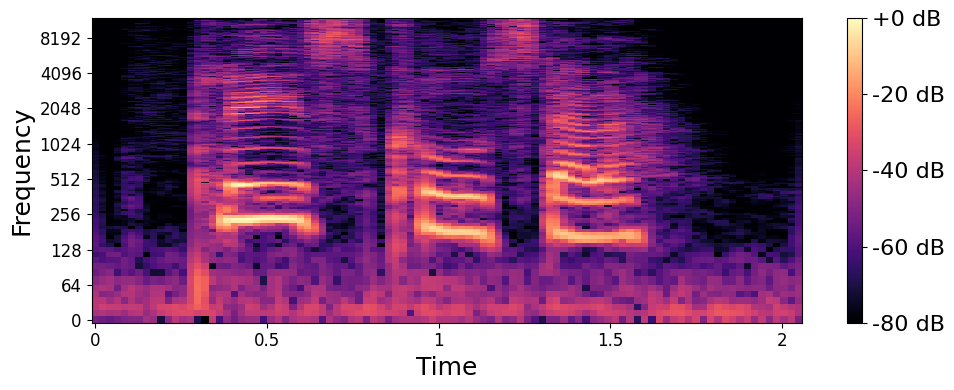

In [8]:
### Sound Source
mic_signals_speech, fs, num_channels = soundread('/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain/Data/speech@24kHz.wav')
plot_wave(mic_signals_speech, fs)
plot_stft(mic_signals_speech, fs)
Theta_l = 50/180 * np.pi
Phi_l = 230/180 * np.pi
source_pos_car = 50*radius * np.array([np.sin(Theta_l) * np.cos(Phi_l), np.sin(Theta_l) * np.sin(Phi_l), np.cos(Theta_l)])
source_pos_car_cal = source_pos_car + ori_coor
source_pos_car_list = [source_pos_car_cal]
signal_list = [mic_signals_speech]



**设置麦克风阵列**

In [19]:
mic_pos_car = [sph2cart(r,theta,phi) for r,theta,phi in mic_pos_sph]
mic_pos_car = np.array(mic_pos_car)
mic_pos_car_cal = mic_pos_car + ori_coor
mic_arrays_car = [mic_pos_car_cal]

**设置房间**

在setRoom函数中，就将携带有人声信号的声源放置在仿真出的Anechoic或者reverberant房间中，并用对应的EM32球麦阵列获取，并将麦克风设置在对应原点位置。

In [20]:
from tools import setRoom
anechoic_room = setRoom(room_dim, mic_arrays_car, source_pos_car_list, signal_list, "Anechoic")
reverberant_room ,rt60_est= setRoom(room_dim, mic_arrays_car, source_pos_car_list, signal_list, "Reverb",0.4)
print(f'The simulated rt60 is', rt60_est)

The simulated rt60 is 0.6370234374999999


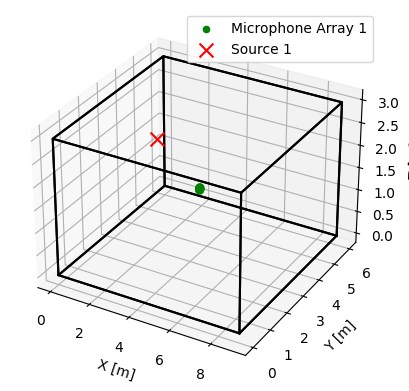

In [21]:
from plot_tools import plot_option
plot_option(reverberant_room, mic_arrays_car, source_pos_car_list)

调整SNR，设置信号位于混响时间$T_{60}  = 0.6s$, SNR 为15的环境下

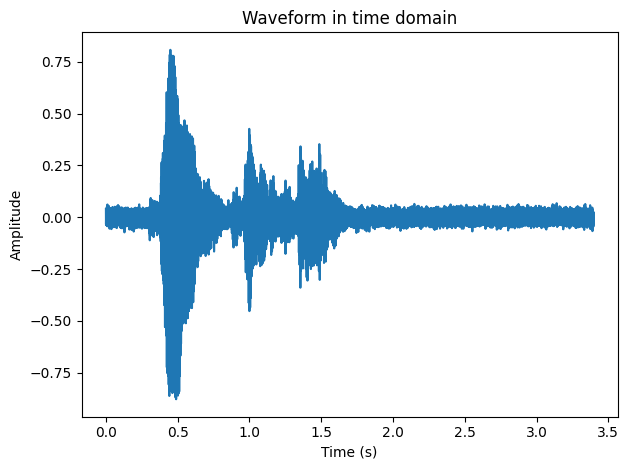

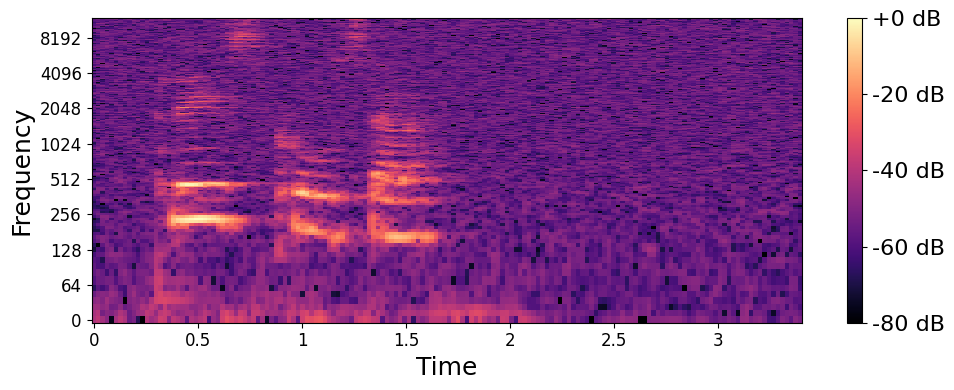

In [22]:
file_path = "/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain/Reverberant/Array_output_0/source0.wav"
signal_processed = pra.create_noisy_signal(file_path,15)
mic_signals_noisy = signal_processed[0]
plot_wave(mic_signals_noisy[:, 0], fs)
plot_stft(mic_signals_noisy[:, 0], fs)

d:\Coderlife\SSL in spherical domain\tools.py:659: RuntimeWarning: invalid value encountered in scalar divide
  bn[n ** 2:(n + 1) ** 2, k] = 4 * np.pi * (1j) ** n * (jn_ka - jn_ka_der / hn2_ka_der * hn2_ka)


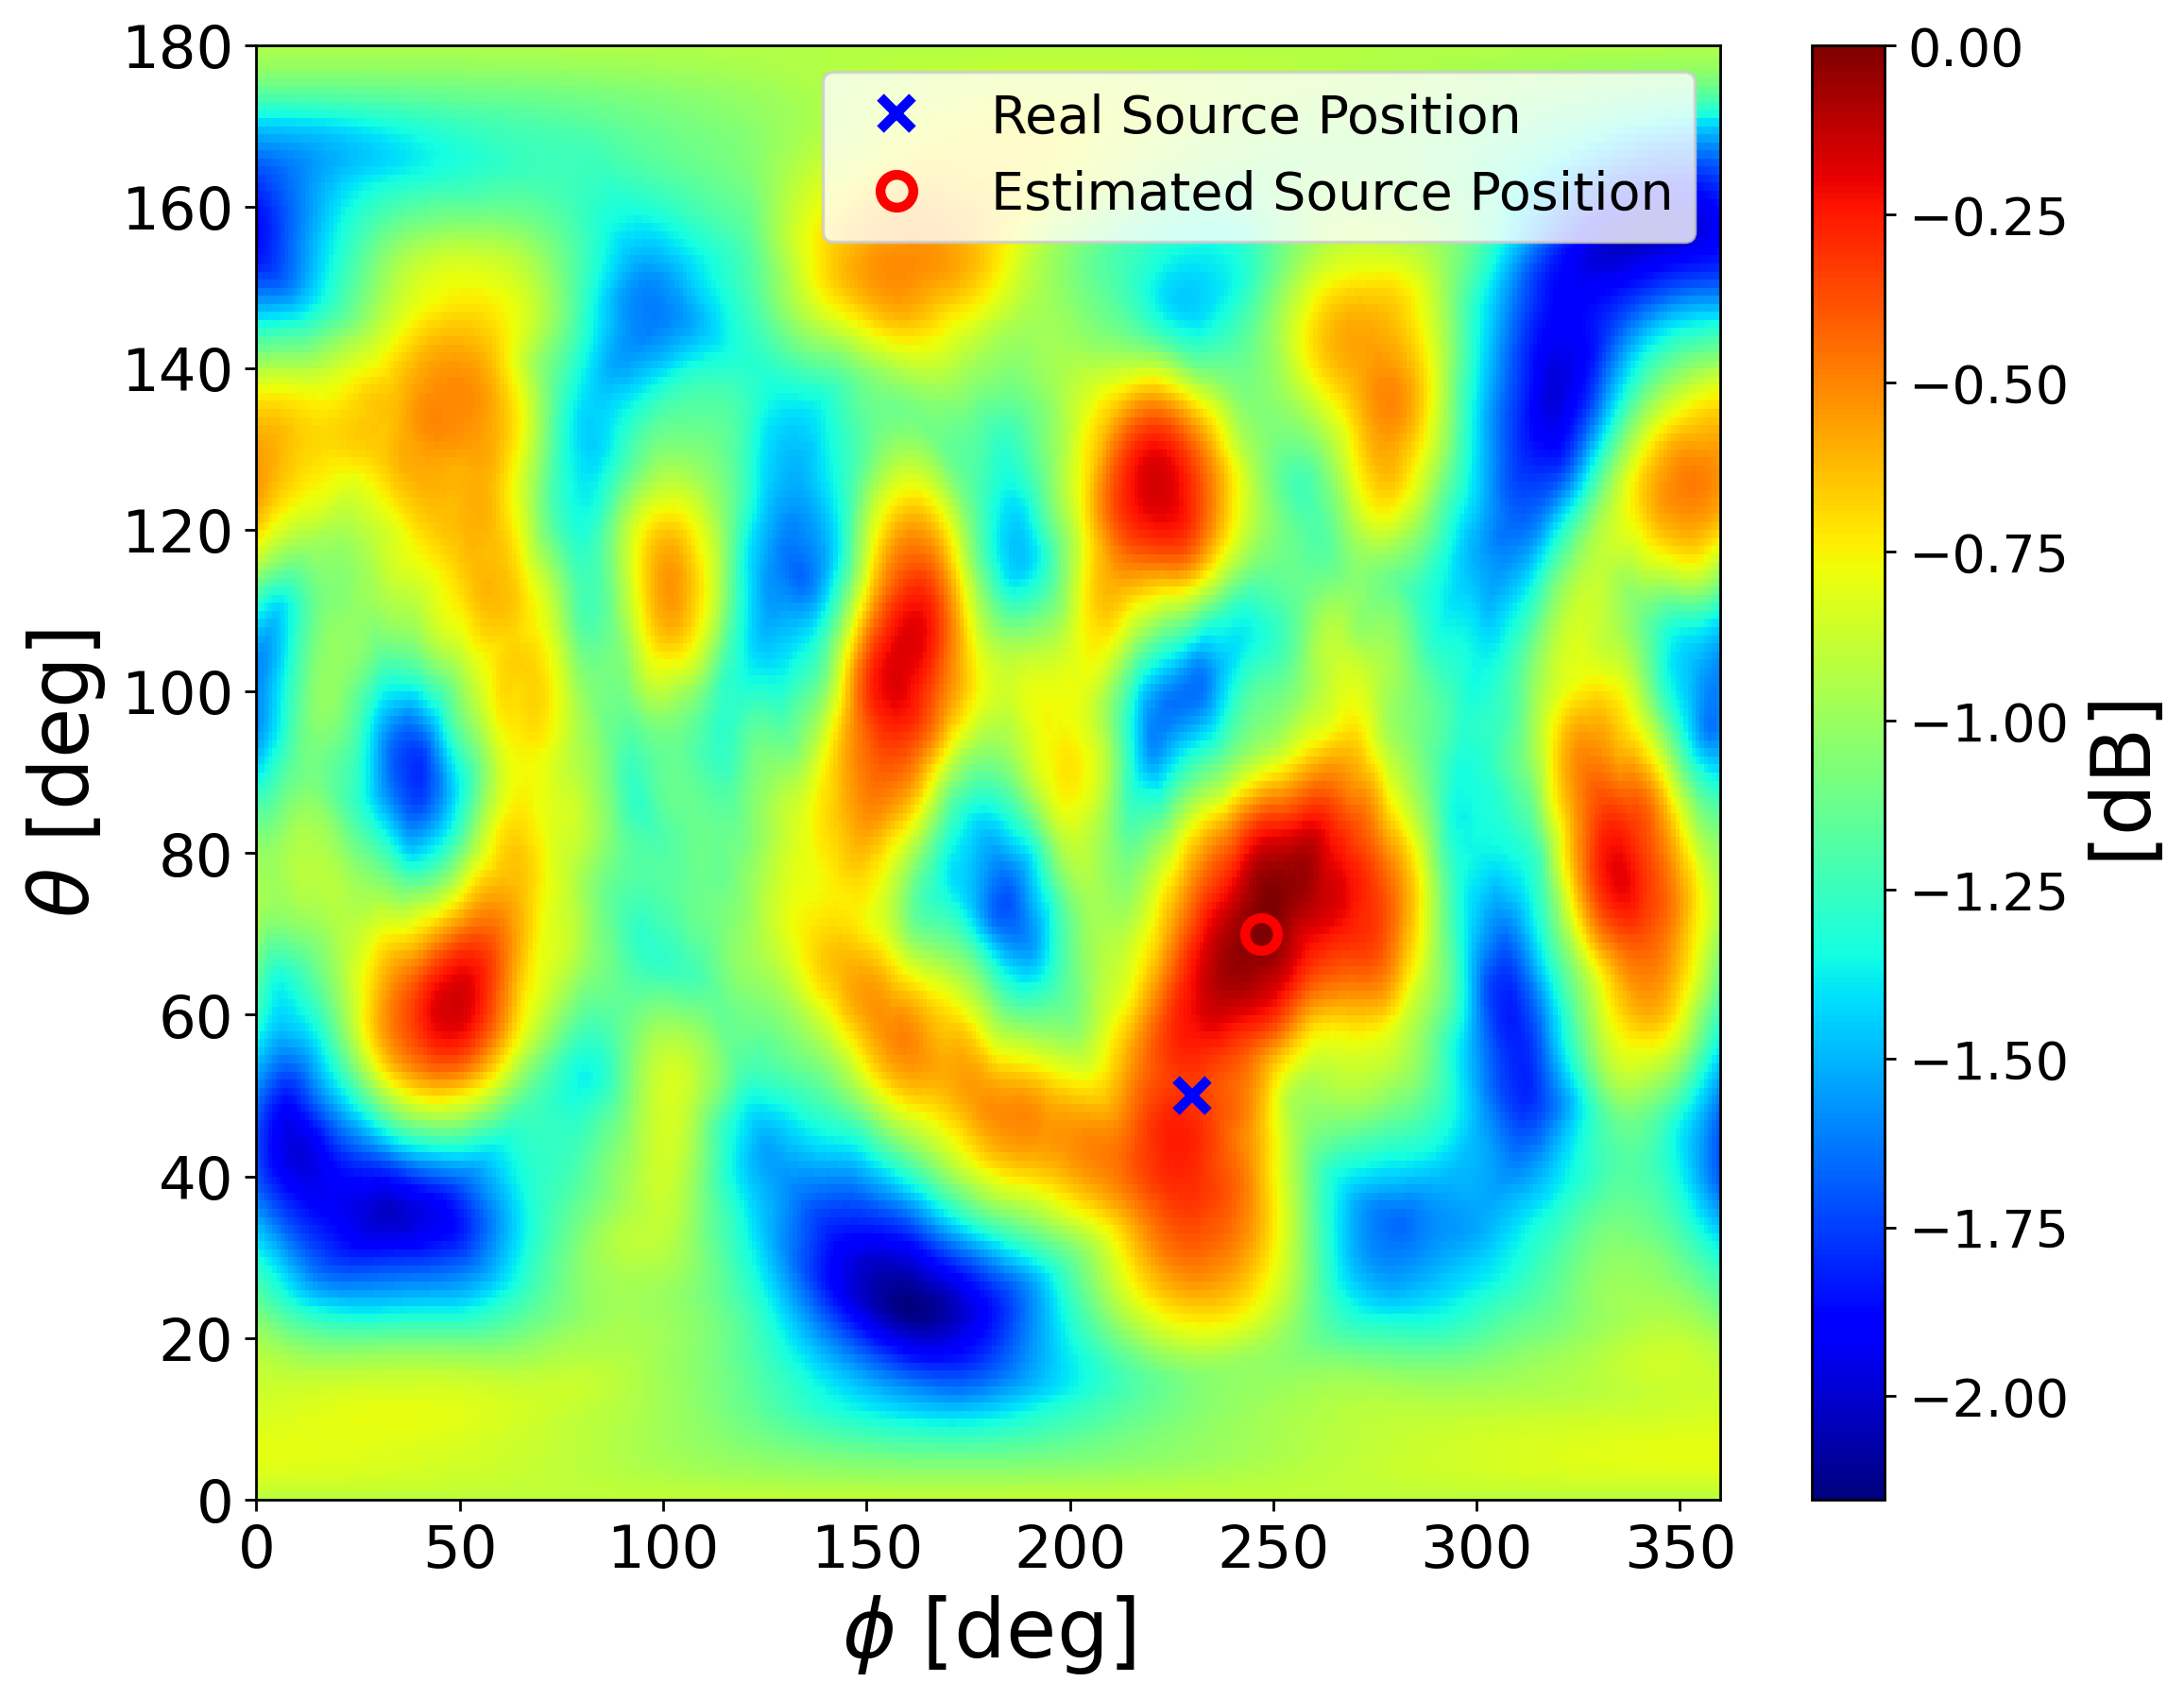

In [23]:
out_PWD, pos_est_PWD = ssl_SHmethod_broad(mic_signals_noisy,fs,mic_pos_sph,Theta_l,Phi_l,"PWD","rigid","2D",resolution = 1)

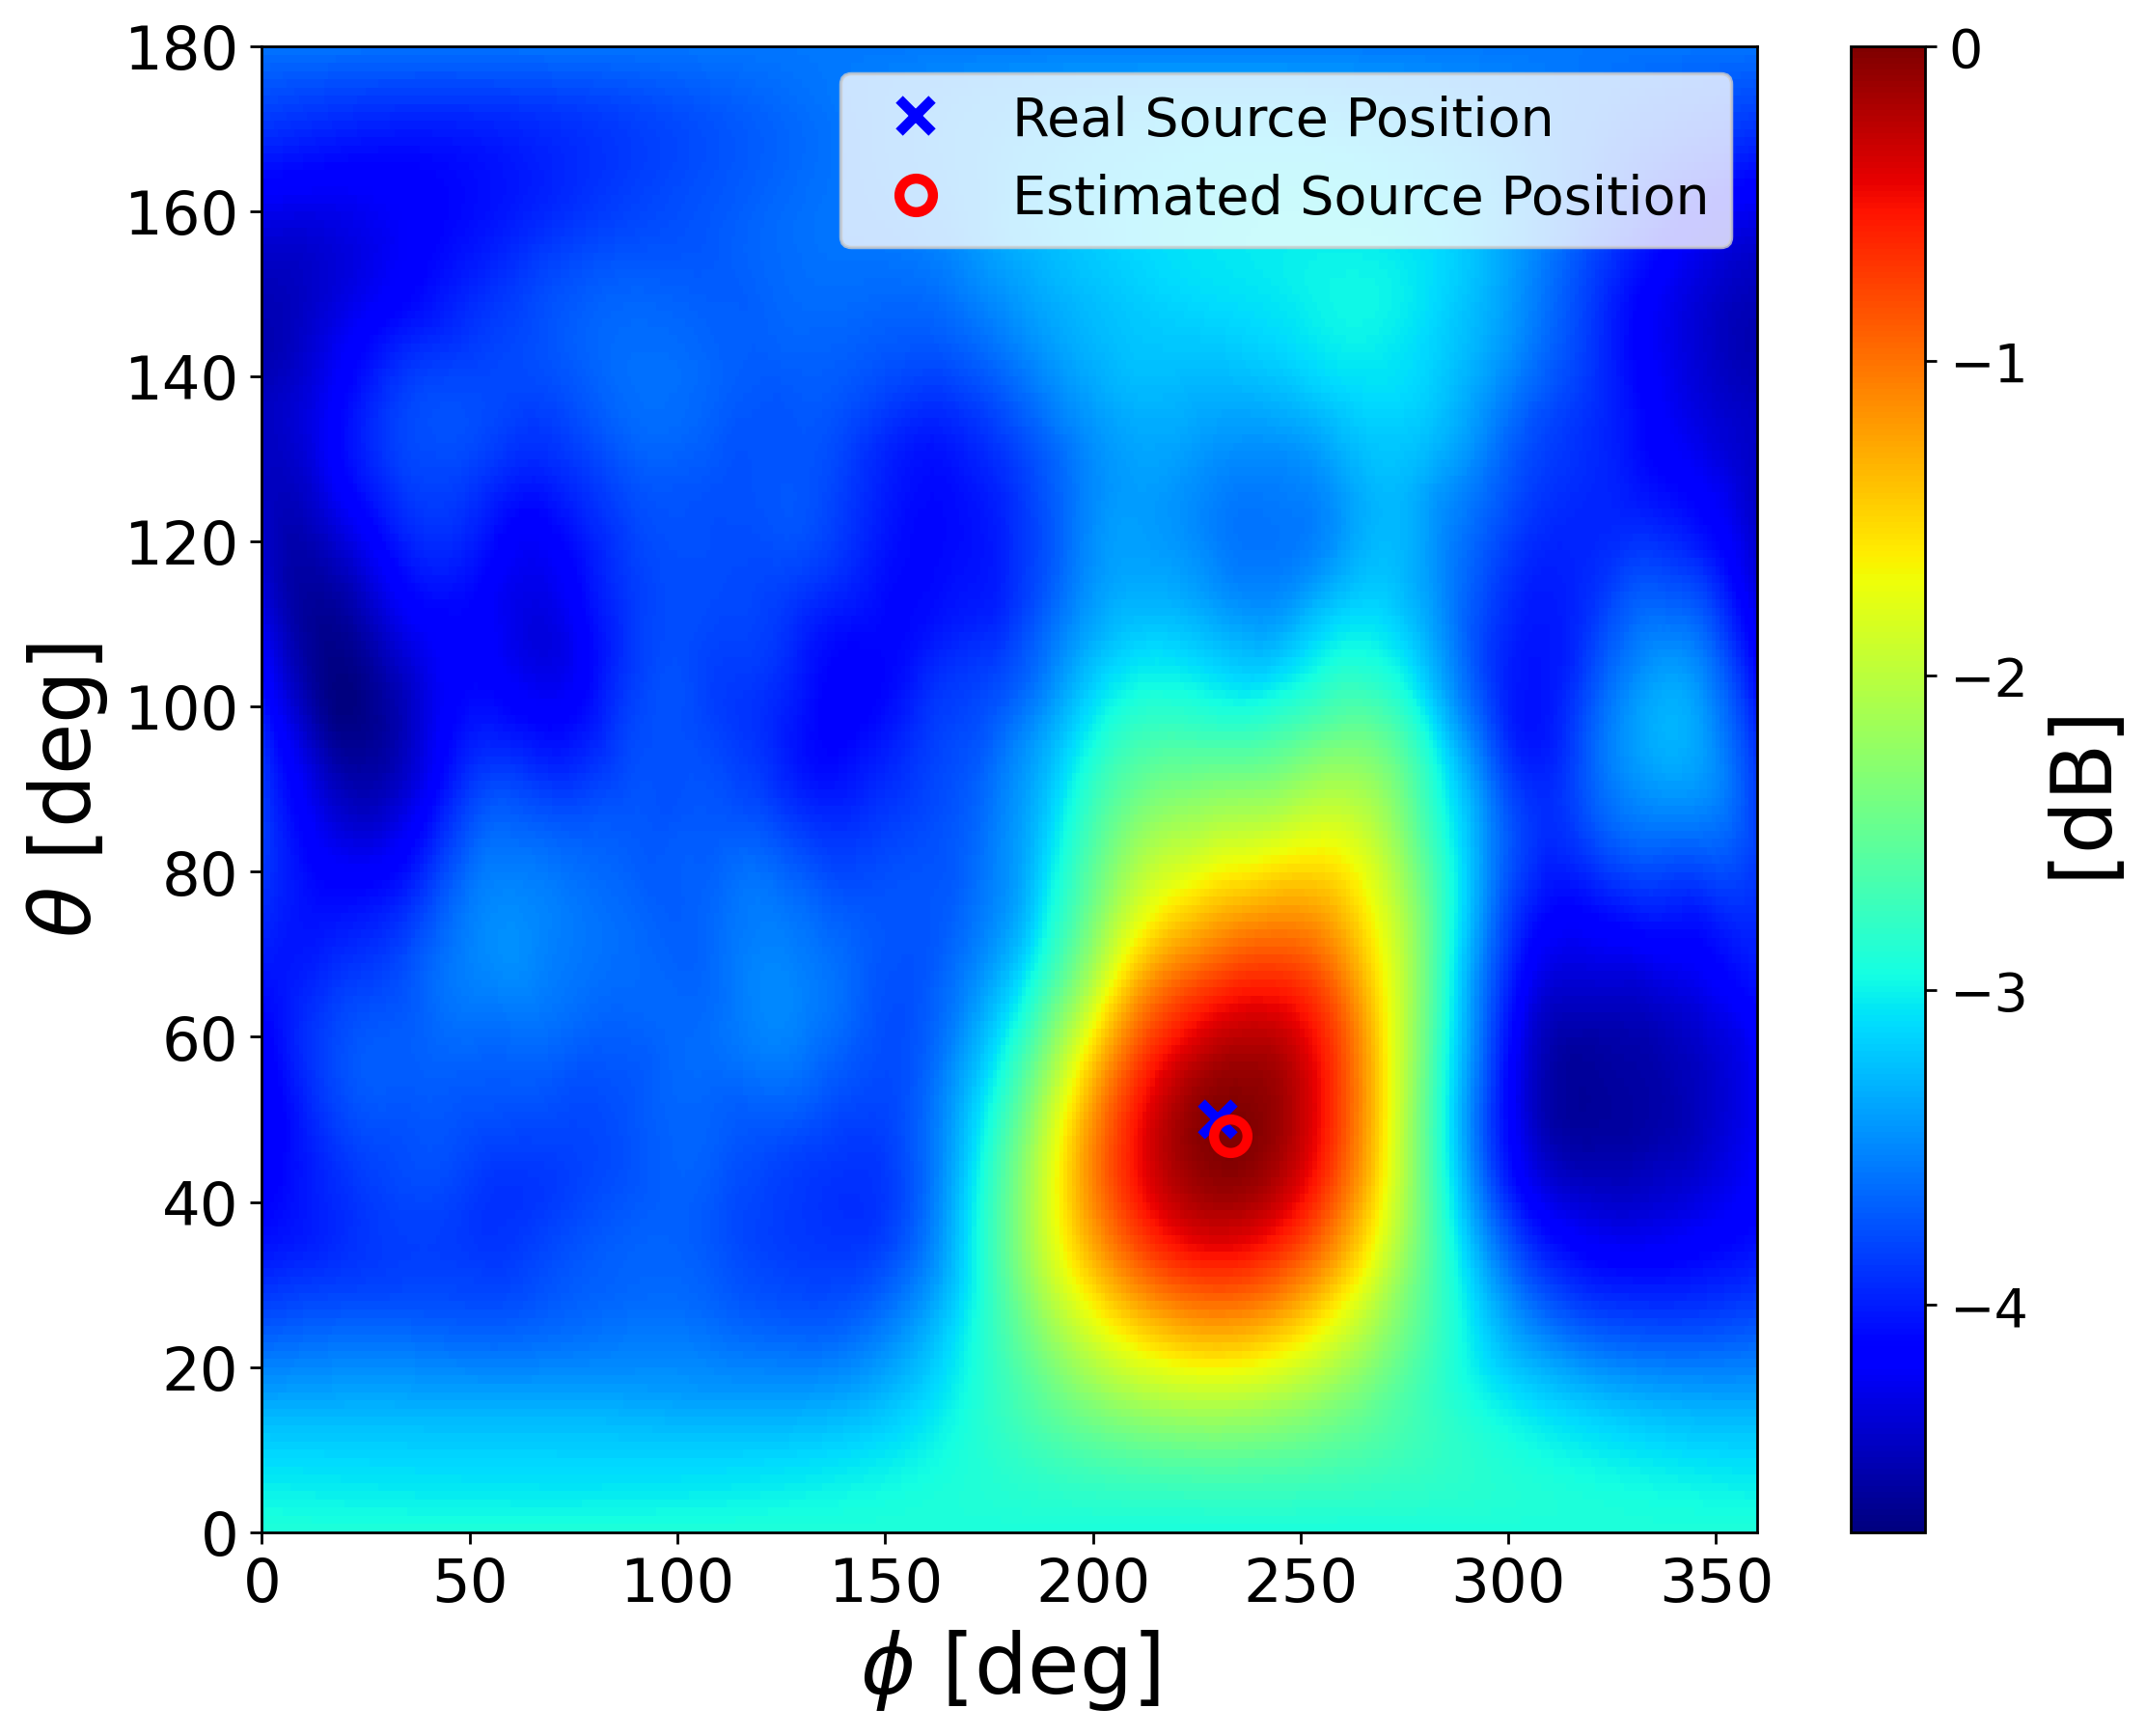

In [24]:
out_DAS, pos_est_DAS= ssl_SHmethod_broad(mic_signals_noisy,fs,mic_pos_sph,Theta_l,Phi_l,"DAS","rigid","2D",resolution = 1)

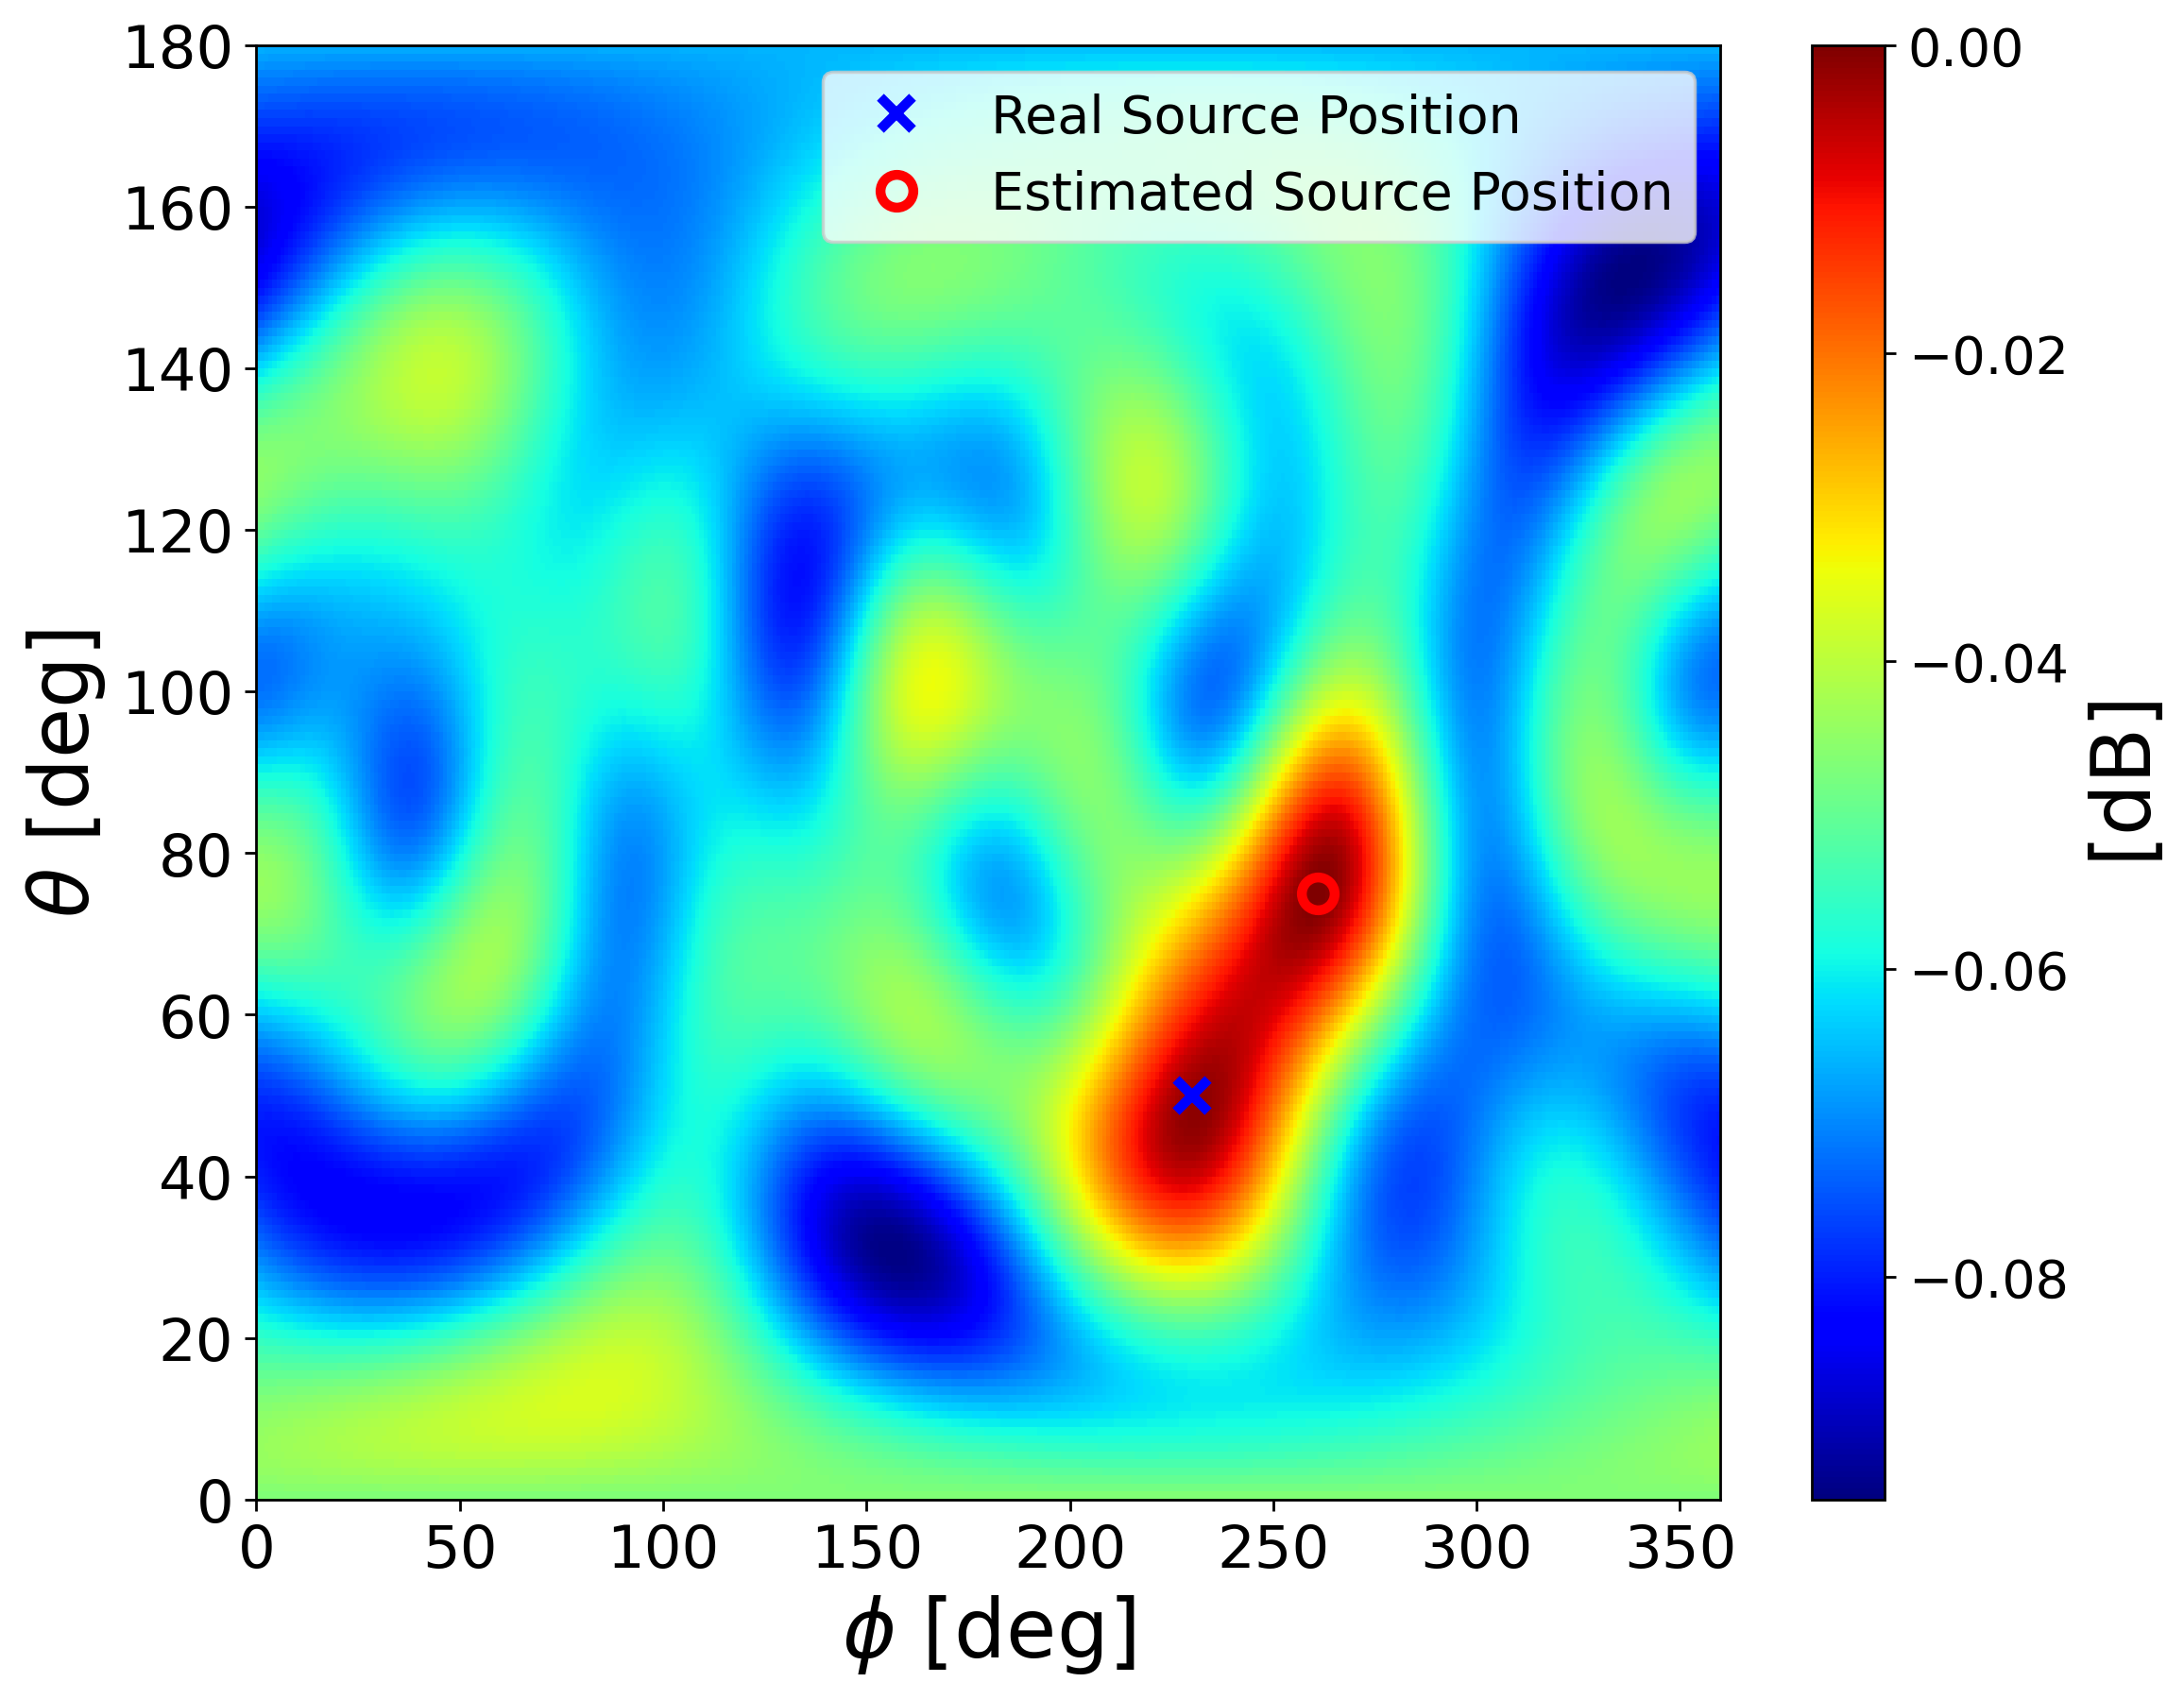

In [25]:
out_SHMUSIC, pos_est_SHMUSIC = ssl_SHmethod_broad(mic_signals_noisy,fs,mic_pos_sph,Theta_l,Phi_l,"SHMUSIC","rigid","2D",resolution = 1)

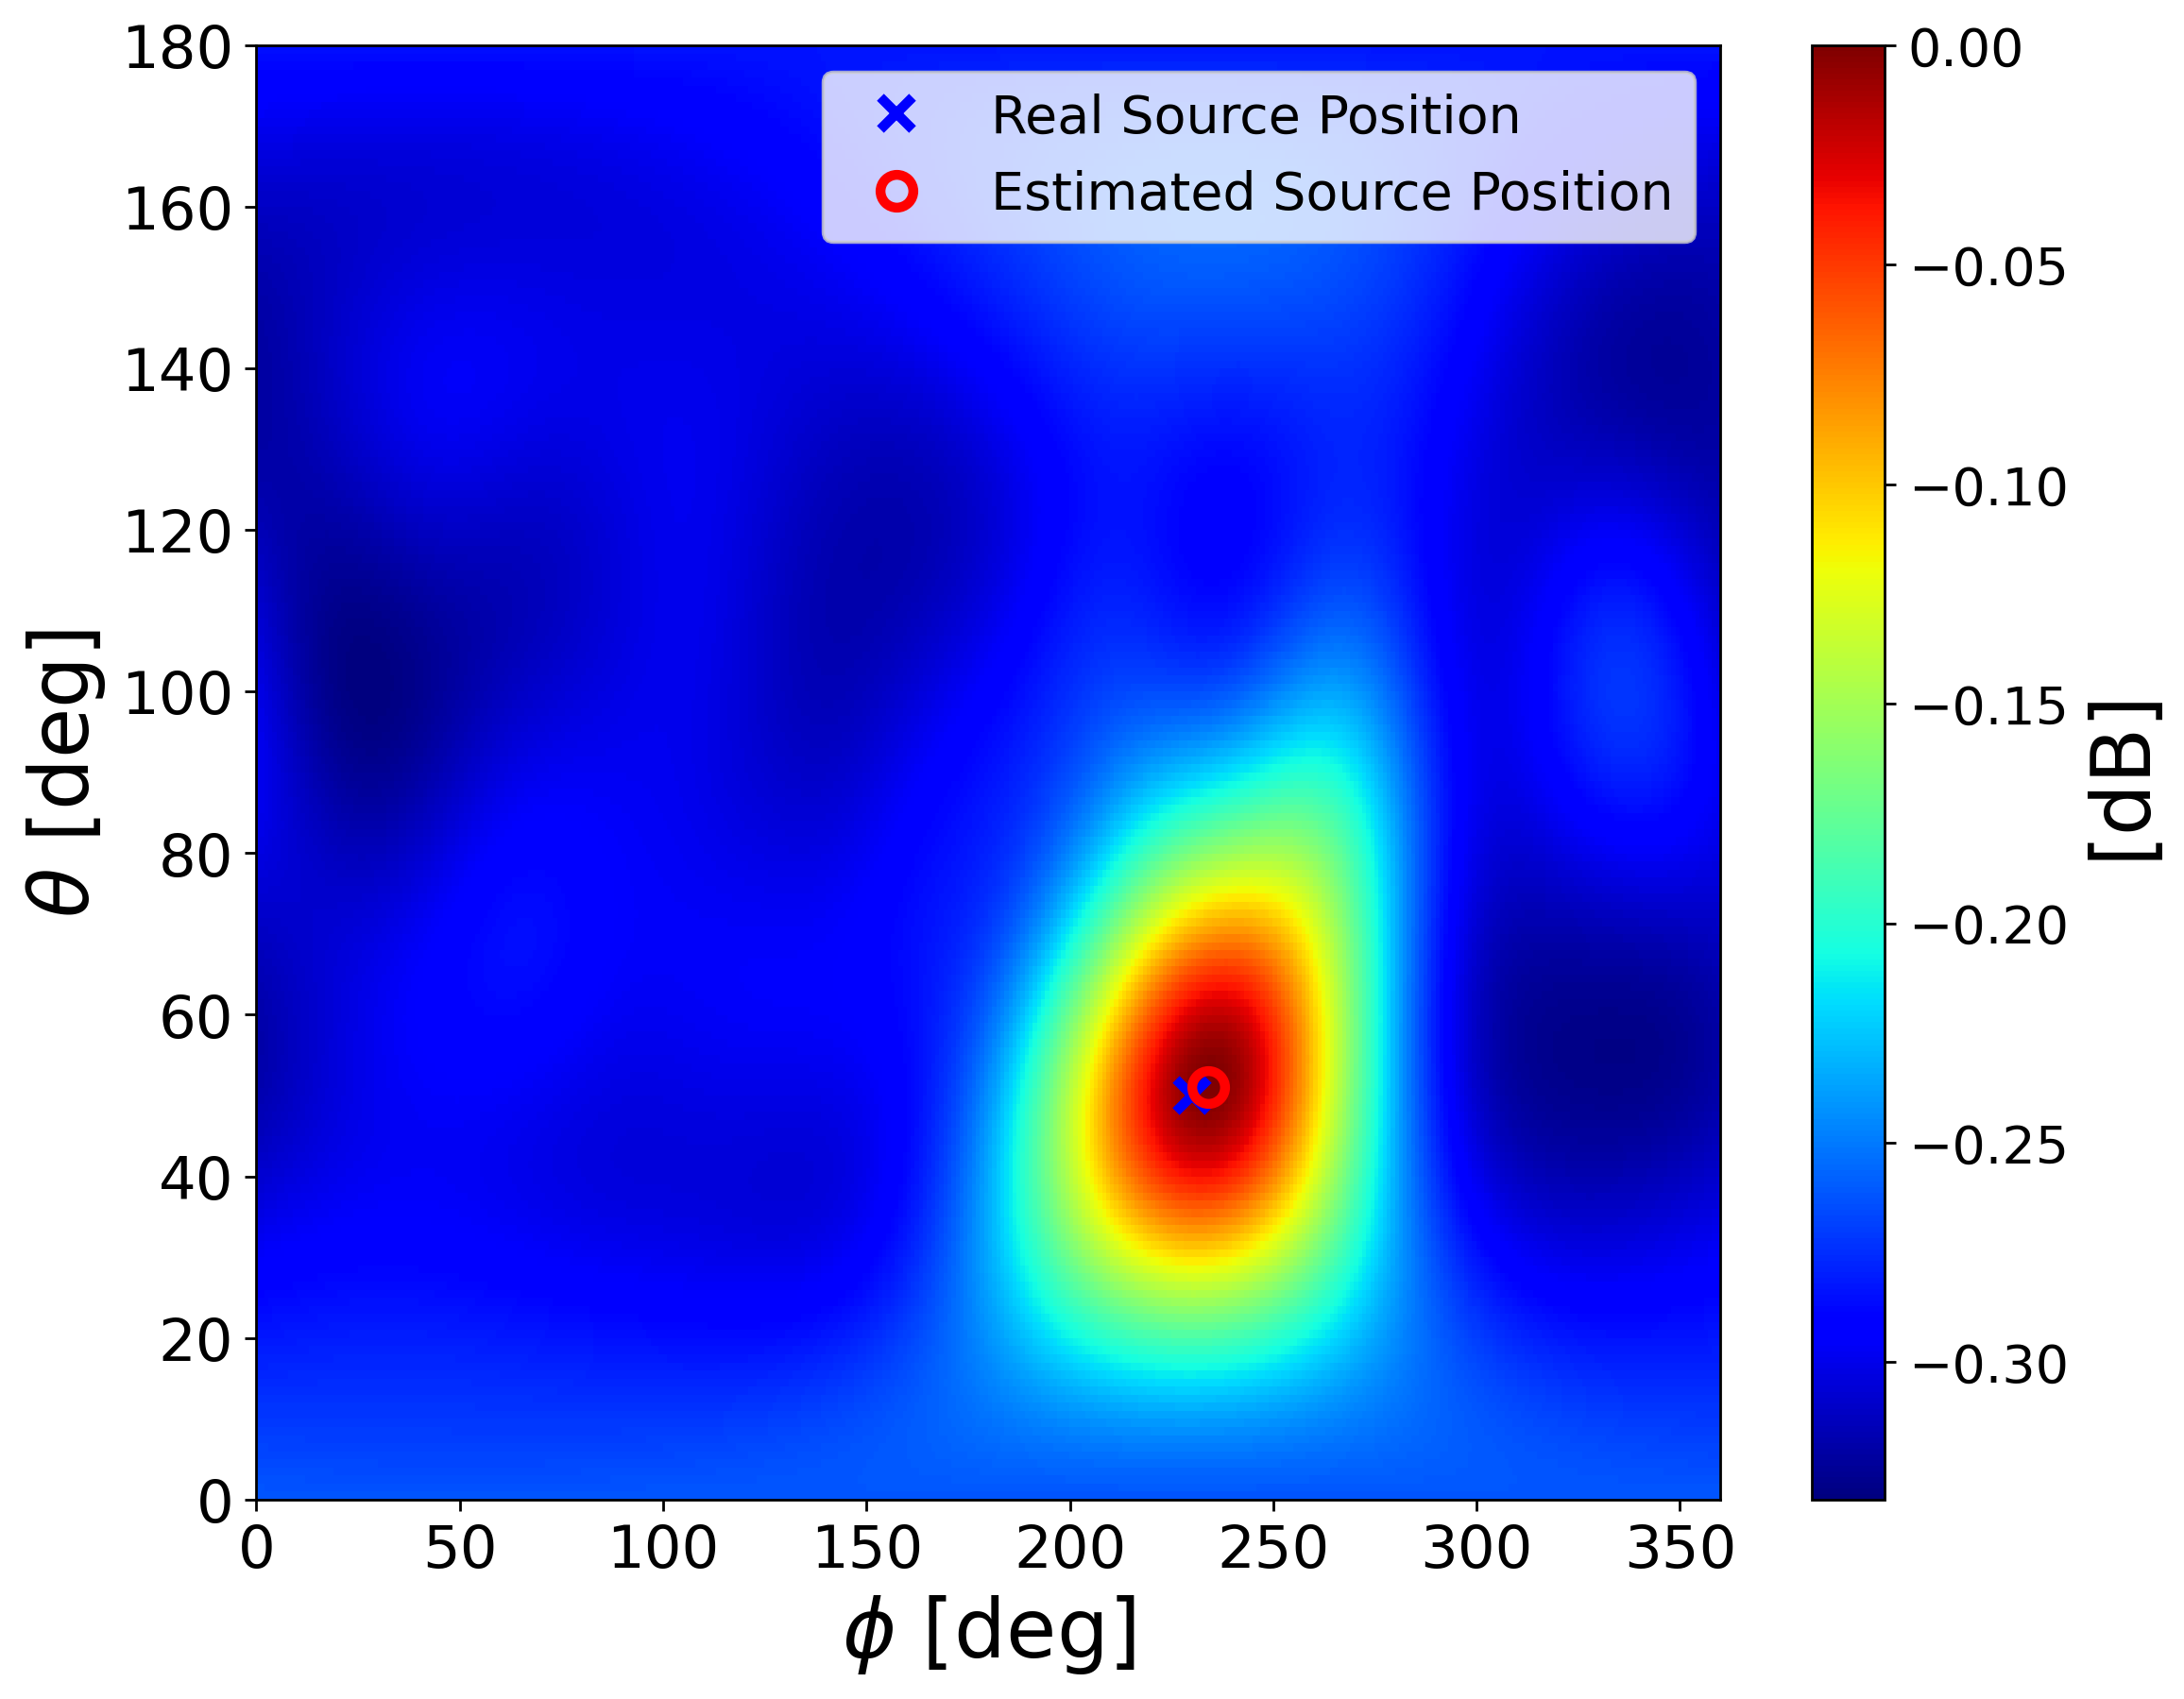

In [26]:
out_MVDR, pos_est_MVDR = ssl_SHmethod_broad(mic_signals_noisy,fs,mic_pos_sph,Theta_l,Phi_l,"SHMVDR","rigid","2D",resolution = 1)

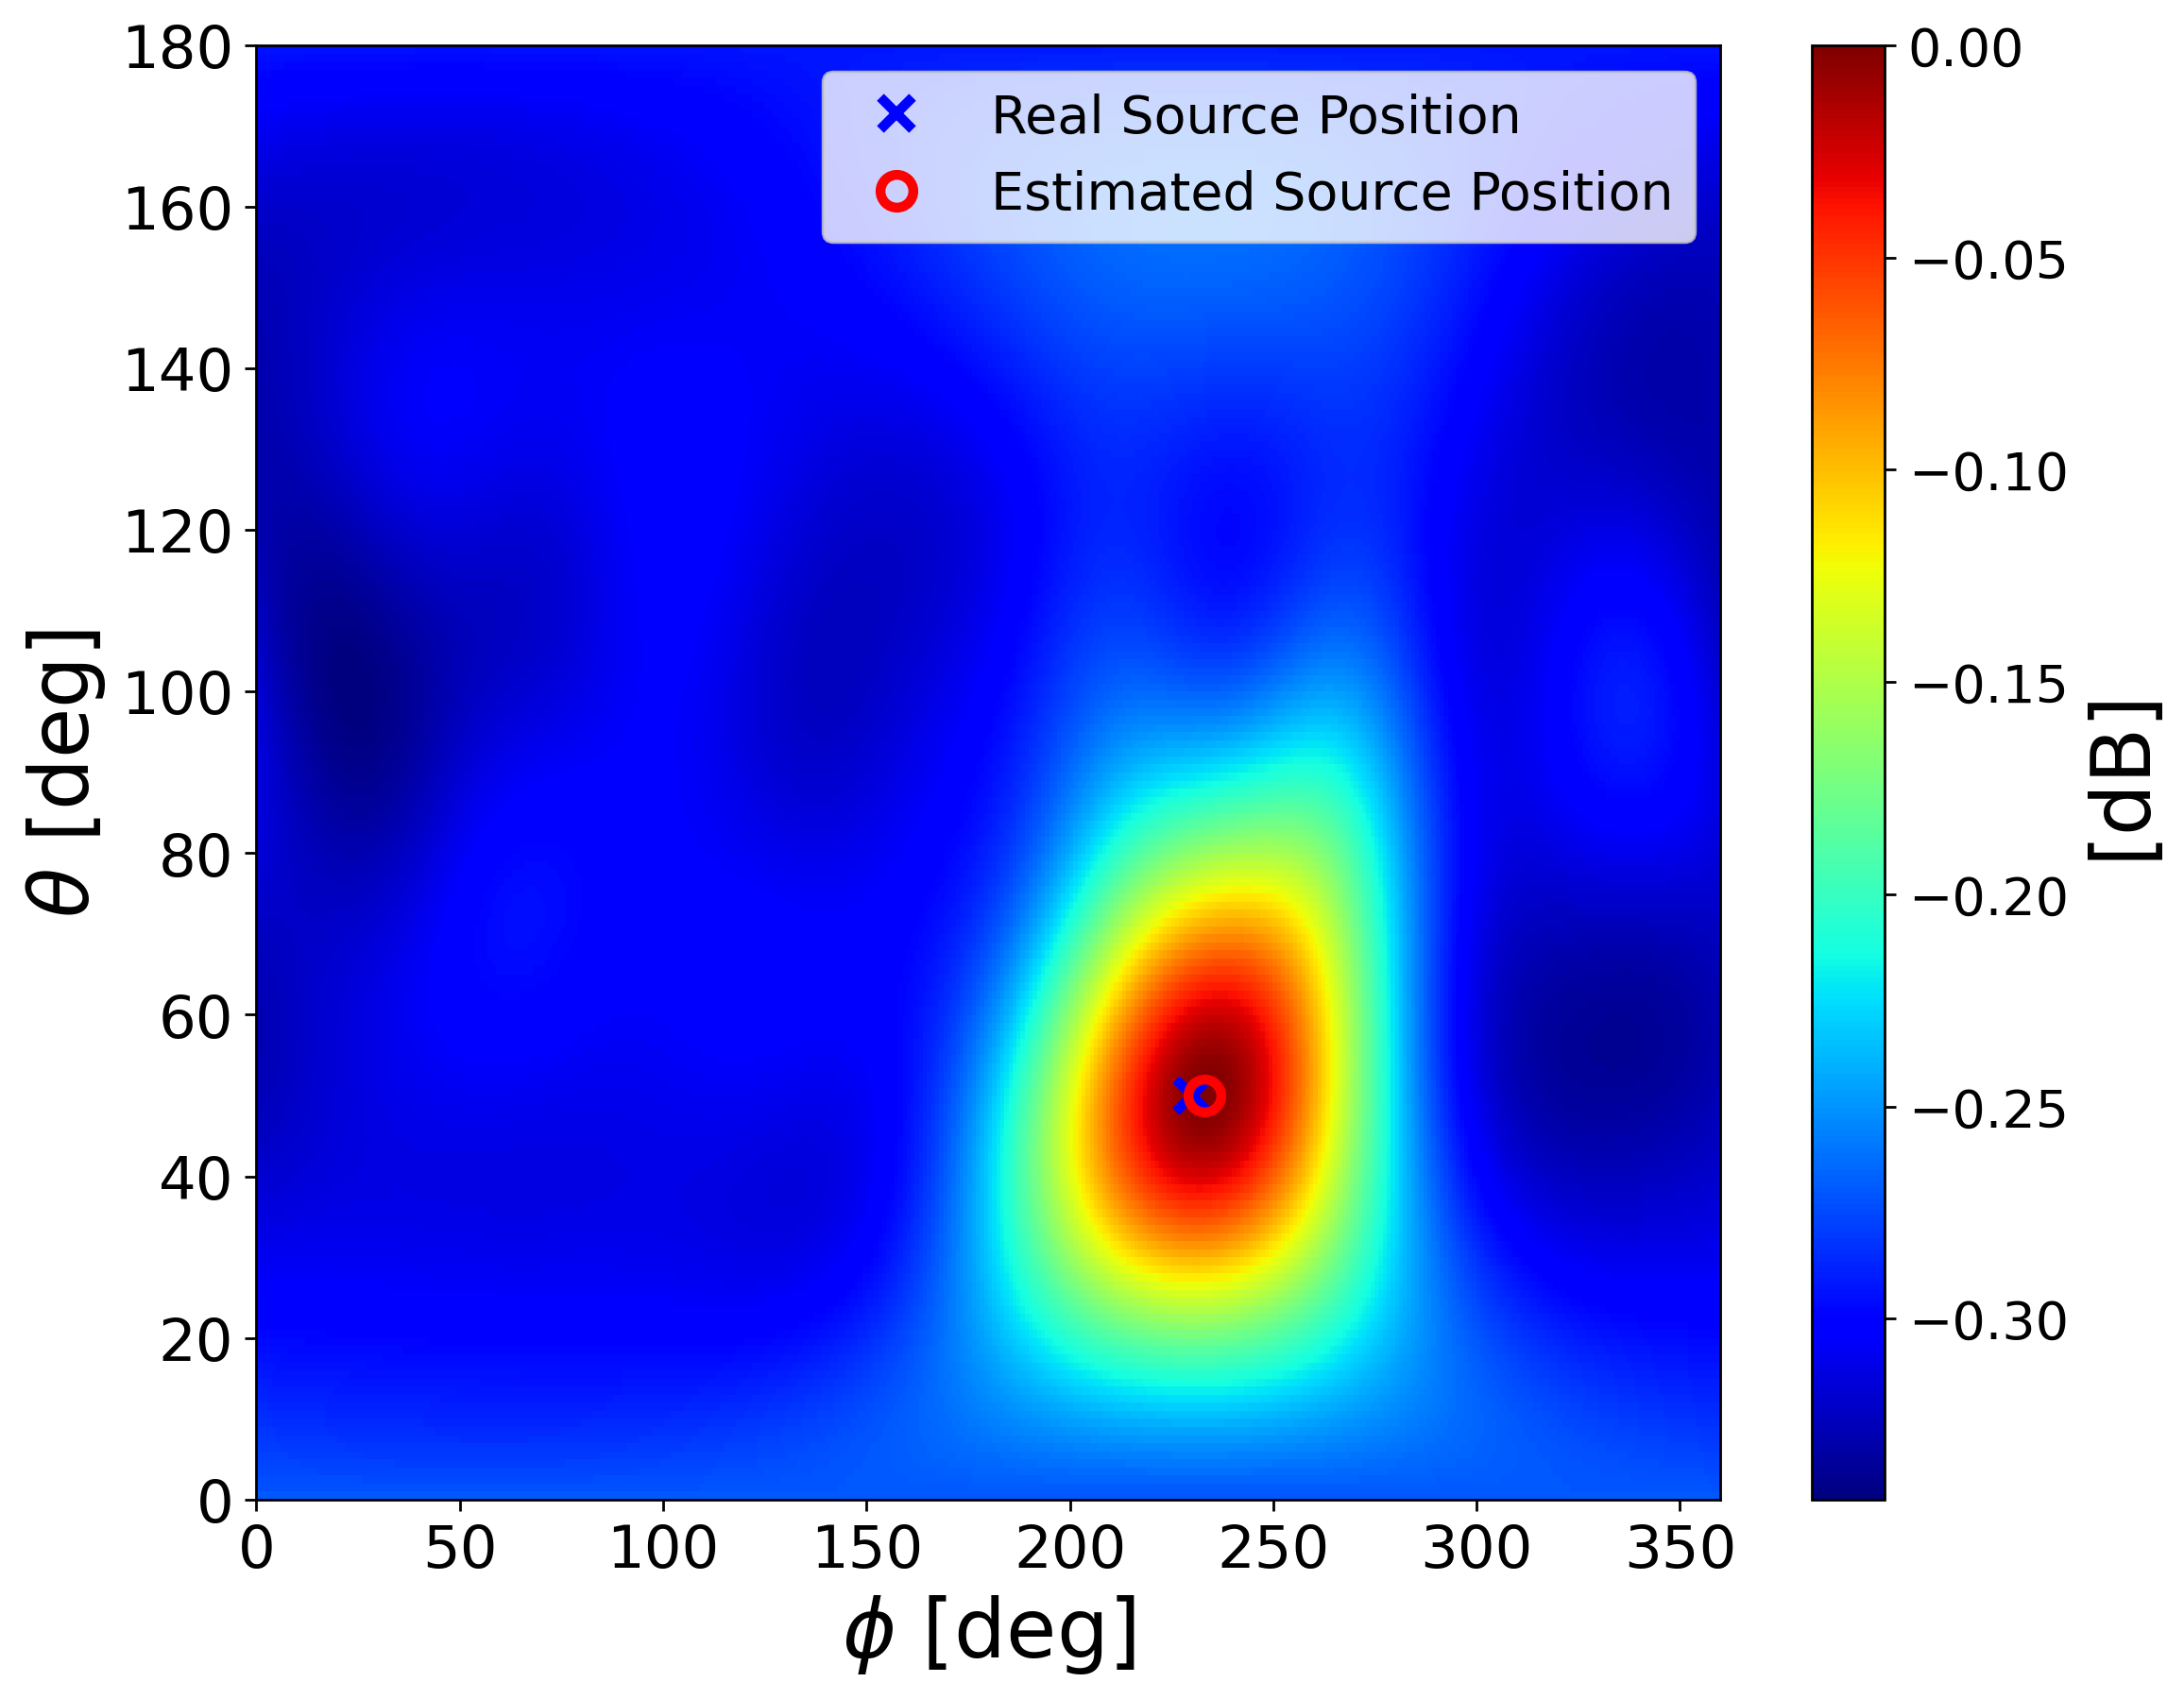

In [27]:
out_SHMLE, pos_est_SHMLE = ssl_SHmethod_broad(mic_signals_noisy,fs,mic_pos_sph,Theta_l,Phi_l,"SHMLE","rigid","2D",resolution = 1)

通过上述的结果可以看到，PWD算法和SHMUSIC算法在混响和噪声环境下性能表现不佳，MVDR算法虽然能够实现较高的空间分辨率以及定位精度，但是计算成本太高了，而SHMLE算法能够保证定位精度和空间分辨率的同时，还能具有较好的计算成本。

#### 多声源定位
在这里考虑引入多声源进行定位，看看结果
考虑一个声源来自$(90\degree, 150\degree)$，另一个声源来自$(90\degree, 210\degree)$， 而在这里，我们主要考虑三种分辨率较高的算法的效果，其余仿真与之前单声源设置一致，均在$T_{60} = 0.6s$左右且 SNR = 15的环境下进行定位。

In [89]:
from tools import setRoom_multi

In [90]:
mic_signals_ori, fs, num_channels = soundread('/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain/Data/speech@24kHz.wav')
mic_signals1 = mic_signals_ori
mic_signals2 = mic_signals_ori
# The spherical coordinate of sound source
Theta_s1 = 90/180 * np.pi
Phi_s1 = 100/180 * np.pi
source1_pos_car = 50*radius * np.array([np.sin(Theta_s1) * np.cos(Phi_s1), np.sin(Theta_s1) * np.sin(Phi_s1), np.cos(Theta_s1)])
Theta_s2 = 90/180 * np.pi
Phi_s2 = 300/180 * np.pi
source2_pos_car = 50*radius * np.array([np.sin(Theta_s2) * np.cos(Phi_s2), np.sin(Theta_s2) * np.sin(Phi_s2), np.cos(Theta_s2)])
Theta_real = [Theta_s1, Theta_s2]
Phi_real = [Phi_s1, Phi_s2]

In [91]:
mic_pos_car_cal = mic_pos_car + ori_coor
source1_pos_car_cal = source1_pos_car + ori_coor
source2_pos_car_cal = source2_pos_car + ori_coor

mic_pos_sph_cal = cart2sph(mic_pos_car_cal)
signal_list = [mic_signals1, mic_signals2]
source_pos_car_list = [source1_pos_car_cal, source2_pos_car_cal]

0.6272858072916667


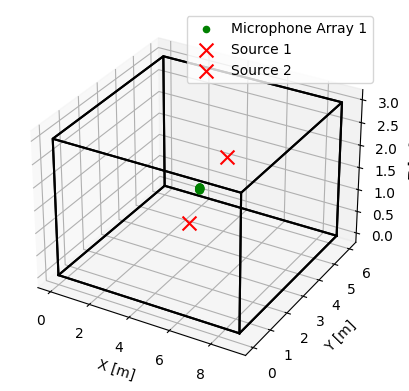

In [92]:
# Add the sources and the microphone array to the room
anechoic_room = setRoom_multi(room_dim, mic_pos_car_cal, source_pos_car_list, signal_list, "Anechoic")

reverb_room,rt60 = setRoom_multi(room_dim, mic_pos_car_cal, source_pos_car_list, signal_list, "Reverb",0.4)
print(rt60)
plot_option(reverb_room,[mic_pos_car_cal],source_pos_car_list)

In [93]:
file_path ='/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain/Reverberant/Array_output0.wav'
signal_processed = pra.create_noisy_signal(file_path,15)
mic_signals = signal_processed[0]

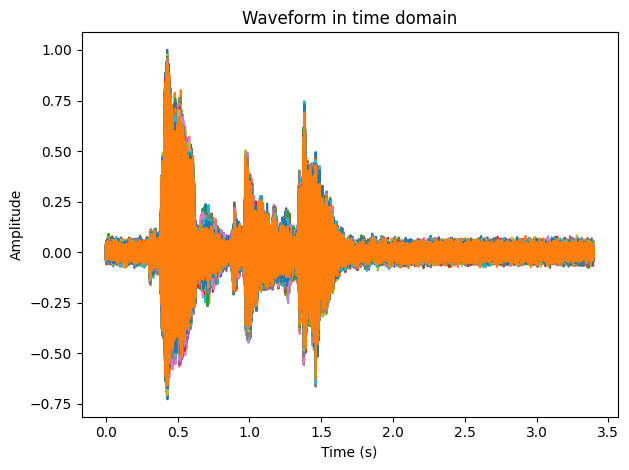

In [94]:
plot_wave(mic_signals,fs)

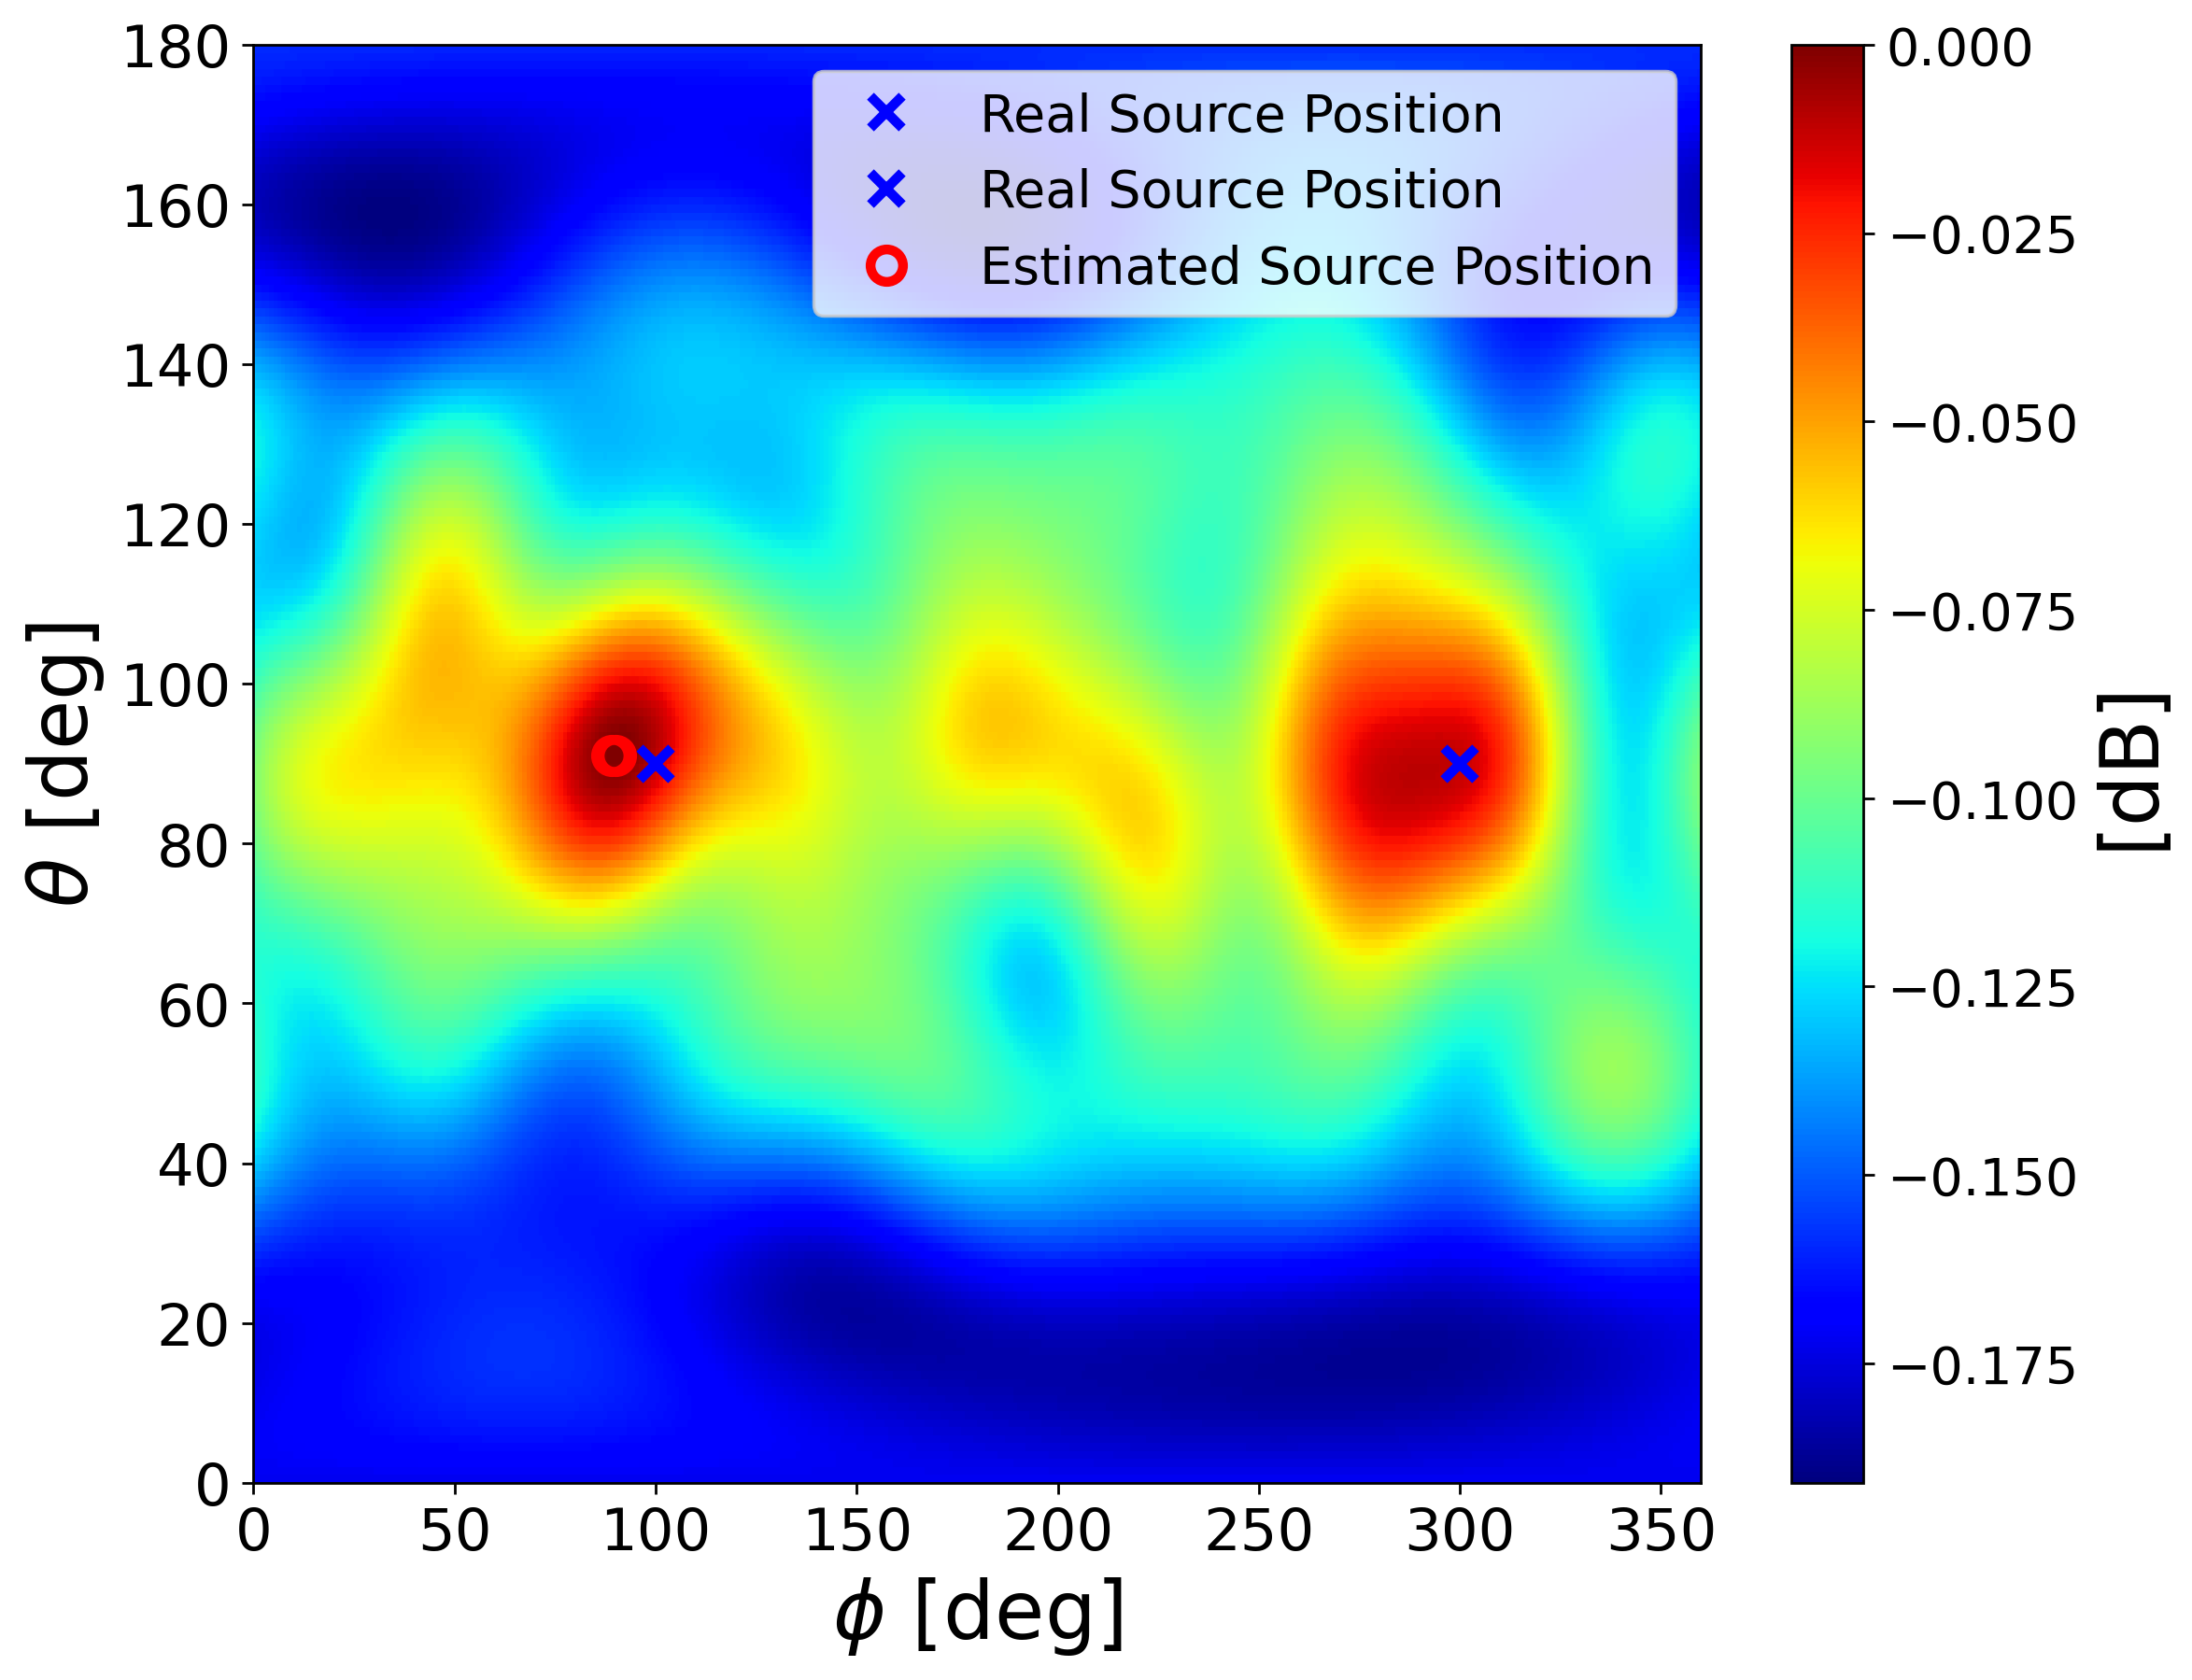

In [95]:
out_SHMUSIC, est_SHMUSIC = ssl_SHmethod_broad(mic_signals,fs,mic_pos_sph,Theta_real,Phi_real,"SHMUSIC","rigid","2D",resolution=1,num_sources=2)

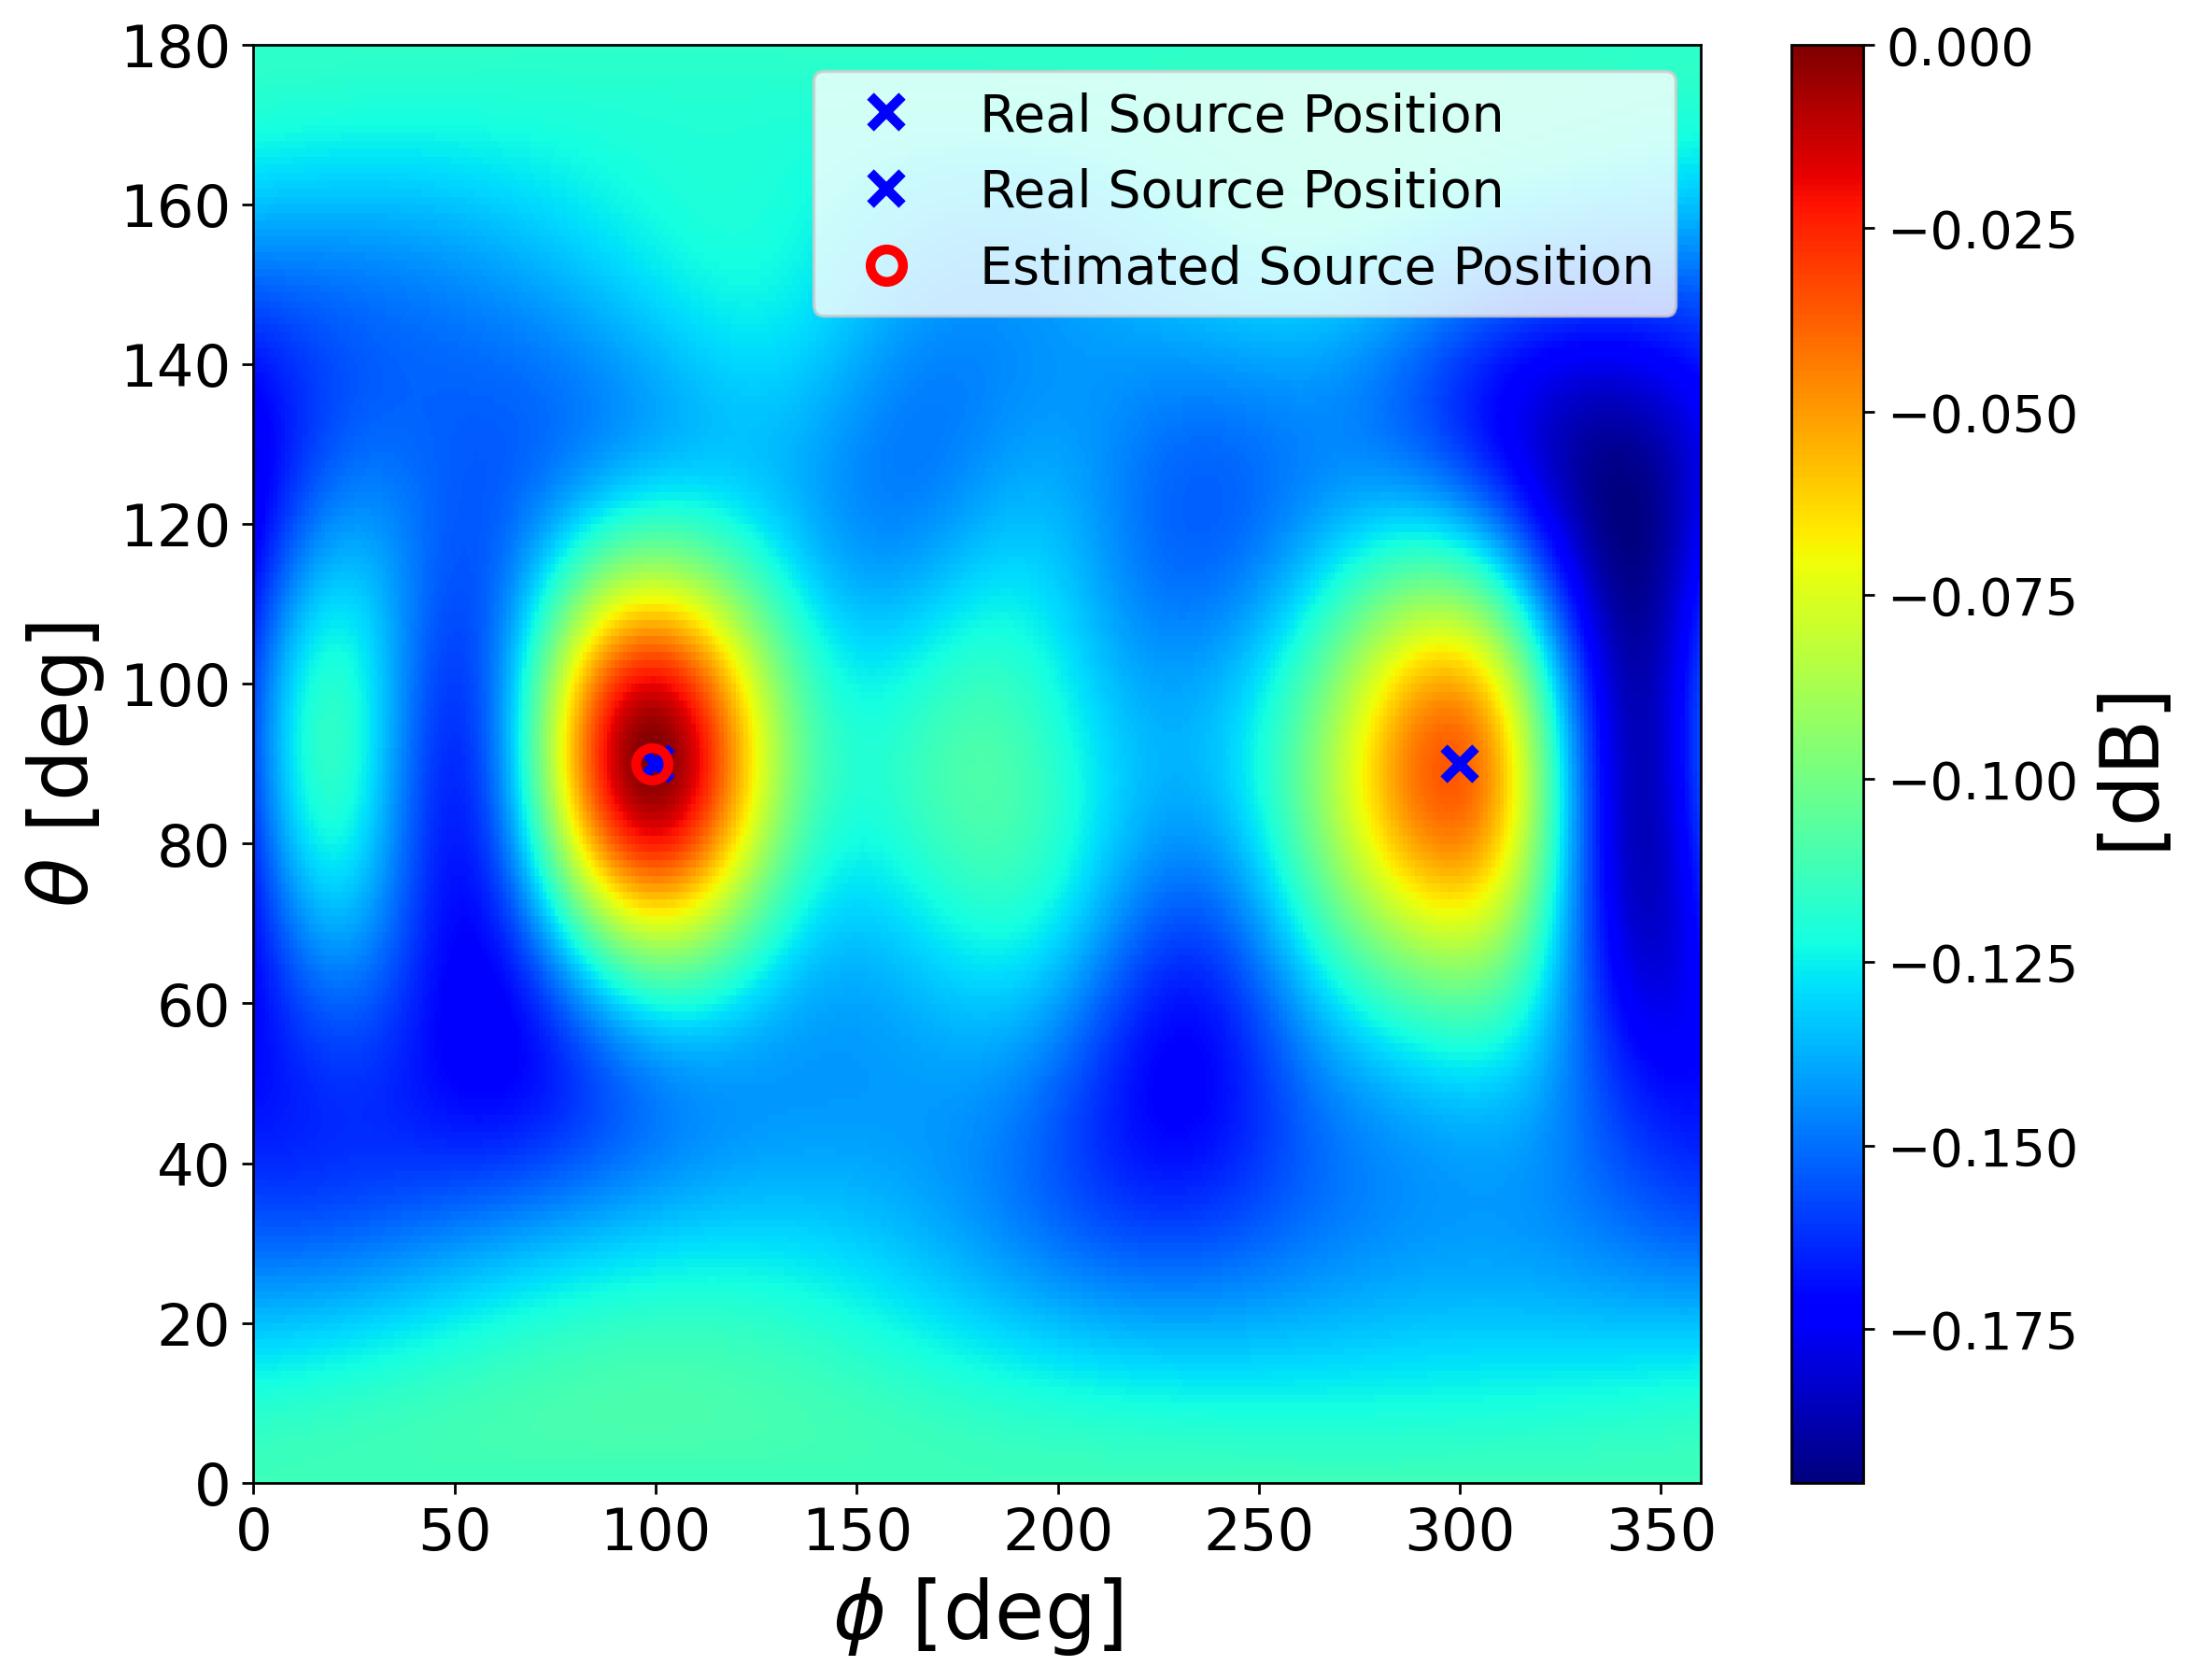

In [96]:
out_SHMUSIC, est_SHMUSIC = ssl_SHmethod_broad(mic_signals,fs,mic_pos_sph,Theta_real,Phi_real,"SHMLE","rigid","2D",resolution=1,num_sources=2)

In [97]:
out_SHMUSIC, est_SHMUSIC = ssl_SHmethod_broad(mic_signals,fs,mic_pos_sph,Theta_real,Phi_real,"SHMVDR","rigid","2D",resolution=1,num_sources=2)

### 使用真实数据验证算法性能

在之前的几节中，已经介绍了声源定位的原理，如何仿真以及对单声源，多声源的定位，而在这一节，我们将介绍如何使用真实数据集来进行声源定位。

这里使用的数据集是来自 METU SPARG 实验室的 Eigenmike em 32 声脉冲响应数据集v0.1.0 来自 METU SPARG 实验室。该数据集是在一个高度混响的矩形房间中录制的，房间尺寸为 $6.5 × 8.3 × 2.9 m^3$
有，声脉冲响应是在一个水平分辨率为 0.5 米、垂直分辨率为 0.3 米的网格上的 240 个点上测量的，覆盖了以阵列为原点从 0°到 360°的整个方位角范围，以及从水平面算起约 ±50° 的仰角范围。测量位置如下所示:

![Alt text](image-3.png)

对数据集进行预处理，提取每个文件夹中的文件，并将其转换到对应DoA

In [ ]:

import math 

def calculate_DoA(X, Y, Z):
    x = (3 - X) * 0.5
    y = (3 - Y) * 0.5
    z = (2 - Z) * 0.3
    r = math.sqrt(x ** 2 + y ** 2 + z ** 2)
    
    theta_rad = math.acos(z / r)
    
    if z < 0:
        theta_rad = math.pi - theta_rad
    
    phi_rad = math.atan2(y, x) + math.pi

    if phi_rad < 0:
        phi_rad += 2 * math.pi
    
    return math.degrees(theta_rad), math.degrees(phi_rad)

directory = "/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain/Data/spargair/em32"

# Create a dictionary to store each folder and corresponding DoA
folder_DoA_dict = {}

for folder in os.listdir(directory):
    try:
        X = int(folder[0])
        Y = int(folder[1])
        Z = int(folder[2])
        theta, phi = calculate_DoA(X, Y, Z)
        folder_DoA_dict[folder] = (theta, phi)
    except ValueError:
        print(f"Skipping folder {folder}, as it does not math the expected format.")
        continue

# Print the transform result
for folder, (theta, phi) in folder_DoA_dict.items():
    print(f"Folder: {folder}, DoA (theta, phi): ({theta}, {phi})")


Folder: 000, DoA (theta, phi): (74.20683095173604, 225.0)
Folder: 001, DoA (theta, phi): (81.95053302447161, 225.0)
Folder: 002, DoA (theta, phi): (90.0, 225.0)
Folder: 003, DoA (theta, phi): (81.9505330244716, 225.0)
Folder: 004, DoA (theta, phi): (74.20683095173602, 225.0)
Folder: 010, DoA (theta, phi): (71.59151982941417, 213.69006752597977)
Folder: 011, DoA (theta, phi): (80.55198356479771, 213.69006752597977)
Folder: 012, DoA (theta, phi): (90.0, 213.69006752597977)
Folder: 013, DoA (theta, phi): (80.5519835647977, 213.69006752597977)
Folder: 014, DoA (theta, phi): (71.59151982941417, 213.69006752597977)
Folder: 020, DoA (theta, phi): (69.21958251233642, 198.434948822922)
Folder: 021, DoA (theta, phi): (79.25659619822405, 198.434948822922)
Folder: 022, DoA (theta, phi): (90.0, 198.434948822922)
Folder: 023, DoA (theta, phi): (79.25659619822403, 198.434948822922)
Folder: 024, DoA (theta, phi): (69.21958251233642, 198.434948822922)
Folder: 030, DoA (theta, phi): (68.19859051364818, 

那么现在考虑定位Folder 032作为example, 对应的真实DoA为$(90\degree, 180\degree)$

In [ ]:
Theta_l = 90/180 * np.pi
Phi_l = 180/180 * np.pi

In [ ]:
# set the data file direction
data_path = '/content/Classical-Sound-Source-Localization-Algorithms-in-Spherical-Domain/Data/spargair/em32/032'
# get all the wav file in the folder
wav_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
fs = 48000

audio_data_list = []
# read each wav file
for wav_file in wav_files:
    file_path = os.path.join(data_path, wav_file)

    sample_rate, audio_data = wavfile.read(file_path)

    audio_data_list.append(audio_data)


In [ ]:
audio_data_array3 = np.stack(audio_data_list, axis=-1)
audio_data_array2 = np.stack(audio_data_list, axis=-1)
audio_data_array1 = np.stack(audio_data_list, axis=-1)
audio_data_array = audio_data_array1 + audio_data_array2 +audio_data_array3

d:\Coderlife\SSL in spherical domain\tools.py:658: RuntimeWarning: invalid value encountered in scalar divide
  


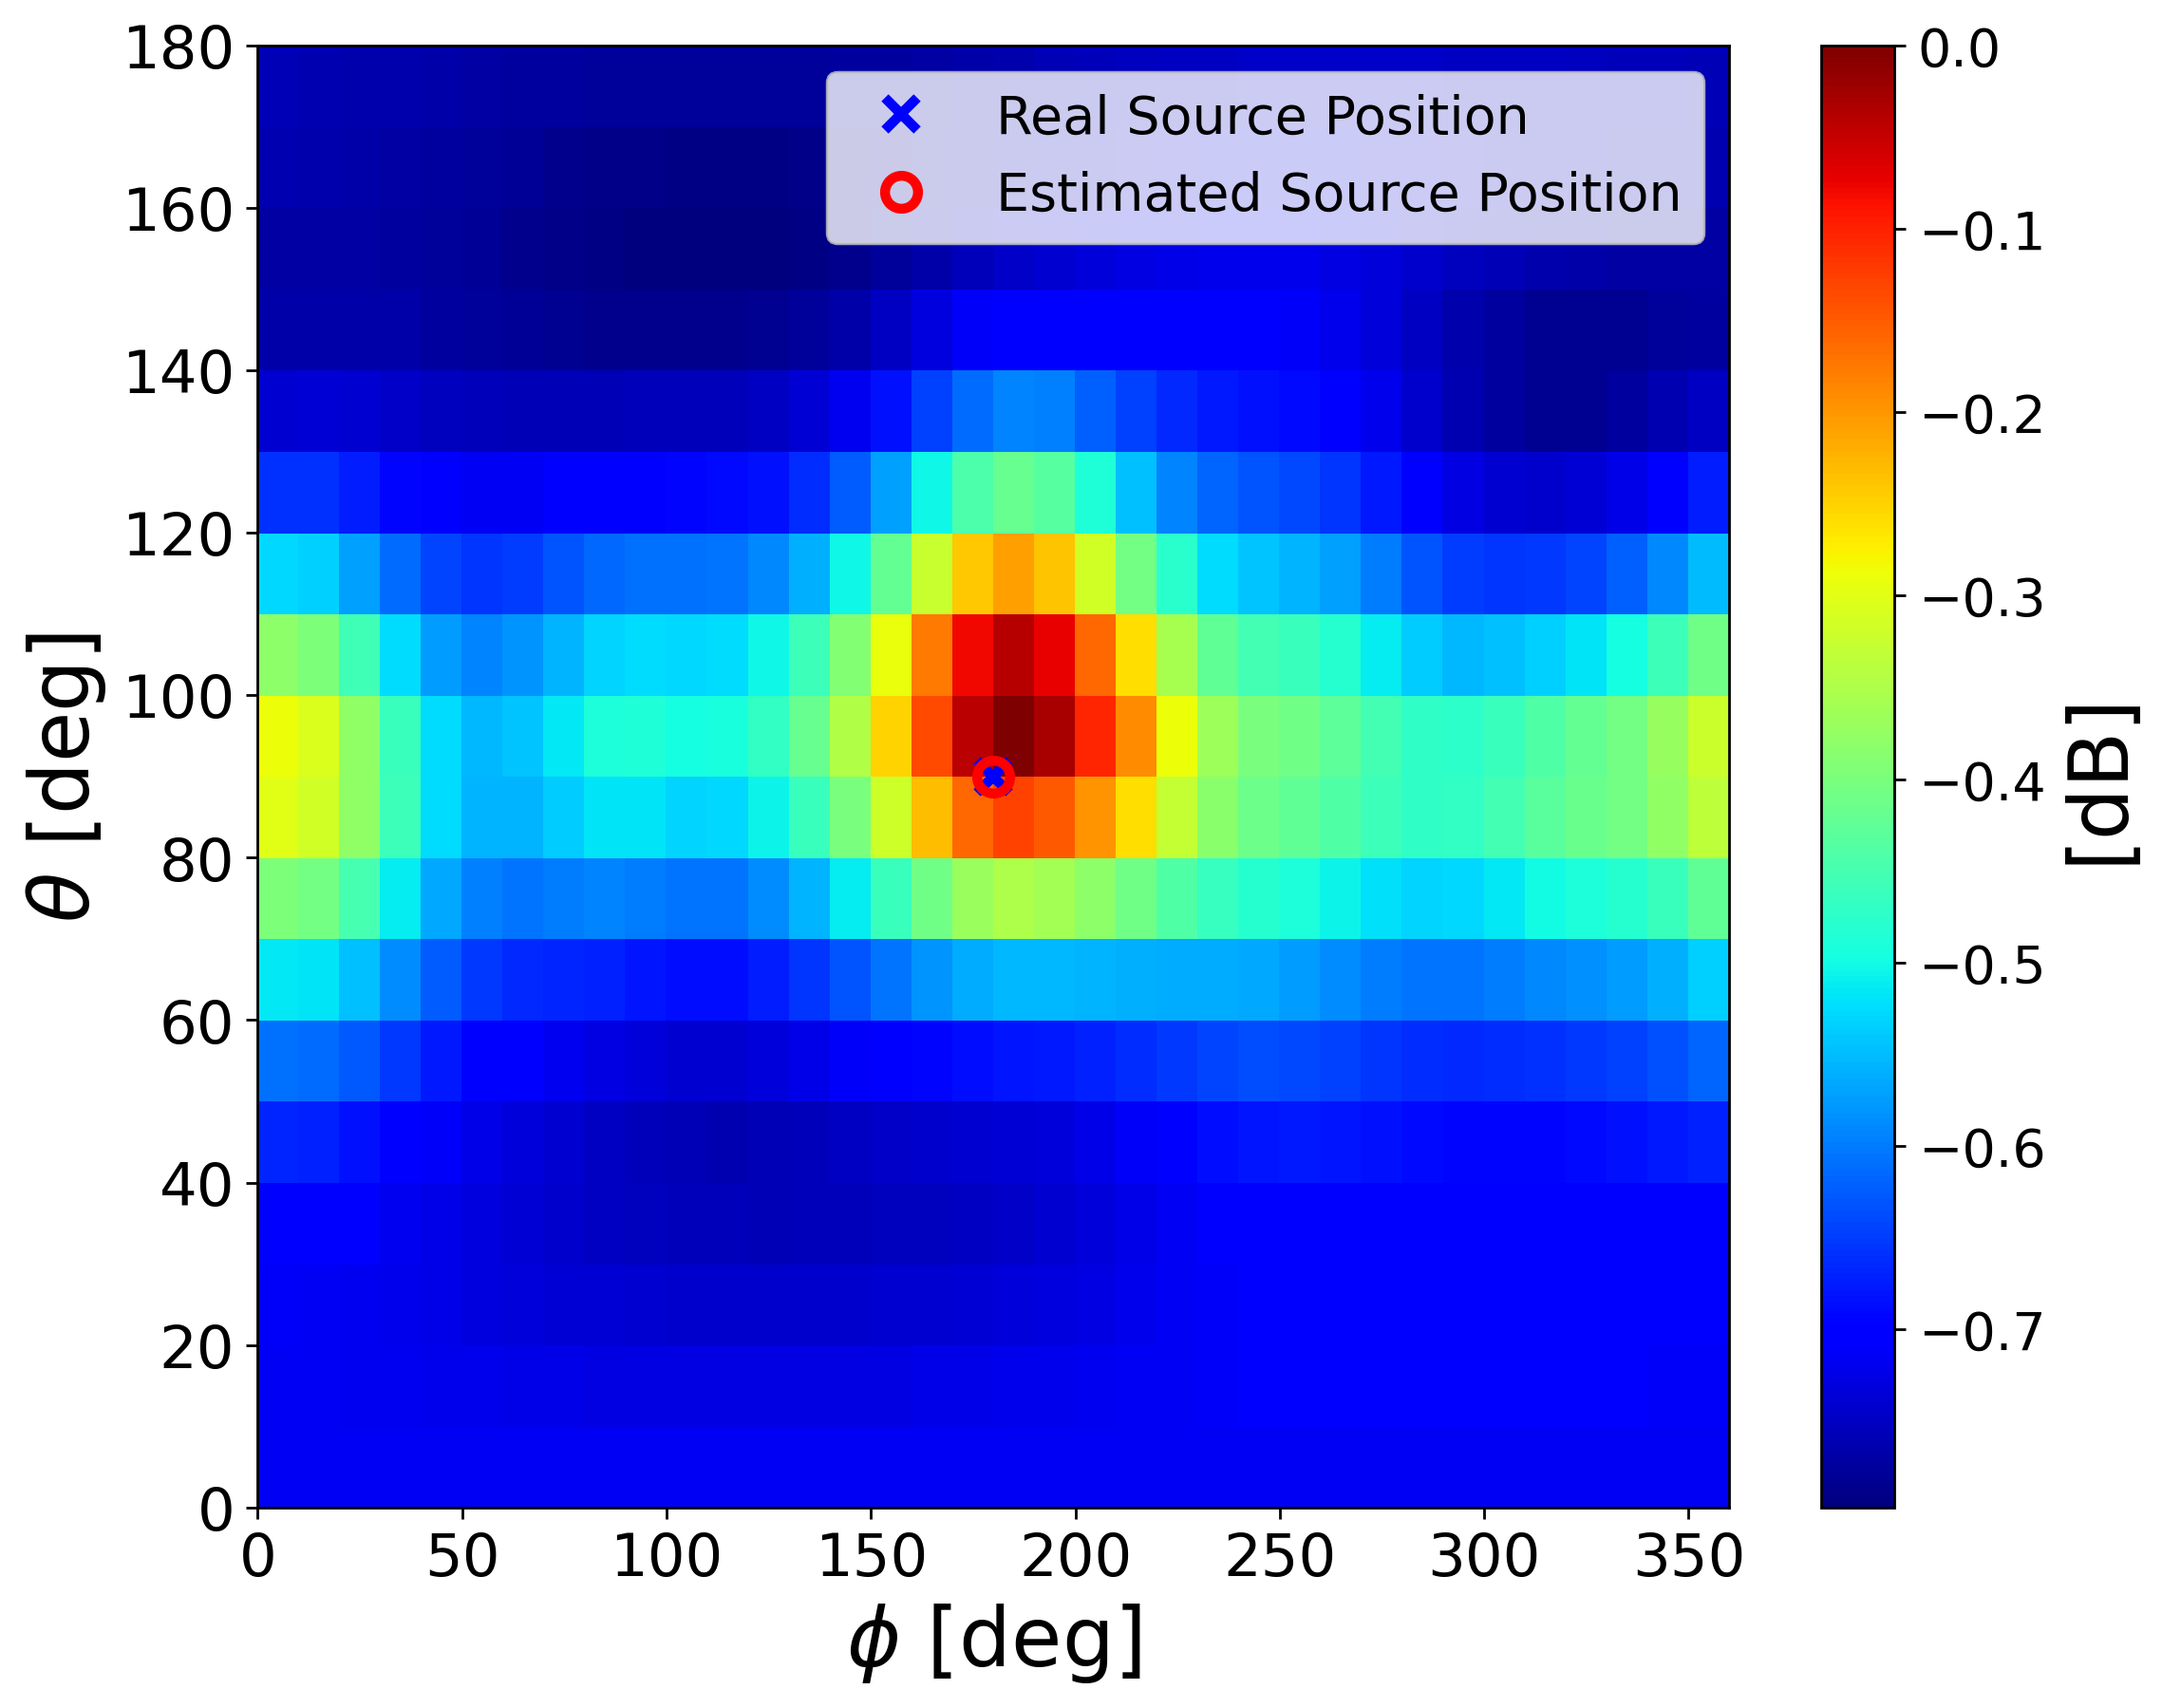

In [ ]:
out_MVDR, pos_MVDR = ssl_SHmethod_broad(audio_data_array,fs,mic_pos_sph,Theta_l,Phi_l,"SHMVDR","rigid","2D",resolution=1)

In [ ]:
out_SHMUSIC, pos_SHMUSIC = ssl_SHmethod_broad(audio_data_array,fs,mic_pos_sph,Theta_l,Phi_l,"SHMUSIC","rigid","2D",resolution=1)

In [ ]:
out_MLE, pos_MLE = ssl_SHmethod(audio_data_array,fs,mic_pos_sph,Theta_l,Phi_l,"SHMLE","rigid","2D",resolution=1)